### Seq2Seq Beam Search + Attention + RL
- Tensorflow 1.4.0+ is required.
- This is based on [NMT Tutorial](https://github.com/tensorflow/nmt).
- Experiment [notes](https://github.com/higepon/tensorflow_seq2seq_chatbot/wiki).



In [8]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up python-apt (1.4.0~beta3build2) ...
Setting up python3-dbus (1.2.4-1build3) ...
Setting up python-software-properties (0.96.24.17) ...
Setting up softwar

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [12]:
import os   
import mmap 
import json
import hashlib

def colab():
    return '/tools/node/bin/forever' == os.environ['_']

if colab():
    !pip -q install pydrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    def make_drive():
        # 1. Authenticate and create the PyDrive client.
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        return drive
    drive = make_drive()
else:        
    drive = None
    def make_drive():
        return None

def client_id():
  clients = {'dfc1d5b22ba03430800179d23e522f6f': 'client1',
                   'f8e857a2d792038820ebb2ae8d803f7c': 'client2',
                   '7628f983785173edabbde501ef8f781d': 'client3'}
  with open('/content/datalab/adc.json') as json_data:
      d = json.load(json_data)
      email =d['id_token']['email'].encode('utf-8')
      return clients[hashlib.md5(email).hexdigest()]
    
print(client_id())
current_client_id = client_id()

client1


In [10]:
# Generate creds for the Drive FUSE library.
if not os.path.exists('drive'):
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !echo "Auth"
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Auth
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
if not os.path.exists('drive'):
  !mkdir -p drive
  !google-drive-ocamlfuse drive

client1


In [2]:
!pip -q install git+https://github.com/mrahtz/easy-tf-log#egg=easy-tf-log[tf]
from easy_tf_log import tflog, Logger
import easy_tf_log

# Hack to reset the logger state
#Logger.DEFAULT = None

from __future__ import print_function
from enum import Enum, auto

class Mode(Enum):
    Test = auto()
    TrainSeq2Seq = auto()
    TrainSeq2SeqSwapped = auto()
    TrainRL = auto()
    TweetBot = auto()

mode = Mode.Test
#mode = Mode.TrainSeq2Seq
#mode = Mode.TrainSeq2SeqSwapped
#mode = Mode.TrainRL
#mode = Mode.TweetBot


# @formatter:off
import copy as copy
from google.colab import files
import datetime
import re
import shutil
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.python.layers import core as layers_core
from tensorflow.python.platform import gfile

#@formatter:on

if colab():
    import matplotlib.pyplot as plt

# Note for myself.
# You've summarized Seq2Seq
# at http://d.hatena.ne.jp/higepon/20171210/1512887715.

# If you see following error, it means your max(len(tweets of training set)) <  decoder_length.
# This should be a bug somewhere in build_decoder, but couldn't find one yet.
# You can workaround by setting hparams.decoder_length=max len of tweet in training set.
# InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [48,50] and labels shape [54]
#	 [[Node: root/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, 

print(tf.__version__)

def data_dir():
    target_dir = "{}/chatbot_data".format(str(Path.home()))
    if not colab() and not os.path.exists(target_dir):
        raise Exception("{} not found, you may create".format(target_dir))
    return target_dir


def info(message, hparams):
    if hparams.debug_verbose:
        print(message)


def p(path):
    if colab():
        return path
    else:
        return "{}/{}".format(data_dir(), path)


def has_gpu0():
    return tf.test.gpu_device_name() == "/device:GPU:0"


class ModelDirectory(Enum):
    tweet_large = 'model/tweet_large'
    tweet_large_rl = 'model/tweet_large_rl'
    tweet_large_swapped = 'model/tweet_large_swapped'
    tweet_small = 'model/tweet_small'
    tweet_small_swapped = 'model/tweet_small_swapped'
    tweet_small_rl = 'model/tweet_small_rl'
    test_multiple1 = 'model/test_multiple1'
    test_multiple2 = 'model/test_multiple2'
    test_multiple3 = 'model/test_multiple3'
    test_distributed = 'model/test_distributed'

    @staticmethod
    def create_all_directories():
        for d in ModelDirectory:
            os.makedirs(p(d.value), exist_ok=True)


# todo
# collect all initializer
ModelDirectory.create_all_directories()


if current_client_id == 'client1':
    class GoogleDriveFolder(Enum):
        root = '146ZLldWXLDH0l9WbSUNFKi3nVK_HV0Sz'
        seq2seq = '18lYBgKvX3AG1zhwJqP1tRYJU688U1N95'
        seq2seq_swapped = '1w56FFoKStEfZNThA2Y_jx3NDTELcau52'
        seq2seq_rl = '1pHnOuT_7JjD1TS8VQ4KN9oUiblBIABXJ'
elif current_client_id == 'client2':
    class GoogleDriveFolder(Enum):
        root = '15Z3wbaSjR34ziPgAVEFiXgM67ln1Z9Xt'
        seq2seq = '1KdMwLNbUfI_PZ5QTyi2zvcS___ct399p'
        seq2seq_swapped = '1OjvR4TXAVudSiI-A7EBjw3gLoY4mrO7i'
        seq2seq_rl = '161ler0gTpsvFUPAvc4x1__jyClJ_8IyB'
elif current_client_id == 'client3':
    class GoogleDriveFolder(Enum):
        root = '10uju7H-Li2bWf6C2xq0-SRm-Xfe0MrHH'
        seq2seq = '1Mta4Drvpj6YKW4xMC-Y59TtGLubKLPk9'
        seq2seq_swapped = '1eyvhkGsT5bU9kWxVLfcxDsNzV6A8pdvd'
        seq2seq_rl = '1Rl_hMetwT1A_TlLDTo2ARSL_qTguUXoQ'        

base_hparams = tf.contrib.training.HParams(
    machine=current_client_id,
    batch_size=3,
    num_units=6,
    num_layers=2,
    vocab_size=9,
    embedding_size=8,
    learning_rate=0.01,
    learning_rate_decay=0.99,
    use_attention=False,
    encoder_length=5,
    decoder_length=5,    
    max_gradient_norm=5.0,
    beam_width=2,
    num_train_steps=100,
    debug_verbose=False,
    model_folder_in_drive=GoogleDriveFolder.seq2seq.value,
    model_path='Please override model_directory',
    sos_id=0,
    eos_id=1,
    pad_id=2,
    unk_id=3,
    sos_token="[SOS]",
    eos_token="[EOS]",
    pad_token="[PAD]",
    unk_token="[UNK]",
)

test_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {'beam_width': 0, 'num_train_steps': 100, 'learning_rate': 0.5})



test_attention_hparams = copy.deepcopy(test_hparams).override_from_dict(
    {'use_attention': True})



1.7.0


In [0]:
def print_hparams(hparams):
  result = {}
  for key in ['machine', 'batch_size', 'num_units', 'num_layers', 'vocab_size',
              'embedding_size', 'learning_rate', 'learning_rate_decay',
              'use_attention', 'encoder_length', 'decoder_length',
              'max_gradient_norm', 'beam_width', 'num_train_steps',
              'model_path']:
    result[key] = hparams.get(key)
  print(result)
    


In [0]:
# For debug purpose.
tf.reset_default_graph()


class ChatbotModel:
    def __init__(self, sess, hparams, model_path, scope='ChatbotModel'):
        self.sess = sess
        # todo remove
        self.hparams = hparams

        # todo
        self.model_path = model_path
        self.name = scope

        self.encoder_inputs, self.encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder = self._build_encoder(
            hparams, scope)
        self.decoder_inputs, self.decoder_target_lengths, self.logits = self._build_decoder(
            hparams, self.encoder_inputs_lengths, embedding_encoder,
            encoder_state, encoder_outputs)

        self.reward = tf.placeholder(tf.float32, name="reward")
        self.target_labels, self.loss, self.global_step, self.learning_rate, self.train_op = self._build_optimizer(
            hparams, self.logits)
        self.train_loss_summary = tf.summary.scalar("loss", self.loss)
        self.reward_summary = tf.summary.scalar("reward", self.reward)
        self.valiation_loss_summary = tf.summary.scalar("validation_loss", self.loss)
        self.merged_summary = tf.summary.merge_all()

        # Initialize saver after model created
        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

    def restore(self):
        ckpt = tf.train.get_checkpoint_state(self.model_path)
        if ckpt:
            last_model = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, last_model)
            return True
        else:
            print("Created fresh model.")
            return False

    def train(self, encoder_inputs, encoder_inputs_lengths, target_labels,
              decoder_inputs, decoder_target_lengths, reward=1.0):
        feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
            self.target_labels: target_labels,
            self.decoder_inputs: decoder_inputs,
            self.decoder_target_lengths: decoder_target_lengths,
            # For normal Seq2Seq reward is always 1.
            self.reward: reward
        }
        _, global_step, summary, reward_summary = self.sess.run(
            [self.train_op, self.global_step, self.train_loss_summary, self.reward_summary], feed_dict=feed_dict)

        return global_step, self.learning_rate, summary, reward_summary, reward

    def batch_loss(self, encoder_inputs, encoder_inputs_lengths, target_labels,
                   decoder_inputs, decoder_target_lengths):
        feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
            self.target_labels: target_labels,
            self.decoder_inputs: decoder_inputs,
            self.decoder_target_lengths: decoder_target_lengths,
            # For normal Seq2Seq reward is always 1.
            self.reward: 1
        }
        return self.sess.run([self.loss, self.valiation_loss_summary],
                             feed_dict=feed_dict)
      
    def input_length(self, input):
      try :
        l = input.index(self.hparams.eos_id)
        return l + 1
      except ValueError:
        return self.hparams.encoder_length

    def train_with_reward(self, infer_model, standard_seq2seq_model,
                          encoder_inputs, encoder_inputs_lengths, target_labels,
                          decoder_inputs, decoder_target_lengths,
                          dull_responses):
        infered_replies = infer_model.infer(encoder_inputs,
                                            encoder_inputs_lengths)
#        print(infered_replies)
        standard_seq2seq_encoder_inputs = []
        standard_seq2seq_encoder_inputs_lengths = []
        for reply in infered_replies:
            l = self.input_length(reply.tolist())
            standard_seq2seq_encoder_inputs_lengths.append(l)
            if l <= self.hparams.encoder_length:
                standard_seq2seq_encoder_inputs.append(np.append(reply, (
                        [self.hparams.pad_id] * (self.hparams.encoder_length - len(reply)))))
                None
            else:
                raise Exception(
                    "Inferred"
                    " reply shouldn't be longer than encoder_input")
        standard_seq2seq_encoder_inputs = np.transpose(
            np.array(standard_seq2seq_encoder_inputs))
        if True:
#           print(standard_seq2seq_encoder_inputs_lengths)
           reward1 = np.mean(standard_seq2seq_encoder_inputs_lengths) / self.hparams.encoder_length
        else:
          reward1 = standard_seq2seq_model.reward_ease_of_answering(
              standard_seq2seq_encoder_inputs,
              standard_seq2seq_encoder_inputs_lengths, dull_responses)


        reward2 = 0  # todo
        reward3 = 0  # todo
        reward = 0.25 * reward1 + 0.25 * reward2 + 0.5 * reward3
        
        return self.train(encoder_inputs, encoder_inputs_lengths, target_labels,
                          decoder_inputs, decoder_target_lengths, reward)

    def save(self, model_path=None):
        if model_path is None:
            model_path = self.model_path
        model_dir = "{}/{}".format(model_path, self.name)
        self.saver.save(self.sess, model_dir, global_step=self.global_step)

    @staticmethod
    def _softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def _build_optimizer(self, hparams, logits):
        # Target labels
        #   As described in doc for sparse_softmax_cross_entropy_with_logits,
        #   labels should be [batch_size, decoder_target_lengths]
        #   instead of [batch_size, decoder_target_lengths, vocab_size].
        #   So labels should have indices instead of vocab_size classes.
        target_labels = tf.placeholder(tf.int32, shape=(
            hparams.batch_size, hparams.decoder_length), name="target_labels")
        
        # Loss
        #   target_labels: [batch_size, decoder_length]
        #   logits: [batch_size, decoder_length, vocab_size]
        #   crossent: [batch_size, decoder_length]
        crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=target_labels, logits=logits)
        
        target_weights = tf.sequence_mask(self.decoder_target_lengths, hparams.decoder_length, dtype=logits.dtype)

        loss = tf.reduce_sum(
          crossent * target_weights) / tf.to_float(hparams.batch_size)
        
        # Adjust loss with reward.
        loss = tf.multiply(loss, self.reward)

        # Train
        global_step = tf.get_variable(name="global_step", shape=[],
                                      dtype=tf.int32,
                                      initializer=tf.constant_initializer(0),
                                      trainable=False)
        
        learning_rate = hparams.learning_rate # tf.train.exponential_decay(hparams.learning_rate, global_step, 100, hparams.learning_rate_decay) 

        # Calculate and clip gradients
        params = tf.trainable_variables()
        for param in params:
          info("  {}, {}, {}".format(param.name, str(param.get_shape()),
                                        param.op.device), hparams)
        
        gradients = tf.gradients(loss, params)
        clipped_gradients, _ = tf.clip_by_global_norm(
            gradients, hparams.max_gradient_norm)

        # Optimization
#        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        device = '/cpu:0'
        if has_gpu0():
            device = '/gpu:0'
            print("!!!GPU ENABLED !!!")
        with tf.device(device):
            train_op = optimizer.apply_gradients(
                zip(clipped_gradients, params), global_step=global_step)
        return target_labels, loss, global_step, learning_rate, train_op

    @staticmethod
    def _build_encoder(hparams, scope):
        # Encoder
        #   encoder_inputs: [encoder_length, batch_size]
        #   This is time major where encoder_length comes
        #   first instead of batch_size.
        #   encoder_inputs_lengths: [batch_size]
        encoder_inputs = tf.placeholder(tf.int32, shape=(
            hparams.encoder_length, hparams.batch_size), name="encoder_inputs")
        encoder_inputs_lengths = tf.placeholder(tf.int32,
                                                shape=hparams.batch_size,
                                                name="encoder_inputs_lengtsh")

        # Embedding
        #   We originally didn't share embedding between encoder and decoder.
        #   But now we share it. It makes much easier to calculate rewards.
        #   Matrix for embedding: [vocab_size, embedding_size]
        #   Should be shared between training and inference.
        with tf.variable_scope(scope):
            embedding_encoder = tf.get_variable("embedding_encoder",
                                                [hparams.vocab_size,
                                                 hparams.embedding_size])

        # Look up embedding:
        #   encoder_inputs: [encoder_length, batch_size]
        #   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
        encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    encoder_inputs)

        # LSTM cell.
        with tf.variable_scope(scope):
            # Should be shared between training and inference.
            cell_list = []
            for _ in range(hparams.num_layers):
               cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
            encoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        # Run Dynamic RNN
        #   encoder_outputs: [encoder_length, batch_size, num_units]
        #   encoder_state: [batch_size, num_units],
        #   this is final state of the cell for each batch.
        with tf.variable_scope(scope):
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell,
                                                               encoder_emb_inputs,
                                                               time_major=True,
                                                               dtype=tf.float32,
                                                               sequence_length=encoder_inputs_lengths)

        return encoder_inputs, encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder

    @staticmethod
    def _build_training_decoder(hparams, encoder_inputs_lengths,
                                encoder_state, encoder_outputs, decoder_cell,
                                decoder_emb_inputs, decoder_target_lengths,
                                projection_layer):
        # Decoder with helper:
        #   decoder_emb_inputs: [decoder_length, batch_size, embedding_size]
        #   decoder_target_lengths: [batch_size] vector,
        #   which represents each target sequence length.
        training_helper = tf.contrib.seq2seq.TrainingHelper(decoder_emb_inputs,
                                                            decoder_target_lengths,
                                                            time_major=True)

        # See https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units,
                attention_encoder_outputs,
                memory_sequence_length=encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            initial_state = wrapped_decoder_cell.zero_state(hparams.batch_size,
                                                            tf.float32).clone(
                cell_state=encoder_state)
        else:
            wrapped_decoder_cell = decoder_cell
            initial_state = encoder_state

            # Decoder and decode
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
            wrapped_decoder_cell, training_helper, initial_state,
            output_layer=projection_layer)

        # Dynamic decoding
        #   final_outputs.rnn_output: [batch_size, decoder_length,
        #                             vocab_size], list of RNN state.
        #   final_outputs.sample_id: [batch_size, decoder_length],
        #                            list of argmax of rnn_output.
        #   final_state: [batch_size, num_units],
        #                list of final state of RNN on decode process.
        #   final_sequence_lengths: [batch_size], list of each decoded sequence. 
        final_outputs, _final_state, _final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(
            training_decoder)

        if hparams.debug_verbose:
            print("rnn_output.shape=", final_outputs.rnn_output.shape)
            print("sample_id.shape=", final_outputs.sample_id.shape)
            print("final_state=", _final_state)
            print("final_sequence_lengths.shape=",
                  _final_sequence_lengths.shape)

        logits = final_outputs.rnn_output
        return logits, wrapped_decoder_cell, initial_state

    def _build_decoder(self, hparams, encoder_inputs_lengths, embedding_encoder,
                       encoder_state, encoder_outputs):
        # Decoder input
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_target_lengths: [batch_size]
        #   This is grand truth target inputs for training.
        decoder_inputs = tf.placeholder(tf.int32, shape=(
            hparams.decoder_length, hparams.batch_size), name="decoder_inputs")
        decoder_target_lengths = tf.placeholder(tf.int32,
                                                shape=hparams.batch_size,
                                                name="decoder_target_lengths")

        # Look up embedding:
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_emb_inp: [decoder_length, batch_size, embedding_size]
        decoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    decoder_inputs)

        # https://stackoverflow.com/questions/39573188/output-projection-in-seq2seq-model-tensorflow
        # Internally, a neural network operates on dense vectors of some size,
        # often 256, 512 or 1024 floats (let's say 512 for here). 
        # But at the end it needs to predict a word
        # from the vocabulary which is often much larger,
        # e.g., 40000 words. Output projection is the final linear layer
        # that converts (projects) from the internal representation
        #  to the larger one.
        # So, for example, it can consist of a 512 x 40000 parameter matrix
        # and a 40000 parameter for the bias vector.
        projection_layer = layers_core.Dense(hparams.vocab_size, use_bias=False)

        # We share this between training and inference.
        cell_list = []
        for _ in range(hparams.num_layers):
           cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)
        
#        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)

        # Training graph
        logits, wrapped_decoder_cell, initial_state = self._build_training_decoder(
            hparams, encoder_inputs_lengths, encoder_state, encoder_outputs,
            decoder_cell, decoder_emb_inputs, decoder_target_lengths,
            projection_layer)

        return decoder_inputs, decoder_target_lengths, logits


In [0]:
class ChatbotInferenceModel:
    def __init__(self, sess, hparams, model_path, scope='ChatbotModel'):
        self.sess = sess
        # todo remove
        self.hparams = hparams

        # todo
        self.model_path = model_path
        self.name = scope

        self.encoder_inputs, self.encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder = self._build_encoder(
            hparams, scope)
        self.decoder_inputs, self.decoder_target_lengths, self.replies, self.beam_replies, self.infer_logits = self._build_decoder(
            hparams, self.encoder_inputs_lengths, embedding_encoder,
            encoder_state, encoder_outputs)

        self.reward = tf.placeholder(tf.float32, name="reward")

        # we can't use variable length here, 
        # because tiled_batch requires constant length.
        self.batch_size = 1

        # Initialize saver after model created
        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

    def restore(self):
        ckpt = tf.train.get_checkpoint_state(self.model_path)
        if ckpt:
            last_model = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, last_model)
            return True
        else:
            print("Created fresh model.")
            return False

    def infer(self, encoder_inputs, encoder_inputs_lengths):
        # Should not call this when beam search enabled.
        assert(self.hparams.beam_width == 0)
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        replies = self.sess.run(self.replies, feed_dict=inference_feed_dict)
        return replies

    def infer_beam_search(self, encoder_inputs, encoder_inputs_lengths):
        # Should not call this when beam search disabled.
        assert(self.hparams.beam_width > 0)      
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        replies = self.sess.run(self.beam_replies,
                                feed_dict=inference_feed_dict)
        return replies
     
    # imakoko
    def infer_mi(self, swapped_model, encoder_inputs, encoder_inputs_lengths):
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths,
        }
        beam_replies = self.sess.run(self.beam_replies, feed_dict=inference_feed_dict)
        # beam_replis [batch_size, length, , batch_width]
        # for now we assume encoder_inputs is batch_size = 1
        
        swapped_encoder_inputs = beam_replies[0]
        # beam_width = batch_size
        swapped_batch_size = swapped_encoder_inputs.shape[1]
        
        # beam_replies can be shorten less than decoder_output_legth, so we pad them.
        paddings = tf.constant([[0, self.hparams.encoder_length - swapped_encoder_inputs.shape[0],], [0, 0]])
        swapped_encoder_inputs = swapped_model.sess.run(tf.pad(swapped_encoder_inputs, paddings, "CONSTANT", constant_values=self.hparams.pad_id))
        swapped_encoder_inputs_lengths = np.empty(swapped_batch_size, dtype=np.int)
        for i in range(swapped_batch_size):
          swapped_encoder_inputs_lengths[i] = swapped_encoder_inputs.shape[0]
        
        return swapped_model.infer_beam_search(swapped_encoder_inputs, swapped_encoder_inputs_lengths)
        # todo make correct length
#        for repy in beam_replies:
          # logits from swapped_model for this reply
          # cals prob for in original encoder_input
      

    def log_prob(self, encoder_inputs, encoder_inputs_lengths, expected_output):
        """Return sum of log probability of given
           one specific expected_output for encoder_inputs.
    
        Args:
            encoder_inputs: [encoder_length, batch_size], eg) tweets
            expected_output: [1, decoder_length or less than decoder_length],
            eg) One reply.
    
        Returns:
            Return log probablity of expected output for given encoder inputs.
            eg) sum of log probability of reply "Good" when given ["How are you?",
             "What's up?"]
        """
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths
        }

        # Logits
        #   logits_value: [batch_size, actual_decoder_length, vocab_size]
        logits_batch_value = self.sess.run(self.infer_logits,
                                           feed_dict=inference_feed_dict)

        sum_p = []
        # For each batch: [actual_decoder_length, vocab_size]
        for logits in logits_batch_value:
            p = 1
            # Note that expected_output and logits don't always have
            # same length, but zip takes care of the case.
            for word_id, logit in zip(expected_output, logits):
                # Apply softmax first, see definition of softmax.
                norm = (self._softmax(logit))[word_id]
                p *= norm
            p = np.log(p)
            sum_p.append(p)
        ret = np.sum(sum_p) / len(sum_p)
        return ret

    def reward_ease_of_answering(self, encoder_inputs, encoder_inputs_lengths,
                                 expected_outputs):
        """ Return reward for ease of answering. 
            See Deep Reinforcement Learning for Dialogue Generation
            for more details.
    
        Args:
            encoder_inputs: [encoder_length, batch_size], eg) tweets
            expected_outputs: [number of pre-defined dull responses,
            decoder_length or less than decoder_length].
            eg) [["I'm", "Good"], ["fine"]]
    
        Returns:
            Return reward for ease of answering.
            Note that this can be calculated
            by calling log_prob function for each dull response,
            but this function is more efficient
            because this calculated the reward at once.
        """
        inference_feed_dict = {
            self.encoder_inputs: encoder_inputs,
            self.encoder_inputs_lengths: encoder_inputs_lengths
        }

        # Logits
        #   logits_value: [batch_size, actual_decoder_length, vocab_size]
        logits_batch_value = self.sess.run(self.infer_logits,
                                           feed_dict=inference_feed_dict)

        batch_sum_p = []
        # For each batch: [actual_decoder_length, vocab_size]
        for logits in logits_batch_value:
            sum_p = []
            for expected_output in expected_outputs:
                p = 1
                # Note that expected_output and logits don't
                # always have same length, but zip takes care of the case.
                for word_id, logit in zip(expected_output, logits):
                    # Apply softmax first, see definition of softmax.
                    norm = (self._softmax(logit))[word_id]
                    p *= norm
                p = np.log(p) / len(expected_output)
                sum_p.append(p)
            one_batch_p = np.sum(sum_p)
            batch_sum_p.append(one_batch_p)
        ret = np.sum(batch_sum_p) / len(batch_sum_p)
        return -ret

    @staticmethod
    def _softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    @staticmethod
    def _build_encoder(hparams, scope):
        # Encoder
        #   encoder_inputs: [encoder_length, batch_size]
        #   This is time major where encoder_length
        #   comes first instead of batch_size.
        #   encoder_inputs_lengths: [batch_size]
        encoder_inputs = tf.placeholder(tf.int32,
                                        shape=[hparams.encoder_length, None],
                                        name="encoder_inputs")
        encoder_inputs_lengths = tf.placeholder(tf.int32, shape=[None],
                                                name="encoder_inputs_lengths")

        # Embedding
        #   We originally didn't share embedding between encoder and decoder.
        #   But now we share it. It makes much easier to calculate rewards.
        #   Matrix for embedding: [vocab_size, embedding_size]
        #   Should be shared between training and inference.
        with tf.variable_scope(scope):
            embedding_encoder = tf.get_variable("embedding_encoder",
                                                [hparams.vocab_size,
                                                 hparams.embedding_size])

        # Look up embedding:
        #   encoder_inputs: [encoder_length, batch_size]
        #   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
        encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder,
                                                    encoder_inputs)

        # LSTM cell.
        with tf.variable_scope(scope):
            # Should be shared between training and inference.
#            encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)
            cell_list = []
            for _ in range(hparams.num_layers):
               cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
            encoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        # Run Dynamic RNN
        #   encoder_outputs: [encoder_length, batch_size, num_units]
        #   encoder_state: [batch_size, num_units],
        #   this is final state of the cell for each batch.
        with tf.variable_scope(scope):
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell,
                                                               encoder_emb_inputs,
                                                               time_major=True,
                                                               dtype=tf.float32,
                                                               sequence_length=encoder_inputs_lengths)

        return encoder_inputs, encoder_inputs_lengths, encoder_outputs, encoder_state, embedding_encoder

    @staticmethod
    def _build_greedy_inference(hparams, embedding_encoder, encoder_state,
                                encoder_inputs_lengths, encoder_outputs,
                                decoder_cell, projection_layer):
        if hparams.beam_width > 0:
          return None, None
        
        # Greedy decoder
        dynamic_batch_size = tf.shape(encoder_inputs_lengths)[0]
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embedding_encoder,
            tf.fill([dynamic_batch_size], hparams.sos_id), hparams.eos_id)

        # See https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units,
                attention_encoder_outputs,
                memory_sequence_length=encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            initial_state = wrapped_decoder_cell.zero_state(dynamic_batch_size,
                                                            tf.float32).clone(
                cell_state=encoder_state)
        else:
            wrapped_decoder_cell = decoder_cell
            initial_state = encoder_state

        inference_decoder = tf.contrib.seq2seq.BasicDecoder(
            wrapped_decoder_cell, inference_helper, initial_state,
            output_layer=projection_layer)

        # len(inferred_reply) is lte encoder_length,
        # because we are targeting tweet (140 for each tweet)
        # Also by doing this,
        # we can pass the reply to other seq2seq w/o shorten it.
        maximum_iterations = hparams.encoder_length

        # Dynamic decoding
        outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            inference_decoder, maximum_iterations=maximum_iterations)
        replies = outputs.sample_id

        # We use infer_logits instead of logits when calculating log_prob,
        # because infer_logits doesn't require decoder_target_lengths input.
        infer_logits = outputs.rnn_output
        return infer_logits, replies

    @staticmethod
    def _build_beam_search_inference(hparams, encoder_inputs_lengths,
                                     embedding_encoder, encoder_state,
                                     encoder_outputs, decoder_cell,
                                     projection_layer):
      
        if hparams.beam_width == 0:
          return None
      
        dynamic_batch_size = tf.shape(encoder_inputs_lengths)[0]
        # https://github.com/tensorflow/tensorflow/issues/11904
        if hparams.use_attention:
            # Attention
            # encoder_outputs is time major, so transopse it to batch major.
            # attention_encoder_outputs: [batch_size, encoder_length, num_units]
            attention_encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])

            tiled_encoder_outputs = tf.contrib.seq2seq.tile_batch(
                attention_encoder_outputs, multiplier=hparams.beam_width)
            tiled_encoder_final_state = tf.contrib.seq2seq.tile_batch(
                encoder_state, multiplier=hparams.beam_width)
            tiled_encoder_inputs_lengths = tf.contrib.seq2seq.tile_batch(
                encoder_inputs_lengths, multiplier=hparams.beam_width)

            # Create an attention mechanism
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                hparams.num_units, tiled_encoder_outputs,
                memory_sequence_length=tiled_encoder_inputs_lengths)

            wrapped_decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                decoder_cell, attention_mechanism,
                attention_layer_size=hparams.num_units)

            decoder_initial_state = wrapped_decoder_cell.zero_state(
                dtype=tf.float32,
                batch_size=dynamic_batch_size * hparams.beam_width)
            decoder_initial_state = decoder_initial_state.clone(
                cell_state=tiled_encoder_final_state)
        else:
            wrapped_decoder_cell = decoder_cell
            decoder_initial_state = tf.contrib.seq2seq.tile_batch(encoder_state,
                                                                  multiplier=hparams.beam_width)

        # len(inferred_reply) is lte encoder_length,
        # because we are targeting tweet (140 for each tweet)
        # Also by doing this,
        # we can pass the reply to other seq2seq w/o shorten it.
        maximum_iterations = hparams.encoder_length

        inference_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
            cell=wrapped_decoder_cell,
            embedding=embedding_encoder,
            start_tokens=tf.fill([dynamic_batch_size], hparams.sos_id),
            end_token=hparams.eos_id,
            initial_state=decoder_initial_state,
            beam_width=hparams.beam_width,
            output_layer=projection_layer,
            length_penalty_weight=0.0)

        # Dynamic decoding
        beam_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            inference_decoder, maximum_iterations=maximum_iterations)
        beam_replies = beam_outputs.predicted_ids
        return beam_replies

    def _build_decoder(self, hparams, encoder_inputs_lengths, embedding_encoder,
                       encoder_state, encoder_outputs):
        # Decoder input
        #   decoder_inputs: [decoder_length, batch_size]
        #   decoder_target_lengths: [batch_size]
        #   This is grand truth target inputs for training.
        decoder_inputs = tf.placeholder(tf.int32,
                                        shape=[hparams.decoder_length, None],
                                        name="decoder_inputs")
        decoder_target_lengths = tf.placeholder(tf.int32, shape=[None],
                                                name="decoder_target_lengths")

        # https://stackoverflow.com/questions/39573188/output-projection-in-seq2seq-model-tensorflow
        # Internally, a neural network operates on dense vectors of some size,
        # often 256, 512 or 1024 floats (let's say 512 for here). 
        # But at the end it needs to predict a word
        # from the vocabulary which is often much larger,
        # e.g., 40000 words. Output projection is the final linear
        # layer that converts (projects) from the internal
        # representation to the larger one.
        # So, for example, it can consist of a 512 x 40000 parameter
        # matrix and a 40000 parameter for the bias vector.
        projection_layer = layers_core.Dense(hparams.vocab_size, use_bias=False)

        # We share this between training and inference.
#        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)
        cell_list = []
        for _ in range(hparams.num_layers):
           cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units))
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)
        

        # Greedy Inference graph
        infer_logits, replies = self._build_greedy_inference(hparams,
                                                             embedding_encoder,
                                                             encoder_state,
                                                             encoder_inputs_lengths,
                                                             encoder_outputs,
                                                             decoder_cell,
                                                             projection_layer)

        # Beam Search Inference graph
        beam_replies = self._build_beam_search_inference(hparams,
                                                         encoder_inputs_lengths,
                                                         embedding_encoder,
                                                         encoder_state,
                                                         encoder_outputs,
                                                         decoder_cell,
                                                         projection_layer)

        return decoder_inputs, decoder_target_lengths, replies, beam_replies, infer_logits


In [0]:
class InferenceHelper:
    def __init__(self, model, vocab, rev_vocab):
        self.model = model
        self.vocab = vocab
        self.rev_vocab = rev_vocab

    def inferences(self, tweet):
        encoder_inputs, encoder_inputs_lengths = self.create_inference_input(
            tweet)
        if self.model.hparams.beam_width == 0:
          replies = self.model.infer(encoder_inputs, encoder_inputs_lengths)
          ids = replies[0].tolist()
          return [self.sanitize_text(self.ids_to_words(ids))]
        else:
          beam_replies = self.model.infer_beam_search(encoder_inputs,
                                                      encoder_inputs_lengths)

          return [self.sanitize_text(self.ids_to_words(beam_replies[0][:, i])) for i in range(self.model.hparams.beam_width)]
        
    def sanitize_text(self, line):
      line = re.sub(r"\[EOS\]", " ", line)
      line = re.sub(r"\[UNK\]", "💩", line)
      return line

    def print_inferences(self, tweet):
        print(tweet)
        for i, reply in enumerate(self.inferences(tweet)):
            print("    [{}]{}".format(i, reply))

    def words_to_ids(self, words):
        ids = []
        for word in words:
            if word in self.vocab:
                ids.append(self.vocab[word])
            else:
                ids.append(self.model.hparams.unk_id)
        return ids

    def ids_to_words(self, ids):
        words = ""
        for id in ids:
            words += self.rev_vocab[id]
        return words

    def create_inference_input(self, text):
        inference_encoder_inputs = np.empty((self.model.hparams.encoder_length, 1),
                                            dtype=np.int)
        inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)
        text = TrainDataGenerator.sanitize_line(text)
        tagger = MeCab.Tagger("-Owakati")
        words = tagger.parse(text).split()
        ids = self.words_to_ids(words)
        ids = ids[:self.model.hparams.encoder_length]
        len_ids = len(ids)
        ids.extend([self.model.hparams.pad_id] * (self.model.hparams.encoder_length - len(ids)))
        for i in range(1):
            inference_encoder_inputs[:, i] = np.array(ids, dtype=np.int)
            inference_encoder_inputs_lengths[i] = len_ids
        return inference_encoder_inputs, inference_encoder_inputs_lengths


In [0]:
class TrainDataGenerator:
    def __init__(self, source_path, hparams):
        self.source_path = source_path
        self.hparams = hparams
        basename, extension = os.path.splitext(self.source_path)
        self.enc_path = "{}_enc{}".format(basename, extension)
        self.dec_path = "{}_dec{}".format(basename, extension)
        self.enc_idx_path = "{}_enc_idx{}".format(basename, extension)
        self.dec_idx_path = "{}_dec_idx{}".format(basename, extension)
        self.dec_idx_eos_path = "{}_dec_idx_eos{}".format(basename, extension)
        self.dec_idx_sos_path = "{}_dec_idx_sos{}".format(basename, extension)
        self.dec_idx_len_path = "{}_dec_idx_len{}".format(basename, extension)

        self.enc_idx_padded_path = "{}_enc_idx_padded{}".format(basename,
                                                                extension)
        self.enc_idx_len_path = "{}_enc_idx_len{}".format(basename, extension)

        self.vocab_path = "{}_vocab{}".format(basename, extension)
        
        self.generated_files = [self.enc_path, self.dec_path, self.enc_idx_path, self.dec_idx_path, self.dec_idx_eos_path, self.dec_idx_sos_path, self.dec_idx_len_path, self.enc_idx_padded_path, self.vocab_path, self.enc_idx_len_path]
        self.max_vocab_size = hparams.vocab_size
        self.start_vocabs = [hparams.sos_token, hparams.eos_token, hparams.pad_token, hparams.unk_token]
        self.tagger = MeCab.Tagger("-Owakati")
        
    def remove_generated(self):
      for f in self.generated_files:
        if os.path.exists(f):
          os.remove(f)

    def generate(self):
        print("generating enc and dec files...")
        self._generate_enc_dec()
        print("generating vocab file...")
        self._generate_vocab()
        print("loading vocab...")
        vocab, _ = self._load_vocab()
        print("generating id files...")
        self._generate_id_file(self.enc_path, self.enc_idx_path, vocab)
        self._generate_id_file(self.dec_path, self.dec_idx_path, vocab)
        print("generating padded input file...")
        self._generate_enc_idx_padded(self.enc_idx_path,
                                      self.enc_idx_padded_path,
                                      self.enc_idx_len_path,
                                      self.hparams.encoder_length)
        print("generating dec eos/sos files...")
        self._generate_dec_idx_eos(self.dec_idx_path, self.dec_idx_eos_path,
                                   self.hparams.decoder_length)
        self._generate_dec_idx_sos(self.dec_idx_path, self.dec_idx_sos_path,
                                   self.dec_idx_len_path,
                                   self.hparams.decoder_length)
        print("done")
        return self._create_dataset()

    def _generate_id_file(self, source_path, dest_path, vocab):
        if gfile.Exists(dest_path):
            return
        with gfile.GFile(source_path, mode="rb") as f, gfile.GFile(dest_path,
                                                                   mode="wb") as of:
            for line in f:
                line = line.decode('utf-8')
                words = self.tagger.parse(line).split()
                ids = [vocab.get(w, self.hparams.unk_id) for w in words]
                of.write(" ".join([str(id) for id in ids]) + "\n")

    def _load_vocab(self):
        rev_vocab = []
        with gfile.GFile(self.vocab_path, mode="r") as f:
            rev_vocab.extend(f.readlines())
            rev_vocab = [line.strip() for line in rev_vocab]
            # Dictionary of (word, idx)
            vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
            return vocab, rev_vocab

    def _generate_vocab(self):
        if gfile.Exists(self.vocab_path):
            return
        vocab_dic = self._build_vocab_dic(self.enc_path)
        vocab_dic = self._build_vocab_dic(self.dec_path, vocab_dic)
        vocab_list = self.start_vocabs + sorted(vocab_dic, key=vocab_dic.get,
                                                reverse=True)
        if len(vocab_list) > self.max_vocab_size:
            vocab_list = vocab_list[:self.max_vocab_size]
        with gfile.GFile(self.vocab_path, mode="w") as vocab_file:
            for w in vocab_list:
                vocab_file.write(w + "\n")

    def _generate_enc_dec(self):
        if gfile.Exists(self.enc_path) and gfile.Exists(self.dec_path):
            return
        with gfile.GFile(self.source_path, mode="rb") as f, gfile.GFile(
                self.enc_path, mode="w+") as ef, gfile.GFile(self.dec_path,
                                                             mode="w+") as df:
            tweet = None
            reply = None
            for i, line in enumerate(f):
                line = line.decode('utf-8')
                line = self.sanitize_line(line)
                if i % 2 == 0:
                  tweet = line
                else:
                  reply = line
                  if tweet and reply:
                    ef.write(tweet)
                    df.write(reply)
                  tweet = None
                  reply = None

    def _generate_enc_idx_padded(self, source_path, dest_path, dest_len_path,
                                 max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path,
                                            "w") as fout, open(dest_len_path,
                                                               "w") as flen:
            line = fin.readline()
            while line:
                ids = [int(x) for x in line.split()]
                if len(ids) > max_line_len:
#                    ids = ids[:max_line_len]
                    ids = ids[-max_line_len:]
                flen.write(str(len(ids)))
                flen.write("\n")
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    # read decoder_idx file and append eos at the end of idx list.
    def _generate_dec_idx_eos(self, source_path, dest_path, max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path, "w") as fout:
            line = fin.readline()
            while line:
                ids = [int(x) for x in line.split()]
                if len(ids) > max_line_len - 1:
#                    ids = ids[:max_line_len - 1]
                  ids = ids[-(max_line_len - 1):]
                ids.append(self.hparams.eos_id)
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    # read decoder_idx file and put sos at the beginning of the idx list.
    # also write out length of index list.
    def _generate_dec_idx_sos(self, source_path, dest_path, dest_len_path,
                              max_line_len):
        if gfile.Exists(dest_path):
            return
        with open(source_path) as fin, open(dest_path, "w") as fout, open(
                dest_len_path, "w") as flen:
            line = fin.readline()
            while line:
                ids = [self.hparams.sos_id]
                ids.extend([int(x) for x in line.split()])
                if len(ids) > max_line_len:
                    ids = ids[:max_line_len]
                flen.write(str(len(ids)))
                flen.write("\n")
                if len(ids) < max_line_len:
                    ids.extend([self.hparams.pad_id] * (max_line_len - len(ids)))
                ids = [str(x) for x in ids]
                fout.write(" ".join(ids))
                fout.write("\n")
                line = fin.readline()

    @staticmethod
    def sanitize_line(line):
        # replace @username
        # replacing @username had bad impace where USERNAME token shows up everywhere.
#        line = re.sub(r"@([A-Za-z0-9_]+)", "USERNAME", line)
        line = re.sub(r"@([A-Za-z0-9_]+)", "", line)
        # Remove URL
        line = re.sub(r'https?:\/\/.*', "", line)
        line = line.lstrip()
        return line

    @staticmethod
    def generate_source_target_swapped(source_path):
        basename, extension = os.path.splitext(source_path)
        dest_path = "{}_swapped{}".format(basename, extension)
        with gfile.GFile(source_path, mode="rb") as fin, gfile.GFile(dest_path,
                                                                     mode="w+") as fout:
            temp = None
            for i, line in enumerate(fin):
                if i % 2 == 0:
                    temp = line
                else:
                    fout.write(line)
                    fout.write(temp)
                    temp = None
        return dest_path

    def _build_vocab_dic(self, source_path, vocab_dic={}):
        with gfile.GFile(source_path, mode="r") as f:
            for line in f:
                words = self.tagger.parse(line).split()
                for word in words:
                    if word in vocab_dic:
                        vocab_dic[word] += 1
                    else:
                        vocab_dic[word] = 1
            return vocab_dic

    @staticmethod
    def _read_file(source_path):
        f = open(source_path)
        data = f.read()
        f.close()
        return data

    def _read_vocab(self, source_path):
        rev_vocab = []
        rev_vocab.extend(self._read_file(source_path).splitlines())
        rev_vocab = [line.strip() for line in rev_vocab]
        vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
        return vocab, rev_vocab

    def text_line_split_dataset(self, filename):
        return tf.data.TextLineDataset(filename).map(self.split_to_int_values)

    @staticmethod
    def split_to_int_values(x):
        return tf.string_to_number(tf.string_split([x]).values, tf.int32)

    def _create_dataset(self):

        tweets_dataset = self.text_line_split_dataset(self.enc_idx_padded_path)
        tweets_lengths_dataset = tf.data.TextLineDataset(
            self.enc_idx_len_path)

        replies_sos_dataset = self.text_line_split_dataset(
            self.dec_idx_sos_path)
        replies_eos_dataset = self.text_line_split_dataset(
            self.dec_idx_eos_path)
        replies_sos_lengths_dataset = tf.data.TextLineDataset(
            self.dec_idx_len_path)

        tweets_transposed = tweets_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size)).map(
            lambda x: tf.transpose(x))
        tweets_lengths = tweets_lengths_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(self.hparams.batch_size))

        replies_with_eos_suffix = replies_eos_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(self.hparams.batch_size))
        replies_with_sos_prefix = replies_sos_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size)).map(
            lambda x: tf.transpose(x))
        replies_with_sos_suffix_lengths = replies_sos_lengths_dataset.apply(
            tf.contrib.data.batch_and_drop_remainder(
                self.hparams.batch_size))
        vocab, rev_vocab = self._read_vocab(self.vocab_path)
        return tf.data.Dataset.zip((tweets_transposed, tweets_lengths,
                                    replies_with_eos_suffix,
                                    replies_with_sos_prefix,
                                    replies_with_sos_suffix_lengths)), vocab, rev_vocab

In [0]:
class TrainDataSource:
  def __init__(self, source_path, hparams):
    download_file_if_necessary(source_path)
    generator = TrainDataGenerator(source_path=source_path,
                                   hparams=hparams)
    train_dataset, vocab, rev_vocab = generator.generate()
    self.train_dataset = train_dataset.repeat().shuffle(1024)
    # todo(higepon): Use actual validation dataset.
    self.valid_dataset = train_dataset.repeat().shuffle(1024,
                                                        seed=1234)
    self.vocab = vocab
    self.rev_vocab = rev_vocab


class Trainer:
  def __init__(self):
    self.loss_step = []
    self.val_losses = []
    self.reward_step = []
    self.reward_average = []
    self.last_saved_time = datetime.datetime.now()
    self.last_stats_time = datetime.datetime.now()
    self.num_stats_per = 20
    self.reward_history = []

  def train_rl_tweets(self, src_hparams, dst_hparams, source_path, tweets,
                      dull_responses,
                      drive=None):
    print("===== Train RL {} ====".format(source_path))
    print("src:")
    print_hparams(src_hparams)
    print("dst")
    print_hparams(dst_hparams)
    data_source = TrainDataSource(source_path, dst_hparams)

    self._rl_train_loop(data_source, src_hparams, dst_hparams, tweets,
                        dull_responses, drive=drive)

  def train_seq2seq_swapped(self, hparams, tweets_path, validation_tweets,
                            should_clean_saved_model=True, drive=None):
    download_file_if_necessary(tweets_path)
    swapped_path = TrainDataGenerator.generate_source_target_swapped(
      tweets_path)
    self.train_seq2seq(hparams, swapped_path, validation_tweets,
                       should_clean_saved_model, drive)

  def train_seq2seq(self, hparams, tweets_path, val_tweets,
                    should_clean_saved_model=True, drive=None):
    print("===== Train Seq2Seq {} ====".format(tweets_path))
    print_hparams(hparams)
    
    if should_clean_saved_model:
      clean_model_path(hparams.model_path)
    data_source = TrainDataSource(tweets_path, hparams)
    self._train_loop(data_source, hparams, val_tweets, drive=drive)

  def _print_inferences(self, global_step, tweets, helper, beam_helper=None):
    print("==== {} ====".format(global_step))
    len_array = []
    for tweet in tweets:
      len_array.append(len(helper.inferences(tweet)[0]))
      helper.print_inferences(tweet)
      if beam_helper is not None:
        beam_helper.print_inferences(tweet)
    self._print_log('avg_reply_len', np.mean(len_array))

  # should this be public/private?
  @staticmethod
  def create_models(hparams):

    # See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph, config=config)
    with train_graph.as_default():
      with tf.variable_scope('root'):
        model = ChatbotModel(train_sess, hparams,
                             model_path=hparams.model_path)
        if not model.restore():
          train_sess.run(tf.global_variables_initializer())

    # note that infer_model is not sharing variable with training model.
    infer_graph = tf.Graph()
    infer_sess = tf.Session(graph=infer_graph, config=config)
    with infer_graph.as_default():
      with tf.variable_scope('root'):
        infer_model = ChatbotInferenceModel(infer_sess, hparams,
                                            model_path=hparams.model_path)

    return model, infer_model

  # should thi be public/private
  def create_rl_models(self, dst_hparams, src_hparams):
    model, infer_model = self.create_models(
      dst_hparams)
    rl_beam_hparams = copy.deepcopy(dst_hparams).override_from_dict(
      {'beam_width': 2})
    infer_sess = infer_model.sess
    with infer_sess.graph.as_default():
      with tf.variable_scope('root', reuse=True):
        infer_beam_model = ChatbotInferenceModel(infer_sess,
                                                 rl_beam_hparams,
                                                 model_path=rl_beam_hparams.model_path)
    restored = infer_model.restore()
    if not restored:
      with rl_infer_graph.as_default():
        infer_sess.run(tf.global_variables_initializer())
    seq2seq_graph = tf.Graph()
    seq2seq_sess = tf.Session(graph=seq2seq_graph)
    with seq2seq_graph.as_default():
      with tf.variable_scope('root'):
        seq2seq_infer_model = ChatbotInferenceModel(seq2seq_sess,
                                                    src_hparams,
                                                    model_path=src_hparams.model_path)
        restored = seq2seq_infer_model.restore()
        assert restored
    return infer_beam_model, infer_model, model, seq2seq_infer_model

  def _train_loop(self, data_source,
                  hparams, tweets, drive=None):
    download_model_data_if_necessary(drive, hparams.model_folder_in_drive,
                                     hparams.model_path)

    device = self._available_device()
    with tf.device(device):
      model, infer_model = self.create_models(hparams)

    def my_train(**kwargs):
      data = kwargs['train_data']
      return model.train(data[0], data[1], data[2], data[3], data[4])

    self._generic_loop(drive, data_source, hparams, infer_model, None,
                       model,
                       tweets, my_train)

  def _rl_train_loop(self, data_source, src_hparams, dst_hparams, tweets,
                     dull_responses, drive=None):
    download_model_data_if_necessary(drive,
                                     src_hparams.model_folder_in_drive,
                                     src_hparams.model_path)
    download_model_data_if_necessary(drive,
                                     dst_hparams.model_folder_in_drive,
                                     dst_hparams.model_path)

    device = self._available_device()
    with tf.device(device):
      infer_beam_model, infer_model, model, seq2seq_infer_model = self.create_rl_models(
        dst_hparams, src_hparams)

    def my_train(**kwargs):
      train_data = kwargs['train_data']
      dull_responses_ids = kwargs['dull_responses_ids']
      return model.train_with_reward(
        infer_model,
        seq2seq_infer_model,
        train_data[0],
        train_data[1],
        train_data[2],
        train_data[3],
        train_data[4],
        dull_responses_ids)

    self._generic_loop(drive, data_source, dst_hparams, infer_model,
                       infer_beam_model, model,
                       tweets, my_train,
                       dull_responses)

  @staticmethod
  def _available_device():
    device = '/cpu:0'
    if has_gpu0():
      device = '/gpu:0'
      print("!!!GPU ENABLED !!!")
    return device

  @staticmethod
  def tokenize(infer_helper, text):
    tagger = MeCab.Tagger("-Owakati")
    words = tagger.parse(text).split()
    return infer_helper.words_to_ids(words)

  def _generic_loop(self, drive, data_source, hparams, infer_model,
                    infer_beam_model, model,
                    tweets, train_func,
                    dull_responses=None):
    vocab = data_source.vocab
    rev_vocab = data_source.rev_vocab
    infer_helper = InferenceHelper(infer_model, vocab, rev_vocab)
    beam_helper = None if infer_beam_model is None else InferenceHelper(
      infer_beam_model, vocab, rev_vocab)

    if dull_responses is None:
      dull_responses_ids = None
    else:
      dull_responses_ids = [self.tokenize(infer_helper, text)
                            for text in
                            dull_responses]
    graph = model.sess.graph
    with graph.as_default():
      train_data_next = data_source.train_dataset.make_one_shot_iterator().get_next()
      val_data_next = data_source.valid_dataset.make_one_shot_iterator().get_next()
      easy_tf_log.set_dir(hparams.model_path)
      writer = tf.summary.FileWriter(hparams.model_path, graph)
      self.last_saved_time = datetime.datetime.now()
      for i in range(hparams.num_train_steps):
        train_data = model.sess.run(train_data_next)

        step, learning_rate, summary, reward_summary, reward = train_func(
          train_data=train_data, dull_responses_ids=dull_responses_ids)
        writer.add_summary(summary, step)
        writer.add_summary(reward_summary, step)
        self._print_reward(step, reward)

        if i != 0 and i % self.num_stats_per == 0:
          model.save(hparams.model_path)
          is_restored = infer_model.restore()
          assert is_restored
          self._print_inferences(step, tweets, infer_helper, beam_helper)
          self._compute_val_loss(step, model, val_data_next, writer)
          self._print_stats(hparams, learning_rate)
          self._plot_if_necessary()
          self._save_model_in_drive(drive, hparams)
        else:
          print('.', end='')

  def _plot_if_necessary(self):
    if len(self.reward_average) > 0 and len(self.reward_average) % 5 == 0:
      self._plot(self.reward_step, self.reward_average,
                 y_label='reward average')
      self._plot(self.loss_step, self.val_losses, y_label='validation_loss')

  def _print_stats(self, hparams, learning_rate):
    print("learning rate", learning_rate)
    delta = (
                datetime.datetime.now() - self.last_stats_time).total_seconds() * 1000
    self._print_log("msec/data",
                    delta / hparams.batch_size / self.num_stats_per)
    self.last_stats_time = datetime.datetime.now()

  def _save_model_in_drive(self, drive, hparams):
    if drive is None:
      return
    now = datetime.datetime.now()
    delta_in_min = (now - self.last_saved_time).total_seconds() / 60

    if delta_in_min > 60 and drive is not None:
      drive = make_drive()
      self.last_saved_time = datetime.datetime.now()
      save_model_in_drive(drive, hparams.model_folder_in_drive,
                          hparams.model_path)

  @staticmethod
  def _print_log(key, value):
    tflog(key, value)
    print("{}={}".format(key, round(value, 1)))

  def _print_reward(self, global_step, reward):
    tflog("reward", reward)
    self.reward_history.append(reward)
    if len(self.reward_history) == 20:
      reward_average = np.mean(self.reward_history)
      self._print_log("reward average", reward_average)
      self.reward_step.append(global_step)
      self.reward_average.append(reward_average)
      self.reward_history = []

  @staticmethod
  def _plot(x, y, x_label="step", y_label='y'):
    title = "{}_{}".format(current_client_id, y_label)
    if colab():
      plt.plot(x, y, label=title)
      plt.plot()
      plt.ylabel(y_label)
      plt.xlabel(x_label)
      plt.legend()
      plt.show()

  def _compute_val_loss(self, global_step, model, val_data_next,
                        writer):
    val_data = model.sess.run(val_data_next)
    val_loss, val_loss_log = model.batch_loss(val_data[0],
                                              val_data[1],
                                              val_data[2],
                                              val_data[3],
                                              val_data[4])
    # np.float64 to native float
    val_loss = val_loss.item()
    writer.add_summary(val_loss_log, global_step)
    self._print_log("validation loss", val_loss)
    self.loss_step.append(global_step)
    self.val_losses.append(val_loss)
    return val_loss


In [0]:
# Helper functions to test
def make_test_training_data(hparams):
    train_encoder_inputs = np.empty(
        (hparams.encoder_length, hparams.batch_size), dtype=np.int)
    train_encoder_inputs_lengths = np.empty(hparams.batch_size, dtype=np.int)
    training_target_labels = np.empty(
        (hparams.batch_size, hparams.decoder_length), dtype=np.int)
    training_decoder_inputs = np.empty(
        (hparams.decoder_length, hparams.batch_size), dtype=np.int)

    # We keep first tweet to validate inference.
    first_tweet = None

    for i in range(hparams.batch_size):
        # Tweet
        tweet = np.random.randint(low=0, high=hparams.vocab_size,
                                  size=hparams.encoder_length)
        train_encoder_inputs[:, i] = tweet
        train_encoder_inputs_lengths[i] = len(tweet)
        # Reply
        #   Note that low = 2, as 0 and 1 are reserved.
        reply = np.random.randint(low=2, high=hparams.vocab_size,
                                  size=hparams.decoder_length - 1)

        training_target_label = np.concatenate((reply, np.array([hparams.eos_id])))
        training_target_labels[i] = training_target_label

        training_decoder_input = np.concatenate(([hparams.sos_id], reply))
        training_decoder_inputs[:, i] = training_decoder_input

        if i == 0:
            first_tweet = tweet
            info("0th tweet={}".format(tweet), hparams)
            info("0th reply_with_eos_suffix={}".format(training_target_label),
                 hparams)
            info("0th reply_with_sos_prefix={}".format(training_decoder_input),
                 hparams)

        info("Tweets", hparams)
        info(train_encoder_inputs, hparams)
        info("Replies", hparams)
        info(training_target_labels, hparams)
        info(training_decoder_inputs, hparams)
    return first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs


def test_training(test_hparams, model, infer_model):
    if test_hparams.use_attention:
        print("==== training model[attention] ====")
    else:
        print("==== training model ====")
    first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs = make_test_training_data(
        test_hparams)
    for i in range(test_hparams.num_train_steps):
        _ = model.train(train_encoder_inputs,
                        train_encoder_inputs_lengths,
                        training_target_labels,
                        training_decoder_inputs,
                        np.ones(test_hparams.batch_size,
                                dtype=int) * test_hparams.decoder_length)
        if i % 5 == 0 and test_hparams.debug_verbose:
            print('.', end='')

        if i % 15 == 0:
            model.save()

    inference_encoder_inputs = np.empty((test_hparams.encoder_length, 1),
                                        dtype=np.int)
    inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)
    for i in range(1):
        inference_encoder_inputs[:, i] = first_tweet
        inference_encoder_inputs_lengths[i] = len(first_tweet)

    # testing 
    log_prob54 = infer_model.log_prob(inference_encoder_inputs,
                                      inference_encoder_inputs_lengths,
                                      np.array([5, 4]))
    log_prob65 = infer_model.log_prob(inference_encoder_inputs,
                                      inference_encoder_inputs_lengths,
                                      np.array([6, 5]))
    print("log_prob for 54", log_prob54)
    print("log_prob for 65", log_prob65)

    reward = infer_model.reward_ease_of_answering(inference_encoder_inputs,
                                                  inference_encoder_inputs_lengths,
                                                  np.array([[5], [6]]))
    print("reward=", reward)

    if test_hparams.debug_verbose:
        print(inference_encoder_inputs)
    replies = infer_model.infer(inference_encoder_inputs,
                                inference_encoder_inputs_lengths)
    print("Infered replies", replies[0])
    print("Expected replies", training_target_labels[0])

# is this used?
def create_train_infer_models(graph, sess, hparams, force_restore=False):
    with graph.as_default():
        with tf.variable_scope('root'):
            model = ChatbotModel(sess, hparams, model_path=hparams.model_path)
           
        with tf.variable_scope('root', reuse=True):
            infer_model = ChatbotInferenceModel(sess, hparams,
                                                model_path=hparams.model_path)
            restored = model.restore()
            if not restored:
                if force_restore:
                    raise Exception("Oops, couldn't restore")
                else:
                    sess.run(tf.global_variables_initializer())
        return model, infer_model




def test_multiple_models_training():
    first_tweet, train_encoder_inputs, train_encoder_inputs_length, training_target_labels, training_decoder_inputs = make_test_training_data(
        test_hparams)
    
    hparams1 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple1.value)})
    hparams2 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple2.value)})
    

    graph1 = tf.Graph()
    sess1 = tf.Session(graph=graph1)
    model, infer_model = create_train_infer_models(graph1, sess1, hparams1)
    test_training(test_hparams, model, infer_model)

    graph2 = tf.Graph()
    sess2 = tf.Session(graph=graph2)
    model2, infer_model2 = create_train_infer_models(graph2, sess2, hparams2)

    test_training(test_hparams, model2, infer_model2)
    dull_responses = [[4, 6, 6], [5, 5]]
    model2.train_with_reward(infer_model2, infer_model, train_encoder_inputs,
                             train_encoder_inputs_length,
                             training_target_labels, training_decoder_inputs,
                             np.ones((test_hparams.batch_size),
                                     dtype=int) * test_hparams.decoder_length,
                             dull_responses)

    # comment out until https://github.com/tensorflow/tensorflow/issues/10731 is fixed
    graph3 = tf.Graph()
    sess3 = tf.Session(graph=graph3)
#    hparams3 = copy.deepcopy(test_hparams).override_from_dict({'model_path': p(ModelDirectory.test_multiple3.value), 'use_attention': True})
#    model3, infer_model3 = create_train_infer_models(graph3, sess3, hparams3)    
#    test_training(test_attention_hparams, model3, infer_model3)        


def test_save_restore_multiple_models_training():
  
    for d in [ModelDirectory.test_multiple1, ModelDirectory.test_multiple2, ModelDirectory.test_multiple3]:
      shutil.rmtree(p(d.value))
      os.makedirs(p(d.value), exist_ok=True)

    # Fresh model
    test_multiple_models_training()

    # Saved model
    test_multiple_models_training()


def test_distributed_pattern(hparams):
  
    for d in [hparams.model_path]:
      shutil.rmtree(p(d), ignore_errors=True)
      os.makedirs(p(d), exist_ok=True)

    print('==== test_distributed_pattern[{} {}] ===='.format('attention' if hparams.use_attention else '', 'beam' if hparams.beam_width > 0 else ''))
        
    first_tweet, train_encoder_inputs, train_encoder_inputs_lengths, training_target_labels, training_decoder_inputs = make_test_training_data(
        hparams)

    train_graph = tf.Graph()
    infer_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    infer_sess = tf.Session(graph=infer_graph)
    

    model, infer_model = Trainer().create_models(hparams)

    for i in range(hparams.num_train_steps):
        _ = model.train(train_encoder_inputs,
                        train_encoder_inputs_lengths,
                        training_target_labels,
                        training_decoder_inputs,
                        np.ones(hparams.batch_size,
                                dtype=int) * hparams.decoder_length)

    model.save()

    inference_encoder_inputs = np.empty((hparams.encoder_length, 1),
                                        dtype=np.int)
    inference_encoder_inputs_lengths = np.empty(1, dtype=np.int)

    inference_encoder_inputs[:, 0] = first_tweet
    inference_encoder_inputs_lengths[0] = len(first_tweet)

    infer_model.restore()
    if hparams.beam_width == 0:
      replies = infer_model.infer(inference_encoder_inputs,
                                  inference_encoder_inputs_lengths)
      print("Inferred replies", replies[0])

    if hparams.beam_width > 0:
      beam_replies = infer_model.infer_beam_search(inference_encoder_inputs,
                                                   inference_encoder_inputs_lengths)
      print("Inferred replies candidate0", beam_replies[0][:, 0])
      print("Inferred replies candidate1", beam_replies[0][:, 1])
    print("Expected replies", training_target_labels[0])



In [10]:
if mode == Mode.Test:
  test_save_restore_multiple_models_training()

def test_distributed_one(enable_beam, enable_attention):
  hparams = copy.deepcopy(test_hparams).override_from_dict({
      'model_path': p(ModelDirectory.test_distributed.value),
      'use_attention': enable_attention,
      'beam_width': 2 if enable_beam else 0
  })
  test_distributed_pattern(hparams)
  
if mode == Mode.Test:
  test_distributed_one(enable_beam=False, enable_attention=False)
  test_distributed_one(enable_beam=False, enable_attention=True)
  test_distributed_one(enable_beam=True, enable_attention=False)
  test_distributed_one(enable_beam=False, enable_attention=True)

!!!GPU ENABLED !!!
Created fresh model.
==== training model ====
log_prob for 54 -5.666791761034893
log_prob for 65 -8.875588795381171
reward= 5.0741079891780485
Infered replies [5 3 6 3 1]
Expected replies [5 6 3 6 1]
!!!GPU ENABLED !!!
Created fresh model.
==== training model ====
log_prob for 54 -18.277844413752035
log_prob for 65 -19.030347507105212
reward= 19.414205585044
Infered replies [8 8 3 3 1]
Expected replies [8 8 3 3 1]
!!!GPU ENABLED !!!
INFO:tensorflow:Restoring parameters from model/test_multiple1/ChatbotModel-91
==== training model ====
log_prob for 54 -4.324166614998685
log_prob for 65 -13.944821167246822
reward= 8.350375807780598
Infered replies [8 4 6 5 1]
Expected replies [8 4 6 5 1]
!!!GPU ENABLED !!!
INFO:tensorflow:Restoring parameters from model/test_multiple2/ChatbotModel-91
==== training model ====
log_prob for 54 -10.25913419990558
log_prob for 65 -16.77792579681415
reward= 19.008175248676388
Infered replies [7 8 4 4 1]
Expected replies [7 8 4 4 1]
==== test

In [0]:
def download_file_if_necessary(file_name):
    if os.path.exists(file_name):
        return
    print("downloading {}...".format(file_name))
    content = read_file_from_drive(file_name)
    f = open(file_name, 'w')
    f.write(content)
    f.close()
    print("downloaded")


def read_file_from_drive(file_name):
    seq2seq_data_dir_id = GoogleDriveFolder.root.value
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        seq2seq_data_dir_id)}).GetList()
    found = [file for file in file_list if file['title'] == file_name]
    if found:
        downloaded = drive.CreateFile({'id': found[0]['id']})
        return downloaded.GetContentString()
    else:
        raise ValueError("file {} not found.".format(file_name))


def read_file(file_name):
    f = open(file_name)
    data = f.read()
    f.close()
    return data
  
def absoluteFilePaths(directory):
   for dirpath,_,filenames in os.walk(directory):
       for f in filenames:
           yield os.path.abspath(os.path.join(dirpath, f))
  



In [0]:
def download_model_data_if_necessary(drive, model_folder_in_drive, model_path):
    if drive is None:
        return
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        model_folder_in_drive)}).GetList()
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    for file in file_list:
        print("Downloading ", file['title'], "...", end='')
        target_file = "{}/{}".format(model_path, file['title'])
        if not os.path.exists(target_file):
            file.GetContentFile("{}/{}".format(model_path, file['title']))
        print("done")



In [0]:
#@title
def list_model_file(path):
    f = open('{}/checkpoint'.format(path))
    text = f.read()
    f.close()
    print(text)
    m = re.match(r".*ChatbotModel\-(\d+)", text)
    model_name = m.group(1)
    all = ["checkpoint"]
    all.extend([x for x in os.listdir(path) if re.search(model_name, x) or re.search('events.out', x)])
    print("all=", all)
    return all


def save_model_in_drive(drive, model_folder_in_drive, model_path):
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(
        model_folder_in_drive)}).GetList()
    for model_file in list_model_file(model_path):
        file = drive.CreateFile({'title': model_file, "parents": [
            {"kind": "drive#fileLink", "id": model_folder_in_drive}]})
        file.SetContentFile("{}/{}".format(model_path, model_file))
        print("Uploading ", model_file, "...", end="")
        file.Upload()
        print("done")
    for file in file_list:
        f = drive.CreateFile({'id': file['id']})
        f.Delete()
        

In [14]:
#@title
!apt-get -qq install -y mecab libmecab-dev mecab-ipadic mecab-ipadic-utf8
!pip install mecab-python3

Selecting previously unselected package libmecab2:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../0-libmecab2_0.996-3.1_amd64.deb ...
Unpacking libmecab2:amd64 (0.996-3.1) ...
Selecting previously unselected package libmecab-dev.
Preparing to unpack .../1-libmecab-dev_0.996-3.1_amd64.deb ...
Unpacking libmecab-dev (0.996-3.1) ...
Selecting previously unselected package mecab-utils.
Preparing to unpack .../2-mecab-utils_0.996-3.1_amd64.deb ...
Unpacking mecab-utils (0.996-3.1) ...
Selecting previously unselected package mecab-ipadic.
Preparing to unpack .../3-mecab-ipadic_2.7.0-20070801+main-1_all.deb ...
Unpacking mecab-ipadic (2.7.0-20070801+main-1) ...
Selecting previously unselected package mecab.
Preparing to unpack .../4-mecab_0.996-3.1_amd64.deb ...
Unpacking mecab (0.996-3.1) ...
Selecting previously unselected package mecab-ipadic-utf8.
Preparing to unpack .../5-mecab-ipadic-utf8_2.7.0-20070801+main-1_all.deb ...
Unpacking 

emitting double-array: 100% |###########################################| 
reading /usr/share/mecab/dic/ipadic/matrix.def ... 1316x1316
emitting matrix      : 100% |###########################################| 

done!
update-alternatives: using /var/lib/mecab/dic/ipadic-utf8 to provide /var/lib/mecab/dic/debian (mecab-dictionary) in auto mode
Setting up mecab (0.996-3.1) ...
Compiling IPA dictionary for Mecab.  This takes long time...
reading /usr/share/mecab/dic/ipadic/unk.def ... 40
emitting double-array: 100% |###########################################| 
/usr/share/mecab/dic/ipadic/model.def is not found. skipped.
reading /usr/share/mecab/dic/ipadic/Noun.nai.csv ... 42
reading /usr/share/mecab/dic/ipadic/Filler.csv ... 19
reading /usr/share/mecab/dic/ipadic/Noun.adjv.csv ... 3328
reading /usr/share/mecab/dic/ipadic/Noun.org.csv ... 16668
reading /usr/share/mecab/dic/ipadic/Noun.demonst.csv ... 120
reading /usr/share/mecab/dic/ipadic/Suffix.csv ... 1393
reading /usr/share/mecab/dic/

===== Train Seq2Seq tweets_small.txt ====
{'machine': 'client1', 'batch_size': 6, 'num_units': 256, 'num_layers': 2, 'vocab_size': 34, 'embedding_size': 40, 'learning_rate': 0.05, 'learning_rate_decay': 0.99, 'use_attention': True, 'encoder_length': 8, 'decoder_length': 8, 'max_gradient_norm': 5.0, 'beam_width': 2, 'num_train_steps': 200, 'model_path': 'model/tweet_small'}
downloading tweets_small.txt...
downloaded
generating enc and dec files...
generating vocab file...
loading vocab...
generating id files...
generating padded input file...
generating dec eos/sos files...
done
!!!GPU ENABLED !!!
!!!GPU ENABLED !!!
Created fresh model.
...................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-21
==== 21 ====
おはようございます。寒いですね。
    [0]おはようおはよう。。。。 
    [1]おはようおはようます。。。 
さて帰ろう。明日は早い。
    [0]おはようおはよう。。。。 
    [1]おはようー。。。。 
今回もよろしくです。
    [0]おはよう。。。。  
    [1]おはよう。。。。。 
avg_reply_len=12.0
validation loss=15.9
learning rate 0.05
msec/data=

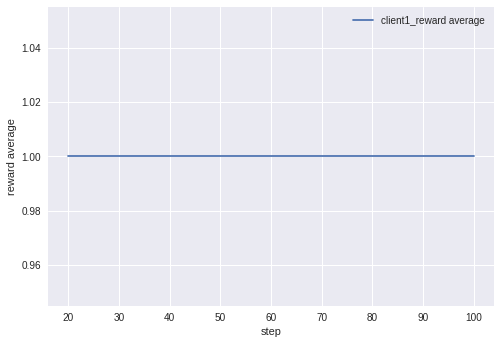

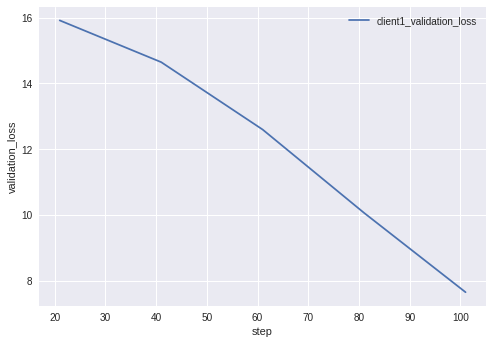

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-121
==== 121 ====
おはようございます。寒いですね。
    [0]ー。ます！ 
    [1]ー。ますを 
さて帰ろう。明日は早い。
    [0]ー。気を 
    [1]ー。ますを 
今回もよろしくです。
    [0]こちらこそよろしくお願いし 
    [1]こちらこそよろしくお願います 
avg_reply_len=8.3
validation loss=6.1
learning rate 0.05
msec/data=20.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-141
==== 141 ====
おはようございます。寒いですね。
    [0]おはようございます！  
    [1]おはようございます！ます 
さて帰ろう。明日は早い。
    [0]おはよう。気！ 
    [1]ー。気！ 
今回もよろしくです。
    [0]こちらこそよろしくお願いします  
    [1]こちらこそよろしくお願いしますます 
avg_reply_len=12.3
validation loss=4.7
learning rate 0.05
msec/data=16.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small/ChatbotModel-161
==== 161 ====
おはようございます。寒いですね。
    [0]おはようございます！ 
    [1]おはようございますを 
さて帰ろう。明日は早い。
    [0]ー。気をつけ  
    [1]ー。気をつけて 
今回もよろしくです。
    [0]こちらこそよろしくお願います 
    [1]こちらこそよろしくします 
avg_reply_

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-61
==== 61 ====
@higepon おはようございます！
    [0]今回も。。。。。。
    [1]今回も。。。。。 
おつかれさまー。気をつけて。
    [0]帰ろう。。。。。。
    [1]帰ろも。。。。。。
こちらこそよろしくお願いします。
    [0]帰ろう。。。。。。
    [1]帰ろも。。。。。。
avg_reply_len=9.0
validation loss=12.4
learning rate 0.05
msec/data=16.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-81
==== 81 ====
@higepon おはようございます！
    [0]ございます。。。。。 
    [1]ございも。。。。。 
おつかれさまー。気をつけて。
    [0]帰ろう。。。。。 
    [1]帰ろも。。。。。 
こちらこそよろしくお願いします。
    [0]帰ろも。。。。。 
    [1]今回も。。。。。 
avg_reply_len=9.7
validation loss=10.7
learning rate 0.05
msec/data=17.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-101
==== 101 ====
@higepon おはようございます！
    [0]ございます。。。。 
    [1]ございます。です。。 
おつかれさまー。気をつけて。
    [0]帰ろう。。。。 
    [1]帰ろも。。。。 
こちらこそよろしくお願いします。
    [0]今回も。。。  
    [1]今回も。

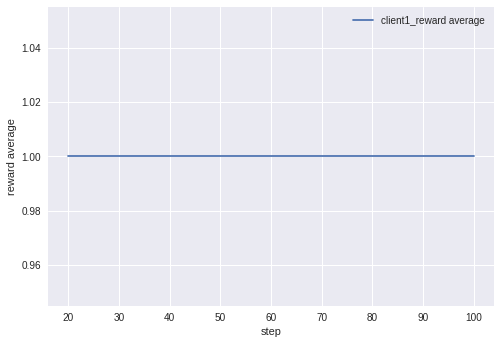

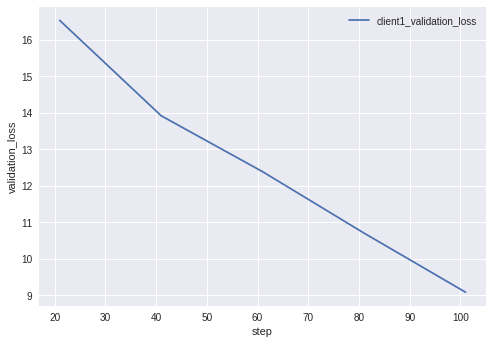

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-121
==== 121 ====
@higepon おはようございます！
    [0]ございます寒いですです 
    [1]ございますですですです 
おつかれさまー。気をつけて。
    [0]帰ろう。明日は 
    [1]帰ろう。はは 
こちらこそよろしくお願いします。
    [0]今回もよろしくです早い 
    [1]今回もよろしくですです 
avg_reply_len=10.7
validation loss=7.7
learning rate 0.05
msec/data=20.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-141
==== 141 ====
@higepon おはようございます！
    [0]ございます寒いですです 
    [1]ございますですですです 
おつかれさまー。気をつけて。
    [0]帰ろう。明日は早い 
    [1]帰ろう明日明日は早い 
こちらこそよろしくお願いします。
    [0]今回もよろしくですです 
    [1]今回もよろしくです早い 
avg_reply_len=11.3
validation loss=6.4
learning rate 0.05
msec/data=16.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_small_swapped/ChatbotModel-161
==== 161 ====
@higepon おはようございます！
    [0]ございます寒い寒いですねね 
    [1]ございます寒いですですねね 
おつかれさまー。気をつけて。
    [0]帰ろうよろしくですは早い 
    [1]帰ろう。

In [15]:
import MeCab


def clean_model_path(model_path):
    shutil.rmtree(model_path)
    os.makedirs(model_path)


def print_header(text):
    print("============== {} ==============".format(text))




def test_tweets_small_swapped(hparams):
  replies = ["@higepon おはようございます！", "おつかれさまー。気をつけて。", "こちらこそよろしくお願いします。"]
  trainer = Trainer()
  trainer.train_seq2seq_swapped(hparams, "tweets_small.txt", replies)

# vocab size 変えたら動かなくなった
tweet_small_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {
        'batch_size': 6,  # of tweets should be dividable by batch_size
        'encoder_length': 8,
        'decoder_length': 8,
        'num_units': 256,
        'num_layers': 2,
        'vocab_size': 34,
        'embedding_size': 40,
        'beam_width': 2,  # for faster iteration, this should be 10
        'num_train_steps': 200,
        'model_path': p(ModelDirectory.tweet_small.value),
        'learning_rate': 0.05,
        'use_attention': True,
    })

tweet_small_swapped_hparams = copy.deepcopy(
    tweet_small_hparams).override_from_dict(
    {'model_path': p(ModelDirectory.tweet_small_swapped.value)})

if mode == Mode.Test:
    tweets_path = "tweets_small.txt"
    TrainDataGenerator(tweets_path, tweet_small_hparams).remove_generated()
    trainer = Trainer()
    trainer.train_seq2seq(tweet_small_hparams, tweets_path,
                         ["おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。"])
    test_tweets_small_swapped(tweet_small_swapped_hparams)

In [0]:
def test_tweets_large(hparams):
  tweets = ["さて福岡行ってきます！", "誰か飲みに行こう", "熱でてるけど、でもなんか食べなきゃーと思ってアイス買おうとしたの","今日のドラマ面白そう！","お腹すいたー", "おやすみ～", "おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]
  trainer = Trainer()
  trainer.train_seq2seq(hparams, "tweets_conversation.txt", tweets, should_clean_saved_model=False, drive=drive)


def test_tweets_large_swapped(hparams):
  tweets = [ "今日のドラマ面白そう！","お腹すいたー", "おやすみ～", "おはようございます。寒いですね。", "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]
  trainer = Trainer()
  trainer.train_seq2seq_swapped(hparams, "tweets_large.txt", tweets, should_clean_saved_model=False, drive=drive)


tweet_large_hparams = copy.deepcopy(base_hparams).override_from_dict(
    {
        # In typical seq2seq chatbot
        # num_layers=3, learning_rate=0.5, batch_size=64, vocab=20000-100000, learning_rate decay is 0.99, which is taken care as default parameter in AdamOptimizer.
        'batch_size': 64,  # of tweets should be dividable by batch_size
        'encoder_length': 30,
        'decoder_length': 30,
        'num_units': 1024,
        'num_layers': 3,
        'vocab_size': 100000,
        'embedding_size': 1024,
        'beam_width': 2,  # for faster iteration, this should be 10
        'num_train_steps': 1000000,
        'model_folder_in_drive': GoogleDriveFolder.seq2seq.value,
        'model_path': p(ModelDirectory.tweet_large.value),
        'learning_rate': 0.5, # For vocab_size 50000, num_layers 3, num_units 1024, tweet_large, starting learning_rate 0.05 works well, change it t0 0.01 at perplexity 800, changed it to 0.005 at 200.
        'learning_rate_decay': 0.99,
        'use_attention': True,
        # testing new restore learning rate and no USERNAME TOKEN
    })

tweet_large_swapped_hparams = copy.deepcopy(
    tweet_large_hparams).override_from_dict(
    {
        'model_folder_in_drive': GoogleDriveFolder.seq2seq_swapped.value,
        'model_path': p(ModelDirectory.tweet_large_swapped.value)
    })

if mode == Mode.TrainSeq2Seq:
    print("train seq2seq")
    print(tweet_large_hparams)
    test_tweets_large(tweet_large_hparams)
elif mode == Mode.TrainSeq2SeqSwapped:
    print("train seq2seq swapped")
    test_tweets_large_swapped(tweet_large_swapped_hparams)

In [0]:
rl_src_hparams = copy.deepcopy(tweet_large_hparams).override_from_dict({'beam_width': 0})
rl_dst_hparams = copy.deepcopy(rl_src_hparams).override_from_dict({
    'learning_rate': 0.1,
    'beam_width': 0,
    'num_train_steps': 300000,
    'model_folder_in_drive': GoogleDriveFolder.seq2seq_rl.value,
    'model_path': p(ModelDirectory.tweet_large_rl.value),
})

tweets = ["さて福岡行ってきます！", "誰か飲みに行こう", "熱でてるけど、でもなんか食べなきゃーと思ってアイス買おうとしたの",
          "今日のドラマ面白そう！", "お腹すいたー", "おやすみ～", "おはようございます。寒いですね。",
          "さて帰ろう。明日は早い。", "今回もよろしくです。", "ばいとおわ！"]

if mode == Mode.TrainRL:
    train_large_rl(rl_src_hparams,
                   rl_dst_hparams,
                   source_path="tweets_large.txt",
                   tweets=tweets,
                   drive=drive)
    

In [0]:
def download_logs(path):
  for f in absoluteFilePaths(path):
    if re.match('.*events', f):
      files.download(f)
      
def remove_saved_model(hparams):
  !mkdir -p $hparams.model_path
  !rm $hparams.model_path/*  
  
def copy_saved_model(src_hparams, dst_hparams):
  !cp $src_hparams.model_path/* $dst_hparams.model_path/
  # rm tf.logs from source so that it wouldn't be mixed in dest tf.logs.
  !rm $dst_hparams.model_path/events*
  
  
# This is designed to have small clean RL iterations many times.
def easy_train_rl_tweets(seq2seq_hparams, rl_src_hparams, rl_dst_hparams, tweets_path, validation_tweets, dull_responses):
  
  TrainDataGenerator(tweets_path, seq2seq_hparams).remove_generated()
  
  # train normal seq2seq.
  remove_saved_model(seq2seq_hparams)
  trainer = Trainer()
  trainer.train_seq2seq(seq2seq_hparams, tweets_path, validation_tweets)
  
  # Copy trained seq2seq as initial state of rl model.
  remove_saved_model(rl_dst_hparams)
  copy_saved_model(seq2seq_hparams, rl_dst_hparams)

  trainer = Trainer()
  trainer.train_rl_tweets(rl_src_hparams,   rl_dst_hparams, tweets_path, validation_tweets, dull_responses)

In [0]:
tweet_small_hparams = copy.deepcopy(
    tweet_small_hparams).override_from_dict(
    {'num_train_steps': 120,
      'decoder_length': 10,
      'encoder_length': 10
    })

rl_src_hparams = copy.deepcopy(tweet_small_hparams).override_from_dict({'beam_width': 0})
rl_dst_hparams = copy.deepcopy(rl_src_hparams).override_from_dict({
    'learning_rate': 0.1,
    'beam_width': 0,
    'num_train_steps':1000,
    'model_folder_in_drive': GoogleDriveFolder.seq2seq_rl.value,
    'model_path': p(ModelDirectory.tweet_small_rl.value),
})

if mode == Mode.Test:  
  dull_responses = ['これ', "それ", "ありがとうございます", "おつかれ", "それなwww",
                            "おはよ(˙-˙)",
                            "おはよ！", "おはようございます！", "おつかれさまです"]
#  easy_train_rl_tweets(tweet_small_hparams,  rl_src_hparams, rl_dst_hparams, "tweets_small.txt", [ "おやすみ～", "おはようございます。寒いですね。", "今回もよろしくです。", "ばいとおわ！"], dull_responses)


In [0]:
if mode == Mode.Test:
  download_logs(ModelDirectory.tweet_small_rl.value)
  


rm: cannot remove 'model/tweet_large/*': No such file or directory
===== Train Seq2Seq tweets_medium.txt ====
{'machine': 'client1', 'batch_size': 64, 'num_units': 512, 'num_layers': 2, 'vocab_size': 5000, 'embedding_size': 256, 'learning_rate': 0.5, 'learning_rate_decay': 0.99, 'use_attention': True, 'encoder_length': 30, 'decoder_length': 30, 'max_gradient_norm': 5.0, 'beam_width': 2, 'num_train_steps': 6240, 'model_path': 'model/tweet_large'}
downloading tweets_medium.txt...
downloaded
generating enc and dec files...
generating vocab file...
loading vocab...
generating id files...
generating padded input file...
generating dec eos/sos files...
done
!!!GPU ENABLED !!!
!!!GPU ENABLED !!!
Created fresh model.
...................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-21
==== 21 ====
おやすみ～
    [0]  
    [1]て 
おはようございます。寒いですね。
    [0]  
    [1]て 
今回もよろしくです。
    [0]  
    [1]て 
ばいとおわ！
    [0]  
    [1]て 
avg_reply_len=2.0
validation los

    [0]ははたててててててててててててててててててててててててててて
    [1]ははたたてててててててててててててててててててててててててて
おはようございます。寒いですね。
    [0]はははたてててててててててててててててててててててててててて
    [1]はははたたててててててててててててててててててててててててて
今回もよろしくです。
    [0]はははたてててててててててててててててててててててててててて
    [1]ははたたてててててててててててててててててててててててててて
ばいとおわ！
    [0]ははたたてててててててててててててててててててててててててて
    [1]ははたててててててててててててててててててててててててててて
avg_reply_len=30.0
validation loss=112.5
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-81
==== 81 ====
おやすみ～
    [0]                              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]                              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]                              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]                              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=111.3
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:

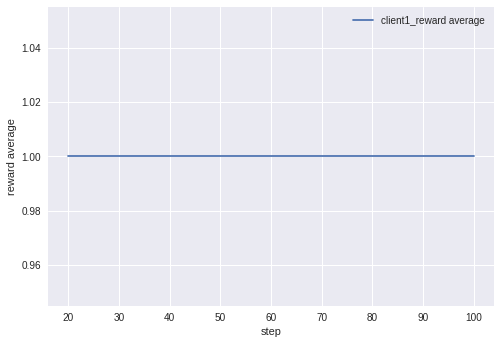

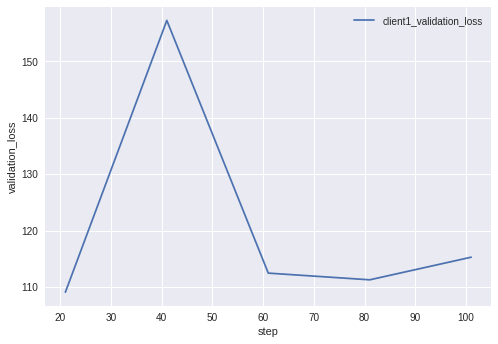

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-121
==== 121 ====
おやすみ～
    [0]  
    [1]て 
おはようございます。寒いですね。
    [0]はて 
    [1]てて 
今回もよろしくです。
    [0]て  
    [1]てて 
ばいとおわ！
    [0]て  
    [1]てて 
avg_reply_len=2.8
validation loss=111.7
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-141
==== 141 ====
おやすみ～
    [0]のののの  
    [1]ののののの 
おはようございます。寒いですね。
    [0]💩のののの  
    [1]💩ののののの 
今回もよろしくです。
    [0]💩のの   
    [1]💩のののの 
ばいとおわ！
    [0]💩の    
    [1]💩のののの 
avg_reply_len=6.2
validation loss=108.1
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-161
==== 161 ====
おやすみ～
    [0]        
    [1]💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩          
    [1]💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]          
    [1]💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]          
    [1]💩💩💩💩💩💩💩💩💩 
avg_

INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-201
==== 201 ====
おやすみ～
    [0]！   
    [1]！！！ 
おはようございます。寒いですね。
    [0]！！！  
    [1]！！！！ 
今回もよろしくです。
    [0]！！   
    [1]！！！！ 
ばいとおわ！
    [0]！   
    [1]！！！ 
avg_reply_len=4.5
validation loss=107.9
learning rate 0.5
msec/data=6.2


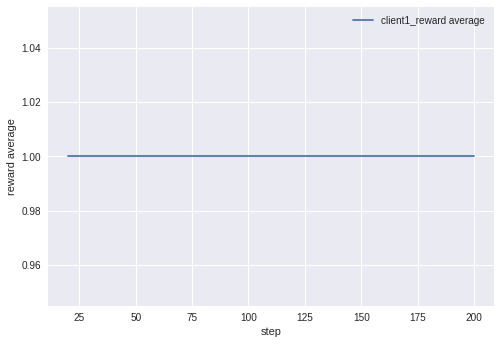

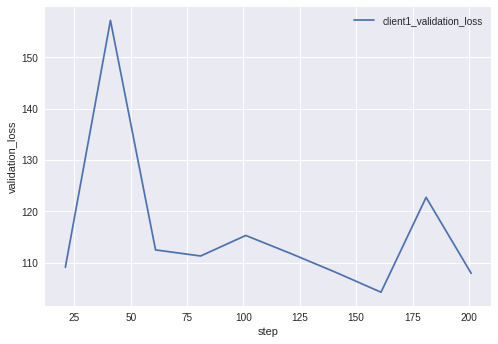

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-221
==== 221 ====
おやすみ～
    [0]のwwwwwwwww  
    [1]のwwwwwwwwwwww 
おはようございます。寒いですね。
    [0]結果はwwwwwwwwwwww  
    [1]結果はwwwwwwwwwwwwwww 
今回もよろしくです。
    [0]結果のwwwwwwwwwwww 
    [1]結果はwwwwwwwwwwww 
ばいとおわ！
    [0]結果wwwwwwwwwwww  
    [1]結果wwwwwwwwwwwwwww 
avg_reply_len=15.2
validation loss=96.2
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-241
==== 241 ====
おやすみ～
    [0]      
    [1]💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩       
    [1]💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩       
    [1]💩💩💩💩💩💩💩 
ばいとおわ！
    [0]        
    [1]💩💩💩💩💩💩💩 
avg_reply_len=7.8
validation loss=98.1
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-261
==== 261 ====
おやすみ～
    [0]💩💩💩💩💩💩！！！！！！！！！！！！！！！！！！！！！！！！
    [1]💩💩💩💩💩💩！！！！！！！！！！！！！

...........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-301
==== 301 ====
おやすみ～
    [0]  
    [1]💩 
おはようございます。寒いですね。
    [0]💩  
    [1]💩💩 
今回もよろしくです。
    [0]  
    [1]💩 
ばいとおわ！
    [0]  
    [1]💩 
avg_reply_len=2.2
validation loss=104.6
learning rate 0.5
msec/data=6.1


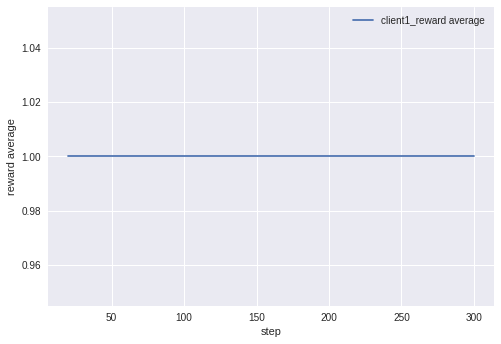

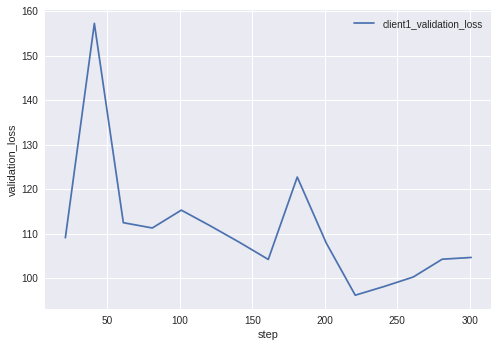

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-321
==== 321 ====
おやすみ～
    [0]💩       
    [1]💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩         
    [1]💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩       
    [1]💩💩💩💩💩💩💩💩 
avg_reply_len=10.2
validation loss=93.4
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-341
==== 341 ====
おやすみ～
    [0]💩                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩                          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩                          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=27.5
validation loss=86.8
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/

............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-401
==== 401 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩                          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=94.1
learning rate 0.5
msec/data=7.2


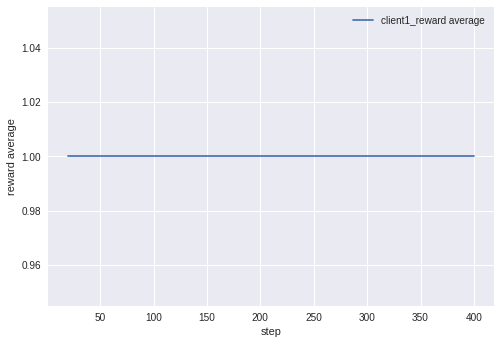

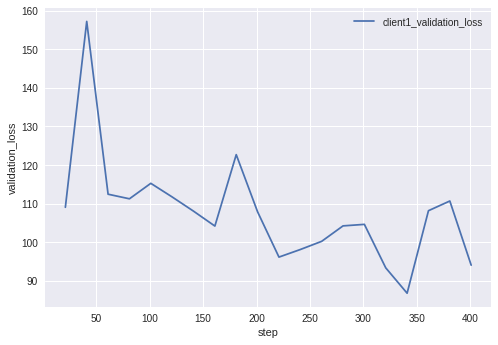

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-421
==== 421 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩。💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩。💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩。💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩。💩💩💩💩
avg_reply_len=30.0
validation loss=97.3
learning rate 0.5
msec/data=7.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-441
==== 441 ====
おやすみ～
    [0]の 
    [1]て 
おはようございます。寒いですね。
    [0]え 
    [1]これ 
今回もよろしくです。
    [0]え 
    [1]これ 
ばいとおわ！
    [0]これ  
    [1]これ！ 
avg_reply_len=2.5
validation loss=84.0
learning rate 0.5
msec/data=6.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-461
==== 461 ===

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-501
==== 501 ====
おやすみ～
    [0]💩💩  
    [1]💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩  
    [1]💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩  
    [1]💩💩💩www 
ばいとおわ！
    [0]💩💩💩  
    [1]💩💩💩💩 
avg_reply_len=4.8
validation loss=90.2
learning rate 0.5
msec/data=6.2


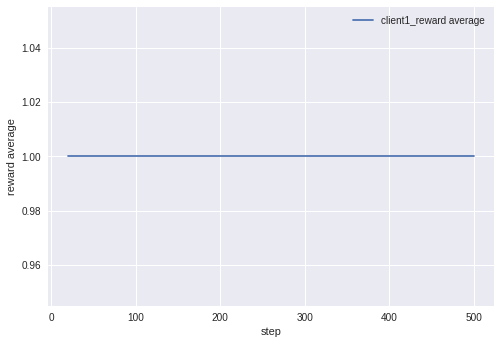

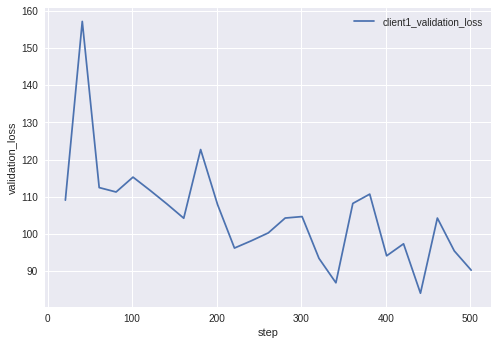

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-521
==== 521 ====
おやすみ～
    [0]て 
    [1]は 
おはようございます。寒いですね。
    [0]え 
    [1]いや 
今回もよろしくです。
    [0]いやて 
    [1]えて 
ばいとおわ！
    [0]いやて 
    [1]えて 
avg_reply_len=3.0
validation loss=100.5
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-541
==== 541 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩www💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩www💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩www💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩て
avg_reply_len=30.0
validation loss=95.0
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-561
====

.................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-601
==== 601 ====
おやすみ～
    [0]の  
    [1]のの 
おはようございます。寒いですね。
    [0]これの 
    [1]えの 
今回もよろしくです。
    [0]これの 
    [1]えの 
ばいとおわ！
    [0]これの 
    [1]えの 
avg_reply_len=3.8
validation loss=84.3
learning rate 0.5
msec/data=6.2


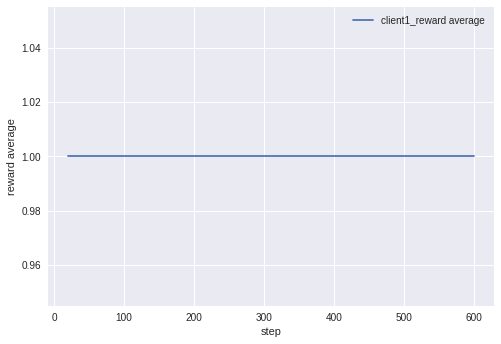

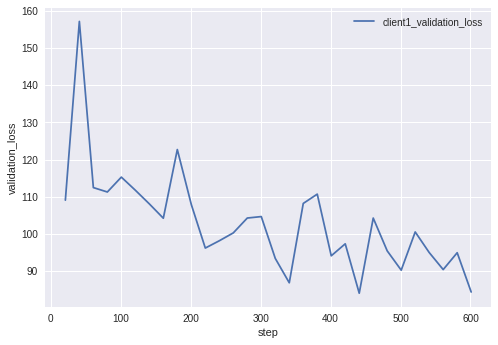

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-621
==== 621 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩    
    [1]💩💩💩💩 
今回もよろしくです。
    [0]💩💩  
    [1]💩💩💩 
ばいとおわ！
    [0]💩💩  
    [1]💩💩💩 
avg_reply_len=4.0
validation loss=81.0
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-641
==== 641 ====
おやすみ～
    [0]💩💩💩💩💩www)💩💩💩💩💩))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩www)www💩💩💩💩))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩www💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩www💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.5
validation loss=102.2
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotM

.......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-701
==== 701 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩   
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩(˙))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
    [1]💩💩💩(˙))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩(˙))(💩))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
    [1]💩💩(˙))(💩))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩(˙))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩  
    [1]💩💩💩(˙))💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=27.8
validation loss=83.8
learning rate 0.5
msec/data=7.1


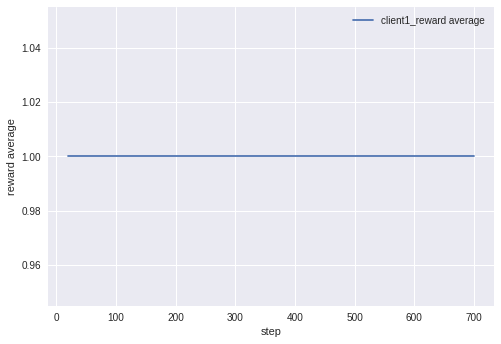

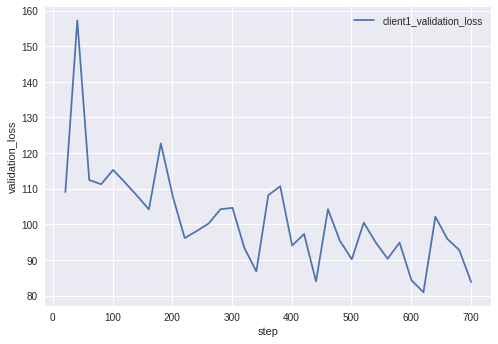

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-721
==== 721 ====
おやすみ～
    [0]💩www                            
    [1]💩wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
おはようございます。寒いですね。
    [0]いやwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
    [1]これwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
今回もよろしくです。
    [0]これwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
    [1]これwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww！
ばいとおわ！
    [0]これwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
    [1]これwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww！
avg_reply_len=74.8
validation loss=96.0
learning rate 0.5
msec/data=7.5
..................reward average=1.0
.INFO:t

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-781
==== 781 ====
おやすみ～
    [0]💩  
    [1]💩www 
おはようございます。寒いですね。
    [0]💩💩  
    [1]💩💩www 
今回もよろしくです。
    [0]💩💩  
    [1]💩💩www 
ばいとおわ！
    [0]💩のwww 
    [1]💩、www 
avg_reply_len=4.2
validation loss=71.2
learning rate 0.5
msec/data=6.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-801
==== 801 ====
おやすみ～
    [0]、のwww 
    [1]、、www 
おはようございます。寒いですね。
    [0]これははににのててててててててててててててててて)  
    [1]これははににのててててててててててててててててて)) 
今回もよろしくです。
    [0]これ、にのてのててててててててのててのてててててて  
    [1]これ、にのてのててててててててのててのててててててて 
ばいとおわ！
    [0]これ、！ 
    [1]これの！ 
avg_reply_len=16.2
validation loss=91.4
learning rate 0.5
msec/data=6.6


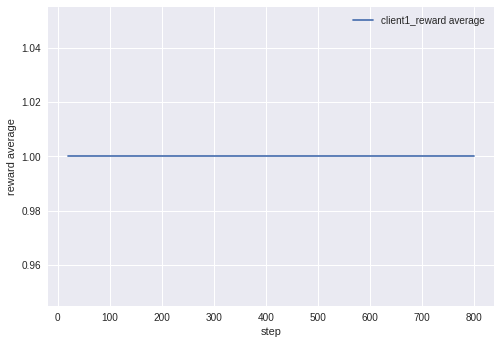

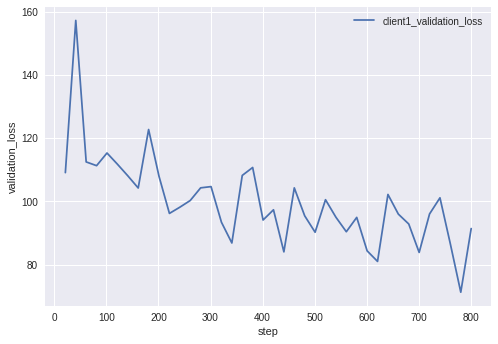

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-821
==== 821 ====
おやすみ～
    [0]、のwww  
    [1]、のwwwた 
おはようございます。寒いですね。
    [0](˘)   
    [1](˘ω˙) 
今回もよろしくです。
    [0]これのののてて) 
    [1]これのののててて 
ばいとおわ！
    [0]これのののてて) 
    [1]これのののててて 
avg_reply_len=7.8
validation loss=101.7
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-841
==== 841 ====
おやすみ～
    [0]💩                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩   
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=26.5
validation loss=97.7
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-861

........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-901
==== 901 ====
おやすみ～
    [0]💩www 
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩www                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩た                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩www                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=21.8
validation loss=91.7
learning rate 0.5
msec/data=6.7


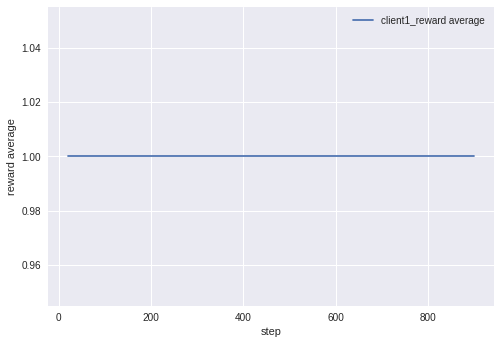

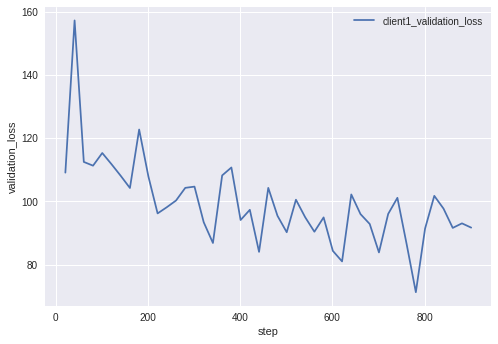

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-921
==== 921 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0](💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1](💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)
今回もよろしくです。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=88.4
learning rate 0.5
msec/data=7.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-941
==== 941 ====
おやすみ～
    [0]💩💩                    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩た                     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩た                    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩                     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=23.0
validation loss=8

    [0]💩💩💩💩💩💩💩www                      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=28.8
validation loss=91.3
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1001
==== 1001 ====
おやすみ～
    [0]あ                          
    [1]あ、！！！！？？？？？？？？？？？？？？？？？？？？ 
おはようございます。寒いですね。
    [0]それは？                           
    [1]それは？？？？？？？？？？？？？？？？？？？？？？？？？？？？
今回もよろしくです。
    [0]あ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    [1]あ！！！！！！！！！！！！！！！！！！！！！！！！！！！！？
ばいとおわ！
    [0]あ！                           
    [1]あ！！！！！！！！！！！！！？？？？？？？？？？？？？？ 
avg_reply_len=29.2
validation loss=89.5
learning rate 0.5
msec/data=7.1


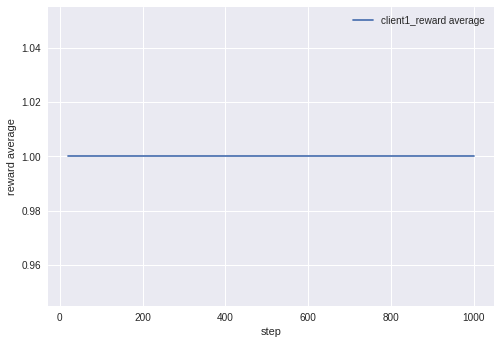

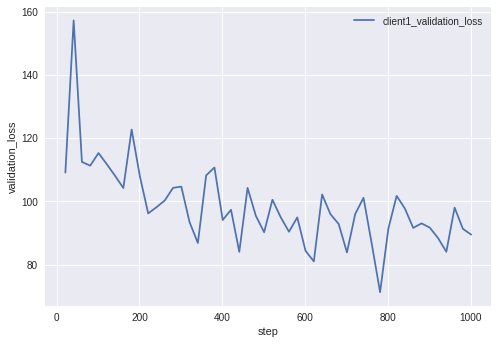

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1021
==== 1021 ====
おやすみ～
    [0]これ   
    [1]これの💩 
おはようございます。寒いですね。
    [0]これの💩💩💩  
    [1]これの💩💩💩💩 
今回もよろしくです。
    [0]これの💩  
    [1]これの💩💩 
ばいとおわ！
    [0]これの💩  
    [1]これの💩💩 
avg_reply_len=6.2
validation loss=92.6
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1041
==== 1041 ====
おやすみ～
    [0]いやwww 
    [1]これwww 
おはようございます。寒いですね。
    [0]えwww 
    [1]それwww 
今回もよろしくです。
    [0]！                           
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！ 
ばいとおわ！
    [0]え  
    [1]えwww 
avg_reply_len=10.5
validation loss=88.3
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1061
==== 1061 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩

.........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1101
==== 1101 ====
おやすみ～
    [0]💩www  
    [1]💩たwww 
おはようございます。寒いですね。
    [0](^ω˙) 
    [1](^ω˘) 
今回もよろしくです。
    [0]！！！！！！！！                      
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]！！！                           
    [1]！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=18.0
validation loss=82.3
learning rate 0.5
msec/data=6.6


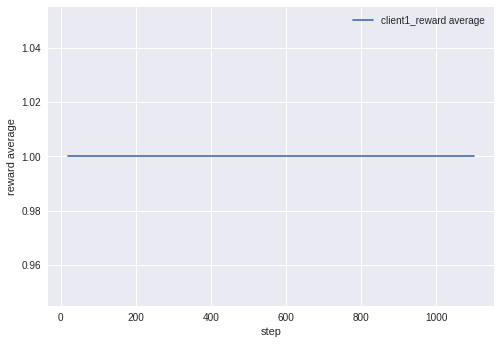

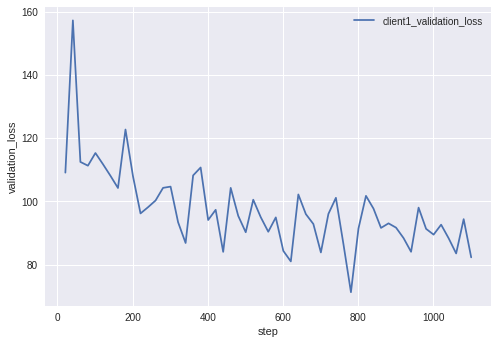

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1121
==== 1121 ====
おやすみ～
    [0]あwww                          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0](˘ω˙) 
    [1](˘ω˘) 
今回もよろしくです。
    [0]💩💩💩💩💩                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩                          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=23.5
validation loss=69.3
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1141
==== 1141 ====
おやすみ～
    [0]💩www                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩www                      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩www                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩www                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=32.0
val

..............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1201
==== 1201 ====
おやすみ～
    [0]これー  
    [1]これてます 
おはようございます。寒いですね。
    [0]💩💩てないwww     
    [1]💩💩てない(˙-˙) 
今回もよろしくです。
    [0]                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]    
    [1]💩💩💩 
avg_reply_len=9.5
validation loss=73.3
learning rate 0.5
msec/data=6.4


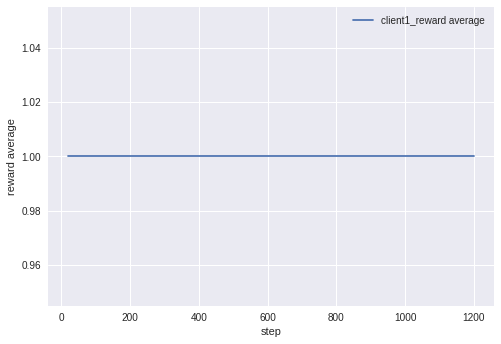

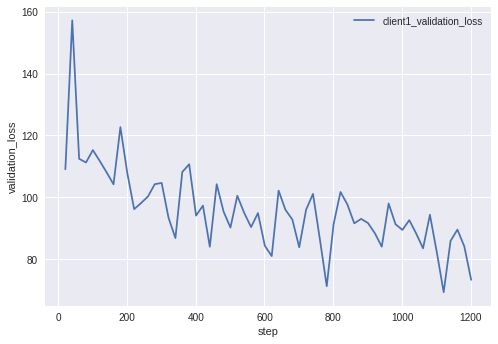

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1221
==== 1221 ====
おやすみ～
    [0]これwww  
    [1]これwwwwww 
おはようございます。寒いですね。
    [0]💩www                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩                 
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩             
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=24.8
validation loss=67.5
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1241
==== 1241 ====
おやすみ～
    [0]えwww                            
    [1]え！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]えwww                            
    [1]え！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
今回もよろしくです。
    [0]え！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    [1]待った！！！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]え！                            
    [1]え！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len

.................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1301
==== 1301 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩                     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩         
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=76.3
learning rate 0.5
msec/data=7.1


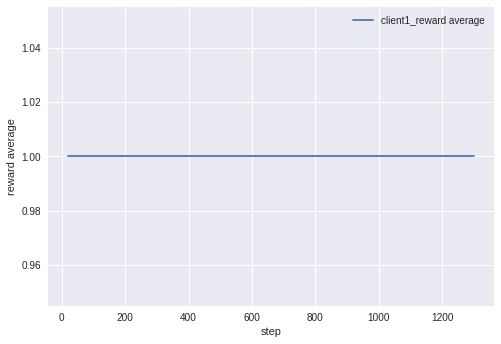

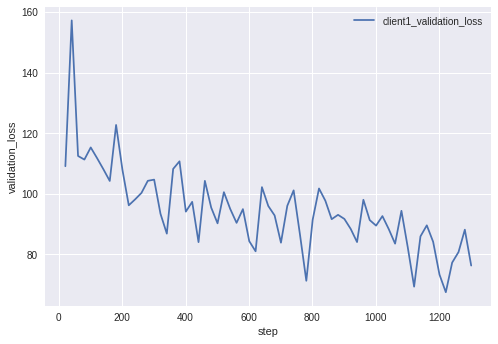

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1321
==== 1321 ====
おやすみ～
    [0]これ 
    [1]いや 
おはようございます。寒いですね。
    [0]そうよ(˙-˙) 
    [1]そうよ(˙ω^) 
今回もよろしくです。
    [0]そうよ(^ω^) 
    [1]そうか(^ω^) 
ばいとおわ！
    [0]これ   
    [1]これの💩 
avg_reply_len=6.5
validation loss=84.7
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1341
==== 1341 ====
おやすみ～
    [0]これたwww                           
    [1]これー！！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]💩💩💩💩💩www                        
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩💩💩💩                         
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩                  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=31.2
validation loss=88.0
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/t

.............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1401
==== 1401 ====
おやすみ～
    [0]💩  
    [1]💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩    
    [1]💩💩💩💩 
ばいとおわ！
    [0]💩💩  
    [1]💩💩💩 
avg_reply_len=5.5
validation loss=80.8
learning rate 0.5
msec/data=6.2


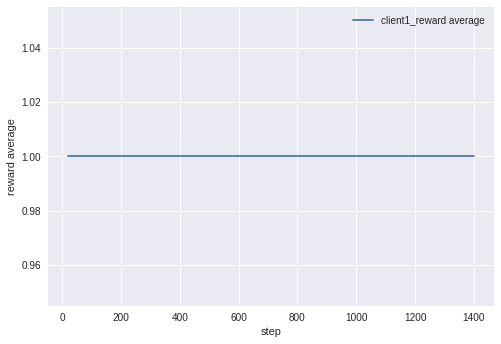

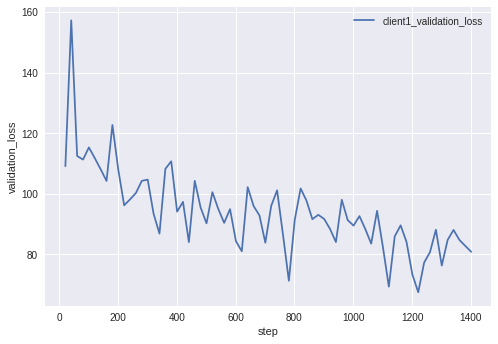

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1421
==== 1421 ====
おやすみ～
    [0]💩                             
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]それwww  
    [1]それなwww 
今回もよろしくです。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=24.2
validation loss=79.7
learning rate 0.5
msec/data=7.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1441
==== 1441 ====
おやすみ～
    [0]これの！！                          
    [1]これの！！！！！！！！！！！！！！！！！！！！！！！！！？？？
おはようございます。寒いですね。
    [0]え！！！！！！！！！！！！！！！！！！！！！！！！！！？？？
    [1]え！！！！！！！！！！！！！！！！！！！！！！！！！！！？？
今回もよろしくです。
    [0]💩💩💩💩                       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩の💩の💩の💩の💩の💩の💩の💩の💩の💩の💩の💩💩  
    [1]💩の💩の💩の💩の💩の💩の💩の💩の💩の💩の💩の💩💩💩 
avg_reply_len=28.5
validation loss

...............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1501
==== 1501 ====
おやすみ～
    [0]いや！                            
    [1]いや！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]そうなwww                           
    [1]そう！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
今回もよろしくです。
    [0]これ！                            
    [1]これ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]これ！                            
    [1]これ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=31.5
validation loss=83.3
learning rate 0.5
msec/data=7.1


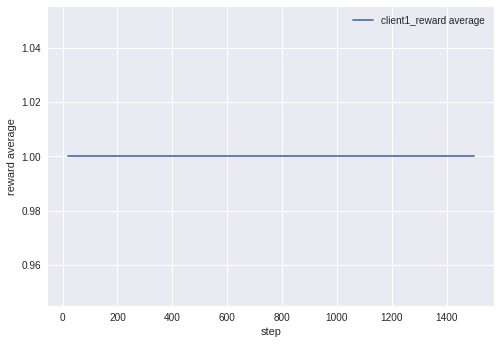

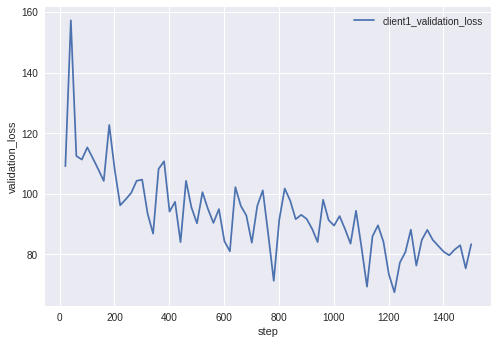

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1521
==== 1521 ====
おやすみ～
    [0]💩の💩の💩の💩💩💩💩💩💩💩💩💩💩   
    [1]💩の💩の💩の💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩ないんよwww  
    [1]💩ないんんんwww 
今回もよろしくです。
    [0]💩💩💩💩💩💩          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=15.2
validation loss=75.6
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1541
==== 1541 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩      
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩)       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=94.3
learning rate 0.5
msec/data=7.2
..................rewa

ばいとおわ！
    [0]💩💩💩💩                          
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.5
validation loss=87.8
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1601
==== 1601 ====
おやすみ～
    [0]💩   
    [1]💩の💩 
おはようございます。寒いですね。
    [0]💩…       
    [1]💩ないな(˙-˙) 
今回もよろしくです。
    [0]💩  
    [1]💩💩 
ばいとおわ！
    [0]💩  
    [1]💩💩 
avg_reply_len=4.8
validation loss=81.7
learning rate 0.5
msec/data=6.2


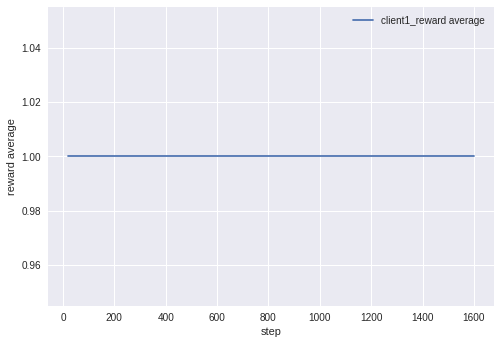

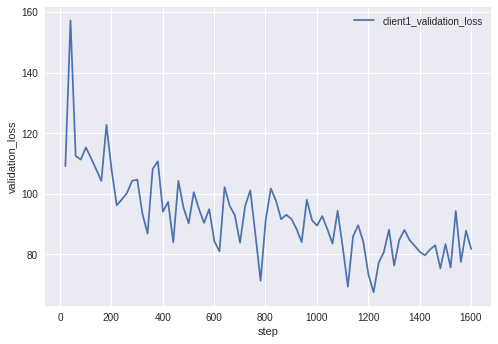

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1621
==== 1621 ====
おやすみ～
    [0]いやー                         
    [1]いや、、、、、、、、、、、、、、、、、、、、、、、、、 
おはようございます。寒いですね。
    [0](˙-˙) 
    [1](💩)   
今回もよろしくです。
    [0]え！                          
    [1]え、、、、、、、、、、、、、、、、、、、、、、、、、、 
ばいとおわ！
    [0]💩、  
    [1]💩、💩 
avg_reply_len=16.5
validation loss=80.9
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1641
==== 1641 ====
おやすみ～
    [0]ありがとうございますwww                          
    [1]ありがとうございます！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]それだwww  
    [1]それだよwww 
今回もよろしくです。
    [0]ありがとうございますwww                          
    [1]ありがとうございます！！！！！！！！！！！！！！！！！！！！！！！！！！ 
ばいとおわ！
    [0]ありがとうございますwww                          
    [1]ありがとうございます！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=31.2
validation loss=82.8
learning rate 0.5
msec/data=6.9
........

...............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1701
==== 1701 ====
おやすみ～
    [0]遅くー！                           
    [1]遅くー！！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩)                  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.2
validation loss=71.2
learning rate 0.5
msec/data=7.1


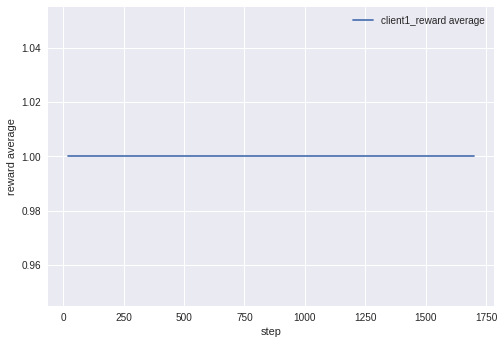

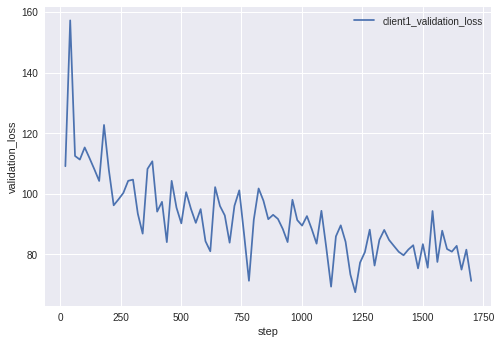

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1721
==== 1721 ====
おやすみ～
    [0]💩                 
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩               
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩               
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩                
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=18.0
validation loss=76.8
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1741
==== 1741 ====
おやすみ～
    [0]💩💩💩💩💩💩💩                       
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩💩💩              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩               
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=21.2
validation loss=74.4
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parame

...............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1801
==== 1801 ====
おやすみ～
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩💩💩                           
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.0
validation loss=67.7
learning rate 0.5
msec/data=7.0


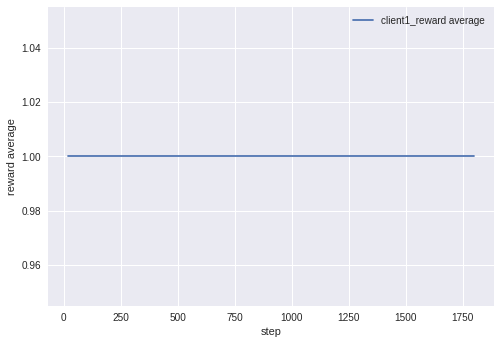

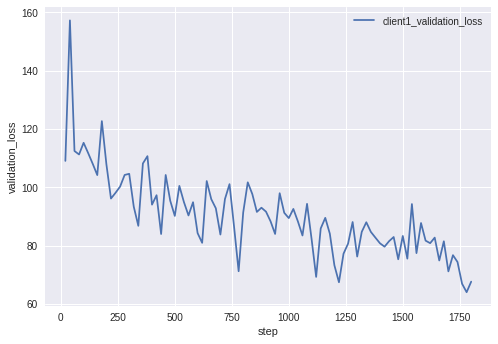

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1821
==== 1821 ====
おやすみ～
    [0]いや、💩                           
    [1]いや、💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0]💩(˙-˙)  
    [1]💩(˙-˙)💩 
今回もよろしくです。
    [0]💩💩  
    [1]💩💩💩 
ばいとおわ！
    [0]💩💩  
    [1]💩💩💩 
avg_reply_len=11.8
validation loss=65.3
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1841
==== 1841 ====
おやすみ～
    [0]💩💩💩💩💩               
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩(˙-˙)  
    [1]💩(˙-˙)💩 
今回もよろしくです。
    [0]💩💩💩               
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=16.2
validation loss=74.1
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1861
==== 1861 ====
おやすみ～
    [0]いや、、、、、、、、、、、、、、

..........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1901
==== 1901 ====
おやすみ～
    [0]💩💩                  
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩              
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=19.0
validation loss=66.4
learning rate 0.5
msec/data=6.7


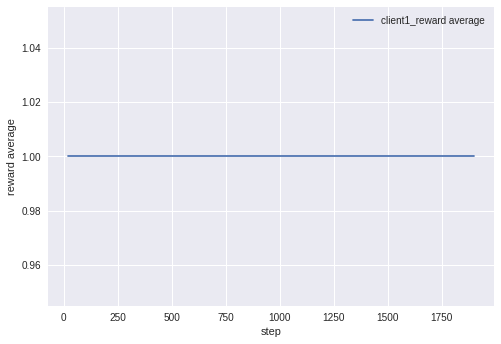

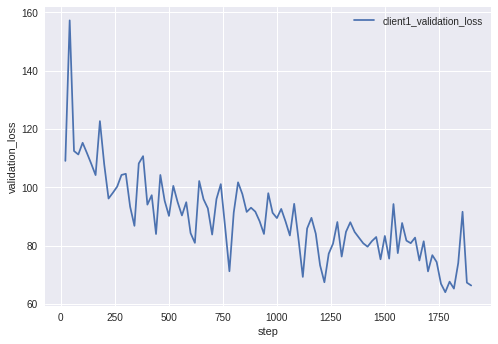

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1921
==== 1921 ====
おやすみ～
    [0]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、これ
おはようございます。寒いですね。
    [0]そうだんだよwww  
    [1]そうだんだよねwww 
今回もよろしくです。
    [0]💩💩  
    [1]💩💩💩 
ばいとおわ！
    [0]、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]、、、、、、、、、、、、、、、、、、、、、、、、、、、、、これ
avg_reply_len=19.0
validation loss=72.2
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-1941
==== 1941 ====
おやすみ～
    [0]いやwww   
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]それなwww   
    [1]それだよねwww 
今回もよろしくです。
    [0]ありがとうございますwww                          
    [1]ありがとうございます！！！！！！！！！！！！！！！！！！！！！！！！！！ 
ばいとおわ！
    [0]💩www                     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=20.2
validation loss=65.0
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring paramete

..........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2001
==== 2001 ====
おやすみ～
    [0]💩💩   
    [1]💩の💩www 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩                     
    [1]💩…………………………………………………………………… 
今回もよろしくです。
    [0]💩💩💩  
    [1]💩💩💩💩 
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=10.2
validation loss=66.9
learning rate 0.5
msec/data=6.4


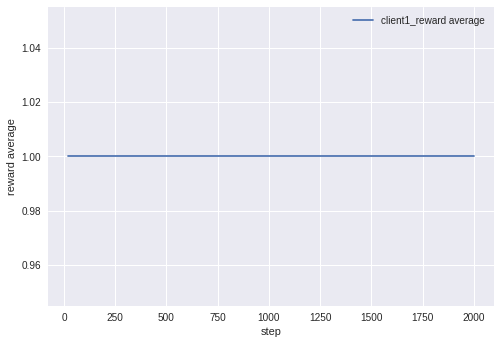

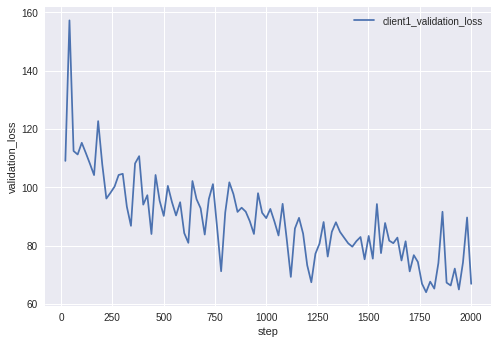

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2021
==== 2021 ====
おやすみ～
    [0]いや、💩www                          
    [1]いや、💩のは、、、、、、、、、、、、、、、、、、、、、、、、、
おはようございます。寒いですね。
    [0]💩にないなwww     
    [1]💩にないなのは……… 
今回もよろしくです。
    [0]💩にしてないwww 
    [1]💩にしてますwww 
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=14.8
validation loss=67.6
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2041
==== 2041 ====
おやすみ～
    [0]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、💩
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩                
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
今回もよろしくです。
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=30.2
validation loss=91.2
learning rate 0.5
msec/data=7.0
..................reward ave

............reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2101
==== 2101 ====
おやすみ～
    [0]俺の💩の💩は💩に💩てたんだよ！               
    [1]俺の💩の💩は💩に💩てたんだよ！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0](˙-˙)  
    [1]💩(˙-˙) 
今回もよろしくです。
    [0]💩www              
    [1]💩の💩の💩の💩になるんな(¨̮) 
ばいとおわ！
    [0]💩www 
    [1]💩！ 
avg_reply_len=15.0
validation loss=71.7
learning rate 0.5
msec/data=6.5


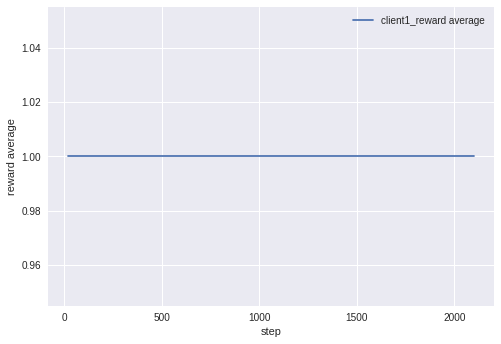

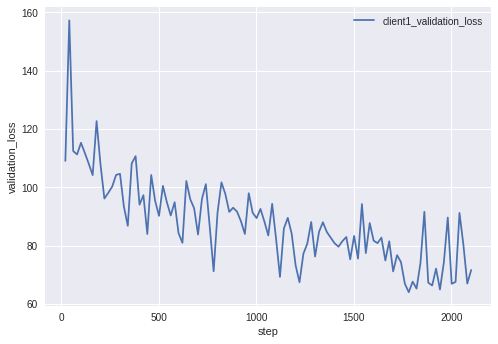

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2121
==== 2121 ====
おやすみ～
    [0]💩の💩の💩で💩てないんですねwww 
    [1]💩の💩の💩で💩てないんですwww  
おはようございます。寒いですね。
    [0]💩💩💩💩💩ﾟﾟﾟﾟﾟ)                   
    [1]💩💩💩💩💩ﾟﾟﾟﾟﾟﾟﾟﾟ)💩ﾟﾟ💩ﾟ)💩ﾟﾟﾟﾟﾟﾟﾟ) 
今回もよろしくです。
    [0]💩の💩で💩てますwww   
    [1]💩の💩の💩で💩てますwww 
ばいとおわ！
    [0]💩、💩の💩で💩てますwww   
    [1]💩、💩の💩の💩が💩てますwww 
avg_reply_len=19.5
validation loss=79.5
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2141
==== 2141 ====
おやすみ～
    [0]いや、💩💩www  
    [1]いや、💩の💩www 
おはようございます。寒いですね。
    [0]💩…         
    [1]💩んだよね(˙-˙) 
今回もよろしくです。
    [0]💩💩💩💩💩  
    [1]💩💩💩💩💩💩 
ばいとおわ！
    [0]💩の💩www  
    [1]💩の💩💩💩 
avg_reply_len=9.0
validation loss=66.6
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2161
==== 2161 ====
おやすみ～
    [0]💩💩  
    [1]💩💩💩

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2201
==== 2201 ====
おやすみ～
    [0]いや、💩💩の💩💩  
    [1]いや、💩💩の💩💩💩 
おはようございます。寒いですね。
    [0]💩💩💩💩💩💩    
    [1]💩💩💩💩💩💩💩💩) 
今回もよろしくです。
    [0]💩💩💩  
    [1]💩💩💩💩 
ばいとおわ！
    [0]💩💩💩  
    [1]💩💩💩💩 
avg_reply_len=7.5
validation loss=72.9
learning rate 0.5
msec/data=6.3


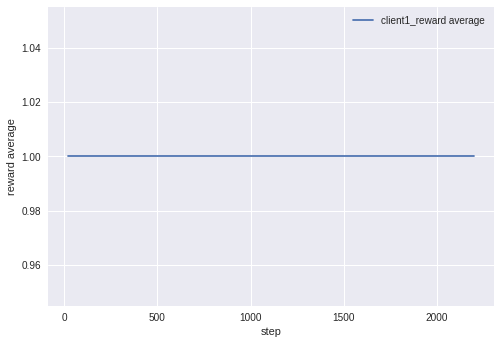

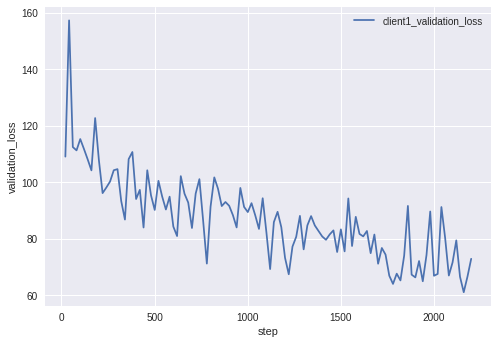

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2221
==== 2221 ====
おやすみ～
    [0]💩💩 
    [1]💩ー 
おはようございます。寒いですね。
    [0]💩に💩に💩たwww                    
    [1]💩に💩に💩たのだけど、💩˙-˙˙˙˙˙˙˙˙˙˙˙˙) 
今回もよろしくです。
    [0]💩💩  
    [1]💩💩💩 
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=9.8
validation loss=80.6
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2241
==== 2241 ====
おやすみ～
    [0]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
    [1]いや、、、、、、、、、、、、、、、、、、、、、、、、、、、、は
おはようございます。寒いですね。
    [0]💩💩ﾟﾟﾟﾟﾟﾟﾟ⌒www           
    [1]💩💩ﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟﾟ｡ 
今回もよろしくです。
    [0]💩の💩した。 
    [1]💩の💩してます 
ばいとおわ！
    [0]💩！                            
    [1]お、、、、、、、、、、、、、、、、、、、、、、、、、、、、、
avg_reply_len=23.0
validation loss=79.3
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2261
==== 2261

........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2301
==== 2301 ====
おやすみ～
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩️💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
おはようございます。寒いですね。
    [0](˙-˙)     
    [1](˙-˙)˙-˙) 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩の💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩️💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=25.0
validation loss=66.0
learning rate 0.5
msec/data=7.0


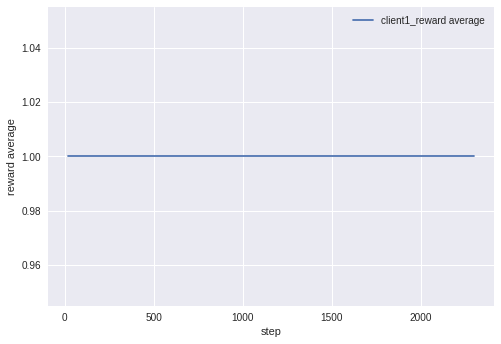

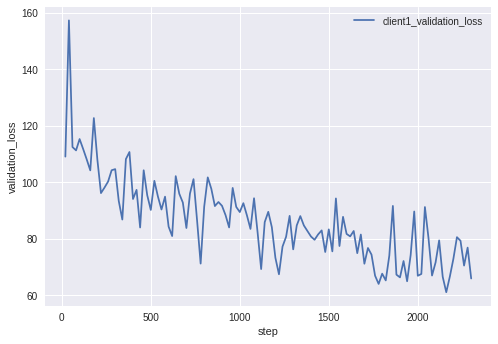

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2321
==== 2321 ====
おやすみ～
    [0]それは💩www 
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]んかなwww     
    [1]んかな(˙-˙) 
今回もよろしくです。
    [0]💩！                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩！                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=19.8
validation loss=64.4
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2341
==== 2341 ====
おやすみ～
    [0]それ💩   
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]💩ω💩ﾟω˘)  
    [1]💩ω💩ﾟω💩˘) 
今回もよろしくです。
    [0]💩ですね！    
    [1]💩ですね(¨̮) 
ばいとおわ！
    [0]💩💩        
    [1]💩さんに💩にしたから… 
avg_reply_len=8.5
validation loss=76.0
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2361
==== 2361 ====
おやすみ～
    [0]💩さん   
    [1

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2401
==== 2401 ====
おやすみ～
    [0].💩の💩💩💩💩💩.......』』牛してたから💩を💩てた💩💩💩
    [1].💩の💩💩💩💩💩.......』』牛してたから💩を💩てたから💩💩
おはようございます。寒いですね。
    [0](˙-˙)  
    [1]💩(˙-˙) 
今回もよろしくです。
    [0]お、、、、、、、、、2222💩だから(¨°͜ʖ͡°) 
    [1]お、、、、、、、、、2222💩だから(¨̮)    
ばいとおわ！
    [0]お、、、、、、、、222⁰•』) 
    [1]お、、、、、、、、222⁰°)  
avg_reply_len=20.5
validation loss=68.3
learning rate 0.5
msec/data=6.8


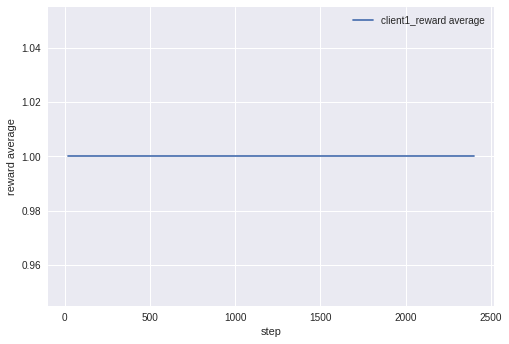

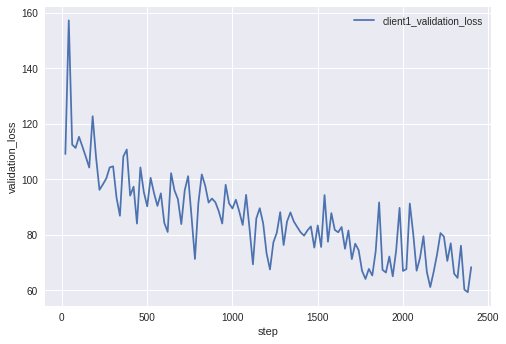

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2421
==== 2421 ====
おやすみ～
    [0]それだよwww                          
    [1]それだよ！！！！！！！！！！！！！！！！！！！！！！！！！！！
おはようございます。寒いですね。
    [0](˙-˙) 
    [1](˘ω˘) 
今回もよろしくです。
    [0]💩💩                            
    [1]💩の💩の💩の💩の💩の💩の💩の💩の💩の💩の💩が💩が💩が💩が💩が
ばいとおわ！
    [0]💩！                            
    [1]💩！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
avg_reply_len=24.8
validation loss=61.7
learning rate 0.5
msec/data=7.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2441
==== 2441 ====
おやすみ～
    [0]かわいすぎwww  
    [1]かわいすぎたwww 
おはようございます。寒いですね。
    [0]んですwww  
    [1]んですねwww 
今回もよろしくです。
    [0]そうです！  
    [1]そうですねwww 
ばいとおわ！
    [0]💩〜  
    [1]💩︎💩 
avg_reply_len=7.2
validation loss=80.7
learning rate 0.5
msec/data=6.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2461
==== 2461 ===

........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2501
==== 2501 ====
おやすみ～
    [0]それ💩   
    [1]それ、💩www 
おはようございます。寒いですね。
    [0](˙-˙)                         
    [1](˙-˙)(˙-˙)(˙-˙˙˙˙˙˙˙˙˙˙˙˙˙˙˙˙˙˙˙
今回もよろしくです。
    [0]💩💩💩💩 
    [1]あ、💩💩 
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=11.0
validation loss=74.3
learning rate 0.5
msec/data=6.4


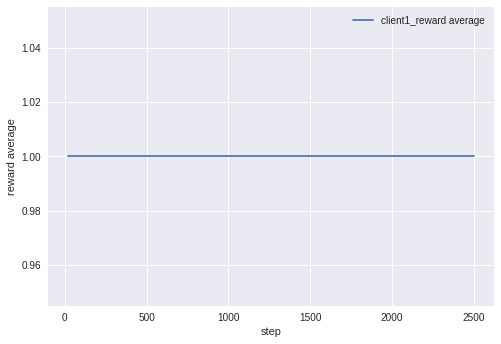

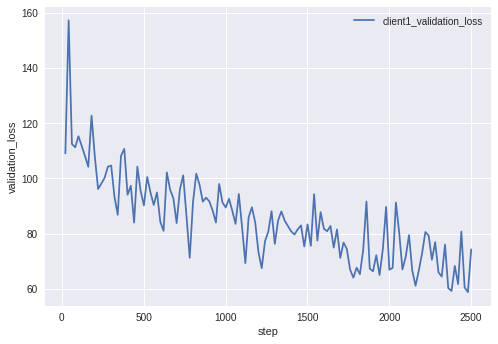

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2521
==== 2521 ====
おやすみ～
    [0]いや、💩www  
    [1]いや、💩とかwww 
おはようございます。寒いですね。
    [0]💩(˙-˙)            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩) 
今回もよろしくです。
    [0]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩） 
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩💩💩💩💩💩💩💩💩💩💩）     
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=15.5
validation loss=67.4
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2541
==== 2541 ====
おやすみ～
    [0]いや、   
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]💩(˙-˙)                        
    [1]💩(˙-˙)(˙-˙)˙-˙)˙-˙)、、、、、、、、、、、、
今回もよろしくです。
    [0]💩！  
    [1]💩💩💩 
ばいとおわ！
    [0]💩！ 
    [1]💩💩 
avg_reply_len=10.8
validation loss=66.0
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2561
==== 2561 ====
おやすみ～
    [0]それ、💩www 
    [1]いや、💩www 
お

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2601
==== 2601 ====
おやすみ～
    [0]いや・・・www 
    [1]いや・・・  
おはようございます。寒いですね。
    [0](˙-˙) 
    [1](˙˙˙) 
今回もよろしくです。
    [0]💩💩       
    [1]💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩💩                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=13.5
validation loss=64.7
learning rate 0.5
msec/data=6.5


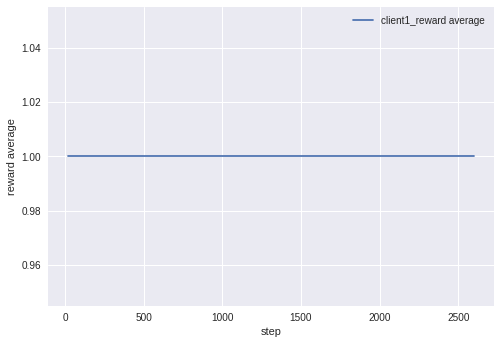

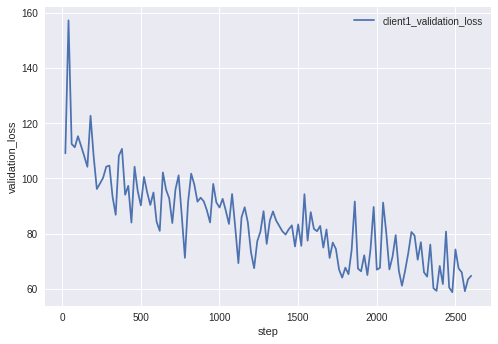

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2621
==== 2621 ====
おやすみ～
    [0]いや、💩www   
    [1]いや、💩www💩www 
おはようございます。寒いですね。
    [0]💩(˙-˙)  
    [1]💩の(˙-˙) 
今回もよろしくです。
    [0]💩💩💩(💩)      
    [1]💩💩💩(💩💩💩💩.💩) 
ばいとおわ！
    [0]💩💩💩               
    [1]💩💩💩💩💩💩.........💩症 
avg_reply_len=12.0
validation loss=62.7
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2641
==== 2641 ====
おやすみ～
    [0]そっーwww  
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]💩の💩の💩を💩-️                     
    [1]💩の💩💩を💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
今回もよろしくです。
    [0]💩の💩💩を💩💩を💩💩         
    [1]💩の💩💩を💩💩を💩💩💩💩💩💩💩💩💩💩 
ばいとおわ！
    [0]💩！   
    [1]あ、💩💩 
avg_reply_len=15.5
validation loss=57.5
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2661
==== 2661 ====
おやすみ～
    [0]いや💩   
    [1]いや、💩

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2701
==== 2701 ====
おやすみ～
    [0]俺は💩www    
    [1]俺の💩の枠や？ 
おはようございます。寒いですね。
    [0]💩www     
    [1]💩ω˙-˙) 
今回もよろしくです。
    [0]💩！                            
    [1]💩！いいよ！！！！！！！！！！！！！！！！！！！！！！！！！！
ばいとおわ！
    [0]💩！   
    [1]これは💩www 
avg_reply_len=13.5
validation loss=41.7
learning rate 0.5
msec/data=6.5


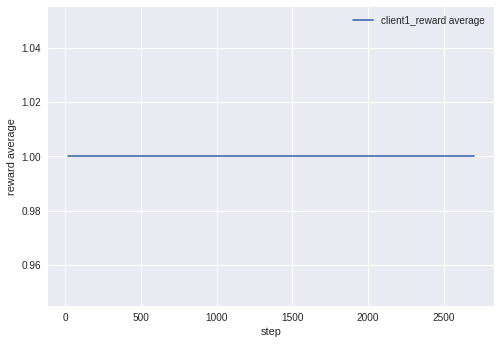

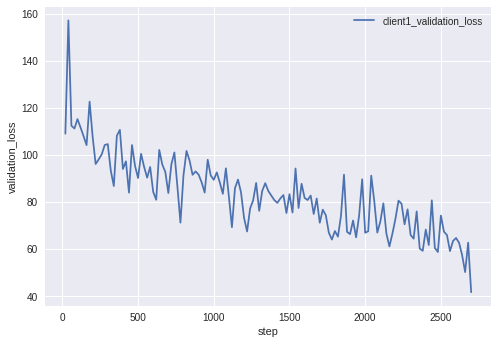

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2721
==== 2721 ====
おやすみ～
    [0]ほんと💩        
    [1]ほんと💩💩て💩て💩たwww 
おはようございます。寒いですね。
    [0]💩ちゃん(˙-˙) 
    [1]💩くん(˙-˙) 
今回もよろしくです。
    [0]💩💩💩💩💩が💩💩💩💩                    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
ばいとおわ！
    [0]💩💩  
    [1]💩💩💩 
avg_reply_len=14.0
validation loss=50.1
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2741
==== 2741 ====
おやすみ～
    [0]それ、💩www 
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]💩…       
    [1]💩…💩(˙-˙) 
今回もよろしくです。
    [0]💩💩💩が、、、、、、                    
    [1]💩💩💩が、、、、、、、、なにちなみにちなみに暇だよ！！！？？？？？？(o'
ばいとおわ！
    [0]💩！  
    [1]💩💩、 
avg_reply_len=12.8
validation loss=49.3
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2761
==== 2761 ====
おやすみ～
    [0]それだよwww 
    [1]それ

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2801
==== 2801 ====
おやすみ～
    [0]俺💩💩             
    [1]💩💩💩💩..........💩 
おはようございます。寒いですね。
    [0]💩💩(˙-˙)   
    [1]💩💩💩は(˙-˙) 
今回もよろしくです。
    [0]💩、💩になります。  
    [1]💩、💩になりました。 
ばいとおわ！
    [0]💩💩💩に💩に見えました。           
    [1]💩💩💩に💩に見えました。💩が💩が💩が💩します。 
avg_reply_len=15.0
validation loss=57.1
learning rate 0.5
msec/data=6.6


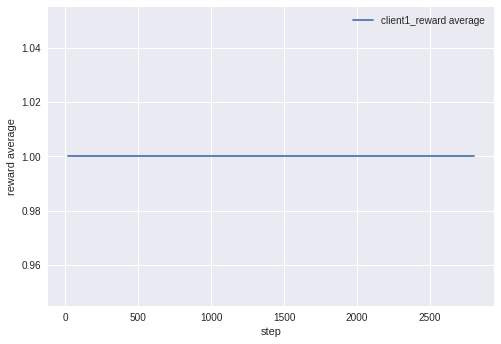

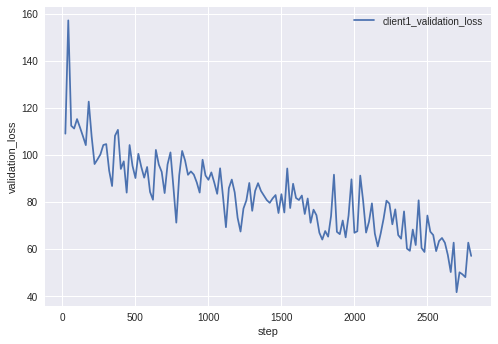

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2821
==== 2821 ====
おやすみ～
    [0]それ💩www  
    [1]それ、💩www 
おはようございます。寒いですね。
    [0]💩www                            
    [1]えー…だよね、、、、、、、、、これこれんん、、、、、、-˙˙ます(˙
今回もよろしくです。
    [0]💩の💩の.💩💩」 
    [1]💩の💩の.💩💩  
ばいとおわ！
    [0]💩！ 
    [1]💩〜 
avg_reply_len=13.0
validation loss=53.3
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2841
==== 2841 ====
おやすみ～
    [0]それだよwww 
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]えー…………………。  
    [1]えー…………………。。 
今回もよろしくです。
    [0]そうですねwww  
    [1]そうだよねwww 
ばいとおわ！
    [0]おつかれましたwww 
    [1]おつかれました  
avg_reply_len=10.2
validation loss=59.3
learning rate 0.5
msec/data=6.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2861
==== 2861 ====
おやすみ～
    [0]それだよwww 
    [1]それだよ  
おはようございます。寒いですね。
    [0]💩www    

おはようございます。寒いですね。
    [0]💩www💩の💩！！   
    [1]💩www💩の💩！！！！ 
今回もよろしくです。
    [0]💩て💩て。          
    [1]💩て💩て。💩を💩を💩てますねwww 
ばいとおわ！
    [0]💩！    
    [1]💩！💩💩www 
avg_reply_len=11.2
validation loss=47.2
learning rate 0.5
msec/data=6.3


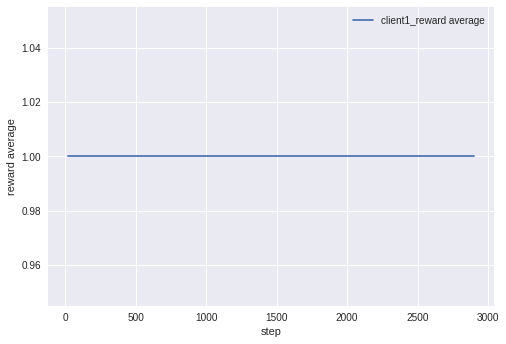

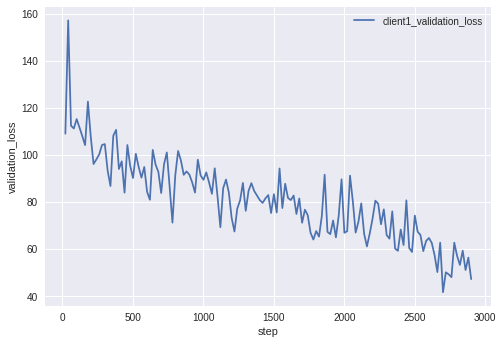

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2921
==== 2921 ====
おやすみ～
    [0]いや、💩💩だからwww   
    [1]いや、💩💩だからwww💩www 
おはようございます。寒いですね。
    [0]💩www          
    [1]💩…💩💩は💩💩は💩-💩 
今回もよろしくです。
    [0]ありがとうございます！  
    [1]ありがとうございます！！ 
ばいとおわ！
    [0]💩！   
    [1]💩︎💩! 
avg_reply_len=11.5
validation loss=56.0
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2941
==== 2941 ====
おやすみ～
    [0]💩の💩の近くで💩んなwww     
    [1]💩の💩の近くで💩てもいいんですねwww 
おはようございます。寒いですね。
    [0]💩www     
    [1]💩の💩-💩) 
今回もよろしくです。
    [0]💩の💩のをを💩て💩ました  
    [1]💩の💩のをを💩て💩ました」 
ばいとおわ！
    [0]💩！                    
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=15.8
validation loss=51.3
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-2961
==== 2961 ====
おやすみ～
    [0]いや、💩     
    [1]いや、今変

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3001
==== 3001 ====
おやすみ～
    [0]俺💩        
    [1]俺💩💩の💩までで💩てる 
おはようございます。寒いですね。
    [0]そうだ(˙-˙)    
    [1]そうだ(˙-˙)なな。 
今回もよろしくです。
    [0]💩！                   
    [1]そうですね！💩日日だよ！！！！え？？？？？？ 
ばいとおわ！
    [0]💩！                      
    [1]💩💩、💩💩💩💩がどう輪更に更に💩💩💩💩💩💩💩💩💩💩💩 
avg_reply_len=16.8
validation loss=51.2
learning rate 0.5
msec/data=6.6


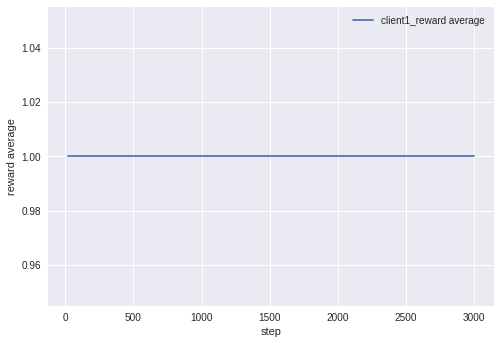

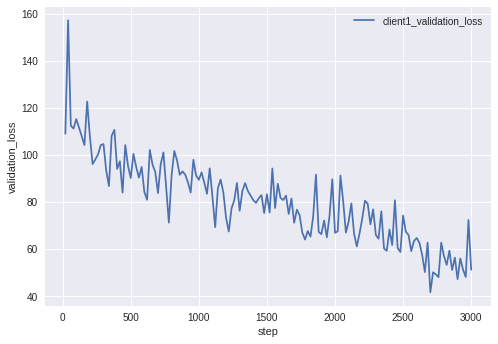

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3021
==== 3021 ====
おやすみ～
    [0]いや、今変だからwww 
    [1]いや、今変だから… 
おはようございます。寒いですね。
    [0]💩(˙-˙)     
    [1]💩(˙-˙)(˙-˙) 
今回もよろしくです。
    [0]💩が💩うねwww                  
    [1]💩が💩💩にして💩💩に💩してもも💩したから(¨̮) 
ばいとおわ！
    [0]💩💩💩!                          
    [1]💩💩💩💩💩💩💩💩に挑戦💩症にしないから💩にしました………💩」に💩に💩
avg_reply_len=19.8
validation loss=54.9
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3041
==== 3041 ====
おやすみ～
    [0]いや、💩  
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]えー。        
    [1]えー、馬鹿かかかかか？ 
今回もよろしくです。
    [0]ありがとうございます  
    [1]ありがとうございます！ 
ばいとおわ！
    [0]💩！      
    [1]💩〜(˘ω˘) 
avg_reply_len=9.2
validation loss=33.0
learning rate 0.5
msec/data=6.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3061
==== 3061 ====
おやすみ～
    [0]それだよ

..reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3101
==== 3101 ====
おやすみ～
    [0]いや、💩                  
    [1]💩さん💩ても💩て食べないわ…💩は💩てあるん('-') 
おはようございます。寒いですね。
    [0]💩ω💩ω💩˙ωˇ)そんな店が💩         
    [1]💩ω💩ω💩˙ωˇ)そんな‘がいいなら、やばい、やばい、やばい！ 
今回もよろしくです。
    [0]💩て💩ました。💩💩💩は)              
    [1]💩て💩ました。💩💩💩は💩のΦがてててます。💩💩💩💩💩 
ばいとおわ！
    [0]💩〜                   
    [1]💩〜(ˇωˇ)💩が💩がいいのがいいんですよね… 
avg_reply_len=23.2
validation loss=32.6
learning rate 0.5
msec/data=6.8


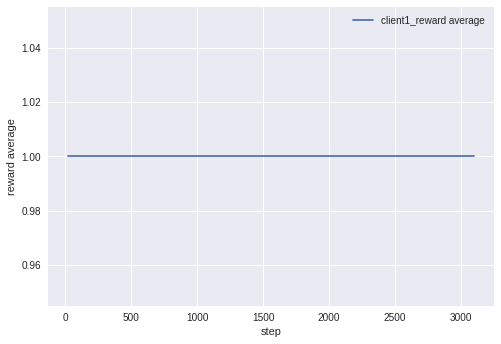

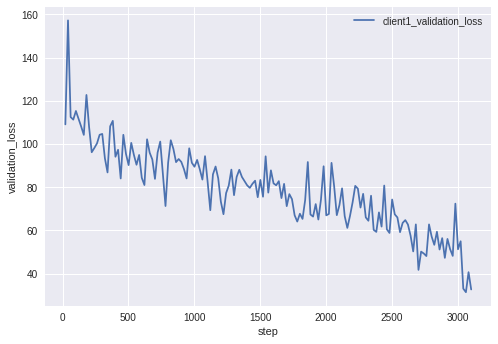

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3121
==== 3121 ====
おやすみ～
    [0]いや、💩www     
    [1]男だよ～(💩ω˘) 
おはようございます。寒いですね。
    [0]えー…(˙-˙)         
    [1]えー…(˙-˙)وなが💩の好きですね 
今回もよろしくです。
    [0]💩の💩の💩のどうしてもらったから…               
    [1]💩の💩の💩のどうしてもらったから……台3に付き合って💩てありがとうます(¨᷆) 
ばいとおわ！
    [0]💩〜      
    [1]💩〜(˙-˙) 
avg_reply_len=17.2
validation loss=45.6
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3141
==== 3141 ====
おやすみ～
    [0]かわいすぎかっwww 
    [1]かわいすぎかった 
おはようございます。寒いですね。
    [0]ごめん、だよね、💩かだよ！  
    [1]ごめん、だよね、💩かだよ！！ 
今回もよろしくです。
    [0]💩！          
    [1]💩の💩の💩までが(¨̮) 
ばいとおわ！
    [0]💩！     
    [1]💩〜(᷇࿀᷆) 
avg_reply_len=11.2
validation loss=26.6
learning rate 0.5
msec/data=6.2
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3161
==== 3161 ====
おやすみ～
    [0]かわいす

..reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3201
==== 3201 ====
おやすみ～
    [0]それだよwww 
    [1]それだわwww 
おはようございます。寒いですね。
    [0]💩www        
    [1]えー………………。。 
今回もよろしくです。
    [0]💩の💩の💩に書いてもらったから…(¨̮) 
    [1]💩の💩の💩に書いてもらったから………   
ばいとおわ！
    [0]💩〜 
    [1]💩！ 
avg_reply_len=11.0
validation loss=60.4
learning rate 0.5
msec/data=6.3


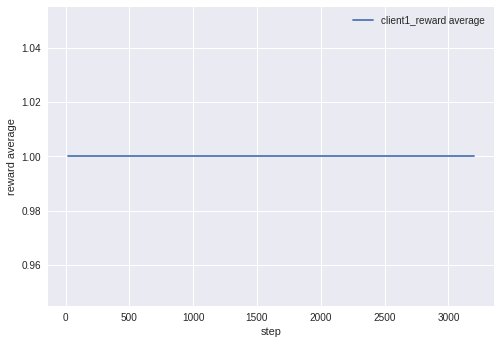

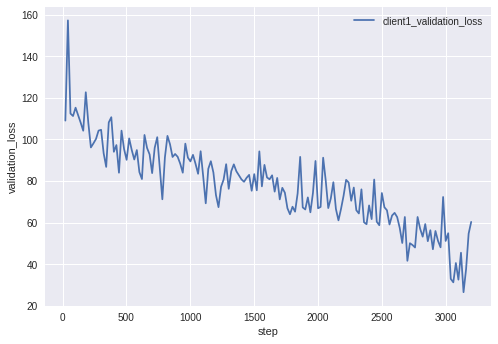

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3221
==== 3221 ====
おやすみ～
    [0]いやいいわwww     
    [1]いやいいわwww💩だからwww 
おはようございます。寒いですね。
    [0]ごめん、5000のどうかなwww                      
    [1]ごめん、5000のどうかなとだよ、、、、、、、、否定だ、言ったら💩やすいことないな、、
今回もよろしくです。
    [0]💩！       
    [1]💩で💩して💩💩💩 
ばいとおわ！
    [0]💩！ 
    [1]💩〜 
avg_reply_len=15.8
validation loss=31.8
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3241
==== 3241 ====
おやすみ～
    [0]それだよ                     
    [1]それだよねもう夢会える欲しい、これ、💩💩💩してるし？(˘ω˘) 
おはようございます。寒いですね。
    [0]えー馬鹿かな💩💩なんだな💩                   
    [1]えー馬鹿かな💩💩なんだなそんなでののがががんんなの、どう💩やすいからだよ、、
今回もよろしくです。
    [0]やった💩💩！  
    [1]やった💩💩!🎵 
ばいとおわ！
    [0]💩〜〜(**)   
    [1]💩〜〜(*o**) 
avg_reply_len=18.8
validation loss=61.4
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/t

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3301
==== 3301 ====
おやすみ～
    [0]いや、💩💩なのだなwww 
    [1]いや、💩💩なのだのwww 
おはようございます。寒いですね。
    [0]えーwww                      
    [1]え、5000、どう日かなのだよ、、、、ののところところことかことだ 
今回もよろしくです。
    [0]💩！   
    [1]💩うねwww 
ばいとおわ！
    [0]💩〜                            
    [1]💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩💩
avg_reply_len=18.8
validation loss=49.8
learning rate 0.5
msec/data=6.6


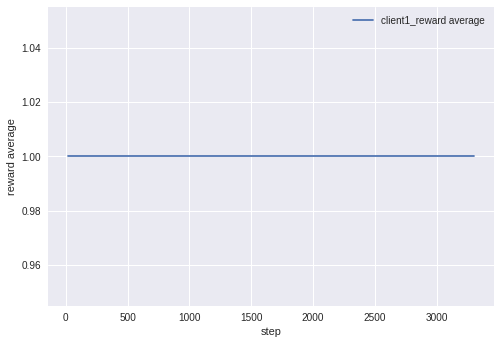

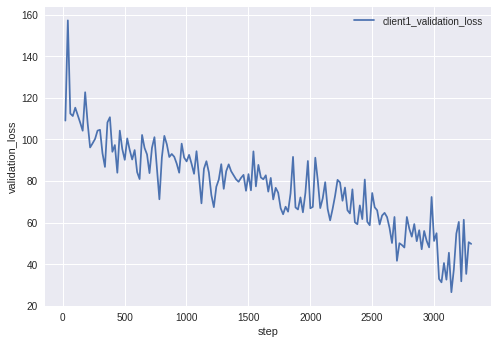

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3321
==== 3321 ====
おやすみ～
    [0]いや、💩  
    [1]いや、💩www 
おはようございます。寒いですね。
    [0]えーwwwいい………………。うちががががですのなの？な感じよ💩…感じ)  
    [1]えーwwwいい………………。うちががががですのなの？な感じよ💩…感じ…) 
今回もよろしくです。
    [0]💩の💩になってるねwww  
    [1]💩の💩になってるからねwww 
ばいとおわ！
    [0]待ってきない(;_;) 
    [1]待ってきない(˘ω˘) 
avg_reply_len=17.2
validation loss=37.2
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3341
==== 3341 ====
おやすみ～
    [0]それだよ  
    [1]それだよwww 
おはようございます。寒いですね。
    [0]えー、だよね、💩だからなw   
    [1]えー、だよね、💩だからですなっていう？ 
今回もよろしくです。
    [0]え！        
    [1]💩の💩で💩うよね💩 
ばいとおわ！
    [0]待ってください(˘ω˘)           
    [1]待ってきたらめっちゃめっちゃ嬉しいだ💩💩さんにしかしないから思った 
avg_reply_len=13.8
validation loss=33.7
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3361


....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3401
==== 3401 ====
おやすみ～
    [0]いや、💩      
    [1]いや、普通にねる💩た？ 
おはようございます。寒いですね。
    [0]ごめん、なんのかなwww 
    [1]ごめん、なんのかな… 
今回もよろしくです。
    [0]💩www 
    [1]💩！ 
ばいとおわ！
    [0]💩水分！                  
    [1]💩水分に💩ににささことを💩に💩したのはこれ見てる 
avg_reply_len=12.5
validation loss=20.4
learning rate 0.5
msec/data=6.4


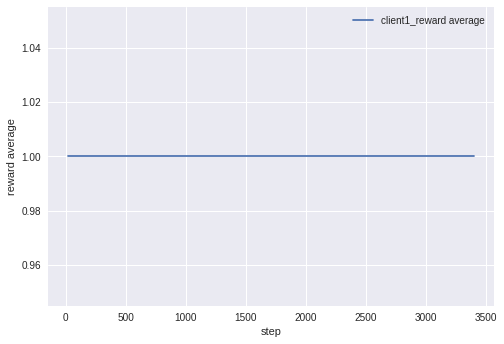

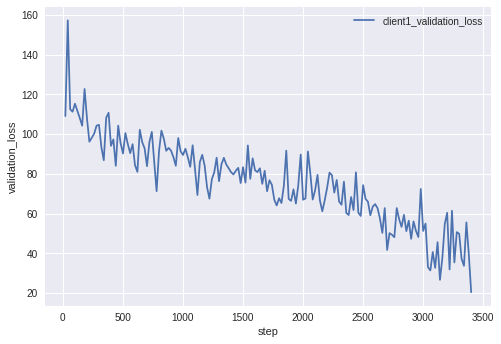

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3421
==== 3421 ====
おやすみ～
    [0]それだよwww 
    [1]それだわwww 
おはようございます。寒いですね。
    [0]なんがは？？だから……。。、、どう💩でかってことないないwww     
    [1]なんがは？？だから……。。、、どう💩でかってことないないないのないないない 
今回もよろしくです。
    [0]💩！     
    [1]💩して💩💩！ 
ばいとおわ！
    [0]これはこれだよwww      
    [1]これはこれだよ(💩)💩💩💩 
avg_reply_len=16.8
validation loss=50.7
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3441
==== 3441 ====
おやすみ～
    [0]いや、もう暇、もう💩www 
    [1]いや、もう暇にも💩www 
おはようございます。寒いですね。
    [0]いや、や……                         
    [1]いや、や………、、、！！！とゆうだなの？ってだなんなたたたたたたた
今回もよろしくです。
    [0]💩！       
    [1]今日の後のせい、また💩 
ばいとおわ！
    [0]これはこれが💩www       
    [1]これはこれ！でも失礼します(¨̮) 
avg_reply_len=17.8
validation loss=54.7
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/Chatb

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3501
==== 3501 ====
おやすみ～
    [0]いや、💩         
    [1]いや、やだよ、、、💩が妖精 
おはようございます。寒いですね。
    [0]えー、5000💩かかや💩💩 
    [1]えー、5000💩かかだのも 
今回もよろしくです。
    [0]💩www    
    [1]💩やったねwww 
ばいとおわ！
    [0]お(💩)             
    [1]お(•.ʖ*てたから💩が💩がいいですwww 
avg_reply_len=13.0
validation loss=40.0
learning rate 0.5
msec/data=6.4


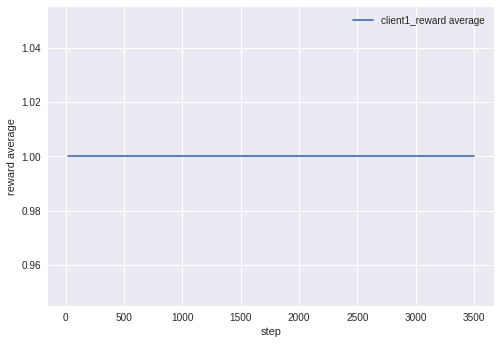

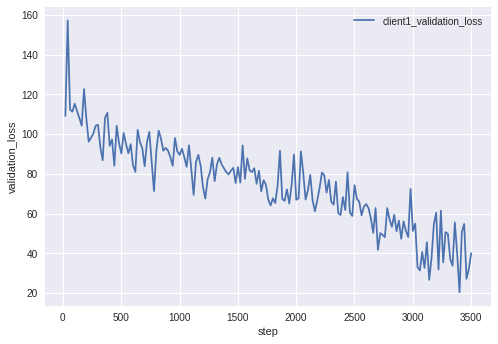

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3521
==== 3521 ====
おやすみ～
    [0]それ、普通の変が思ってたわ   
    [1]それ、普通の変が思ったんだわwww 
おはようございます。寒いですね。
    [0]なんでかな           
    [1]えー、5000はどうどうかなのなのかよ 
今回もよろしくです。
    [0]💩！   
    [1]ありがとうございます！ 
ばいとおわ！
    [0]待ってるよ(๑´.`)  
    [1]待ってるよ(๑•.•.)？ 
avg_reply_len=12.5
validation loss=33.4
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3541
==== 3541 ====
おやすみ～
    [0]それだよwww     
    [1]それだから楽しみすぎやでwww 
おはようございます。寒いですね。
    [0]💩www       
    [1]いや、5000💩かとや！ 
今回もよろしくです。
    [0]ありがとうございました 
    [1]ありがとうございます！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=11.5
validation loss=50.0
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3561
==== 3561 ====
おやすみ～
    [0]もぉ癖すぎたからこれやwww    
    [1]もぉ癖す

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3601
==== 3601 ====
おやすみ～
    [0]かわいすぎすぎ、これや 
    [1]かわいすぎすぎ、これやばい 
おはようございます。寒いですね。
    [0]💩www      
    [1]いや、5000💩かか… 
今回もよろしくです。
    [0]💩www 
    [1]💩！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=9.5
validation loss=30.1
learning rate 0.5
msec/data=6.3


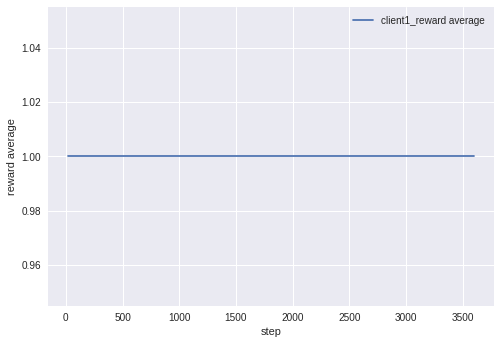

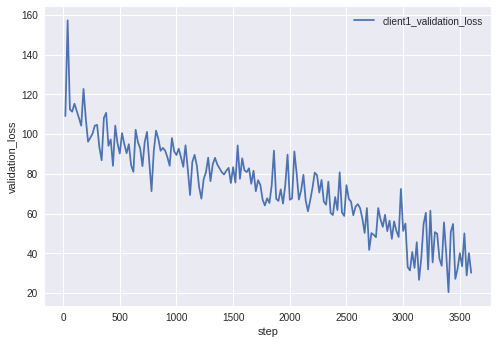

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3621
==== 3621 ====
おやすみ～
    [0]そっ！    
    [1]もぉ癖すぎたわ 
おはようございます。寒いですね。
    [0]💩www      
    [1]💩くん(˙-˙) 
今回もよろしくです。
    [0]💩www 
    [1]💩！ 
ばいとおわ！
    [0]待ってほら！(¨̮)  
    [1]待ってほら！(*ˊᗜˋ*) 
avg_reply_len=8.5
validation loss=47.7
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3641
==== 3641 ====
おやすみ～
    [0]いや、💩やすぎwww   
    [1]いや、💩すぎてもらってるwww 
おはようございます。寒いですね。
    [0]💩www                         
    [1]💩wwwいいよ、、、、、ののののかんん、さんん、、、-よ) 
今回もよろしくです。
    [0]💩！                           
    [1]やったね！💩いっられを💩からじ💩してささ(¨°)و💩ですー………… 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(💩)   
avg_reply_len=20.5
validation loss=33.3
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3661
==== 3661 ====
おやすみ～
    [0]美味

reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3701
==== 3701 ====
おやすみ～
    [0]やばすぎwww    
    [1]やばすぎ(ˊᵕˋだwww 
おはようございます。寒いですね。
    [0]💩www                   
    [1]💩wwwいいよ、、、でででででだんだけど(˙˙) 
今回もよろしくです。
    [0]💩www 
    [1]💩！ 
ばいとおわ！
    [0]💩、💩💩             
    [1]待っ、ありがと！💩さんねるがいいんだった(¨̮) 
avg_reply_len=14.0
validation loss=31.1
learning rate 0.5
msec/data=6.5


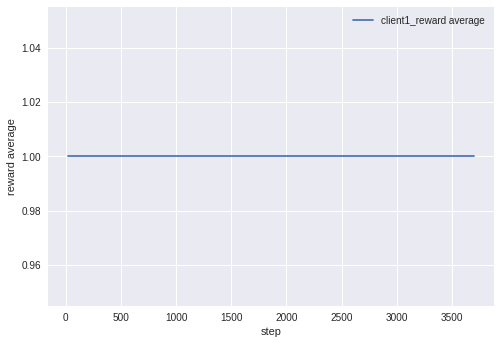

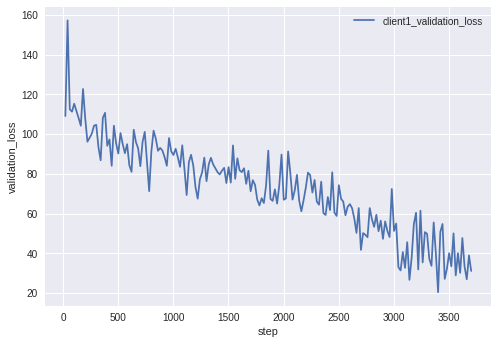

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3721
==== 3721 ====
おやすみ～
    [0]やばそうwww         
    [1]やば💩ば💩すぎてもらってやるわwww 
おはようございます。寒いですね。
    [0]いや、や………なんてで、💩な！！           
    [1]いや、や………人で、💩💩なのですよ(・かが、˙-3 
今回もよろしくです。
    [0]💩！      
    [1]💩したのは💩www 
ばいとおわ！
    [0]待っ！      
    [1]待ってる(*॑꒳॑*) 
avg_reply_len=15.0
validation loss=20.6
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3741
==== 3741 ====
おやすみ～
    [0]やばすぎwww    
    [1]やばすぎ、💩や… 
おはようございます。寒いですね。
    [0]💩www        
    [1]いや、5000💩か奴やなw 
今回もよろしくです。
    [0]💩！    
    [1]💩したわwww 
ばいとおわ！
    [0]💩！こちら！   
    [1]💩、これ！！！ 
avg_reply_len=9.5
validation loss=35.5
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3761
==== 3761 ====
おやすみ～
    [0]生きたよ笑    
    [1]やばすぎ(ˊᵕˋﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝ

.reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3801
==== 3801 ====
おやすみ～
    [0]生き、普通が…             
    [1]生き、普通が………これが💩て💩ていいお思って 
おはようございます。寒いですね。
    [0]💩www          
    [1]んのかな💩💩を💩て💩www 
今回もよろしくです。
    [0]💩の💩💩に。              
    [1]💩の💩💩に💩うなwww💩💩💩💩💩💩💩(💩) 
ばいとおわ！
    [0]💩〜(᷇࿀ᴗ*)  
    [1]💩〜〜！！💩💩www 
avg_reply_len=16.0
validation loss=26.7
learning rate 0.5
msec/data=6.6


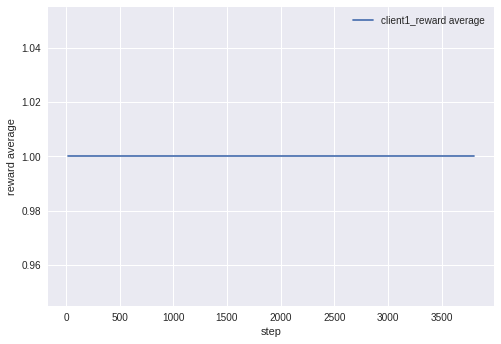

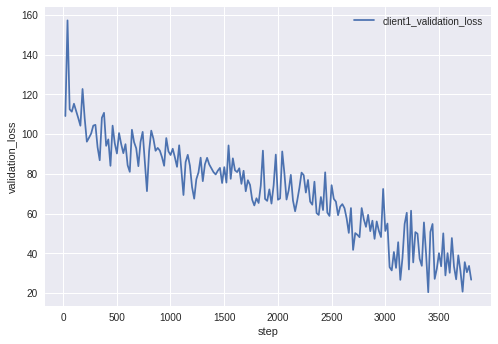

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3821
==== 3821 ====
おやすみ～
    [0]いや、やってなかったwww 
    [1]生き、普通を…   
おはようございます。寒いですね。
    [0]いや、5000💩かなwww                
    [1]いや、5000💩かとやと💩れるといいんらのはも否定でもないん 
今回もよろしくです。
    [0]💩！       
    [1]💩やった💩💩はどう。 
ばいとおわ！
    [0]これはこれ！             
    [1]これはこれだあ今日は美しいで💩ていいよ！！！ 
avg_reply_len=17.8
validation loss=15.4
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3841
==== 3841 ====
おやすみ～
    [0]生きすぎすぎ！！！  
    [1]もぉ癖にしたからwww 
おはようございます。寒いですね。
    [0]こういう人ははどうし…かだな。       
    [1]こういう人ははどうし…かかだんだんですか？？ 
今回もよろしくです。
    [0]💩！ 
    [1]はい！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(**)  
avg_reply_len=11.8
validation loss=31.1
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3861
==== 3861 ====
おやすみ～
    [0

..reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3901
==== 3901 ====
おやすみ～
    [0]男だから、いだけど…             
    [1]男だから、いだけど、これの💩の💩が💩が💩てます。 
おはようございます。寒いですね。
    [0]💩て。💩しないのだのです。でです💩💩ある💩💩ばがたがももももも、-か
    [1]💩て。💩しないのだのです。でです💩💩ある💩💩ばがたがもももももな、 
今回もよろしくです。
    [0]こさん💩してるでwww    
    [1]こさん💩してるのは無理ですなぁ 
ばいとおわ！
    [0]おつ！(💩)   
    [1]おつ！(*ˊᗜˋ*) 
avg_reply_len=20.2
validation loss=23.7
learning rate 0.5
msec/data=6.6


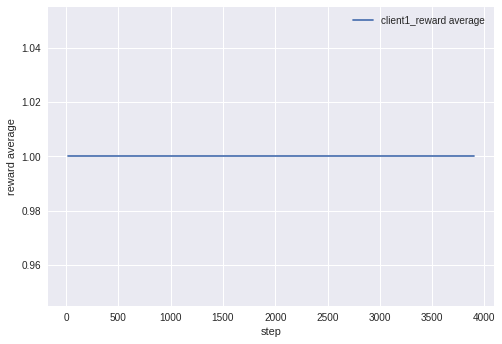

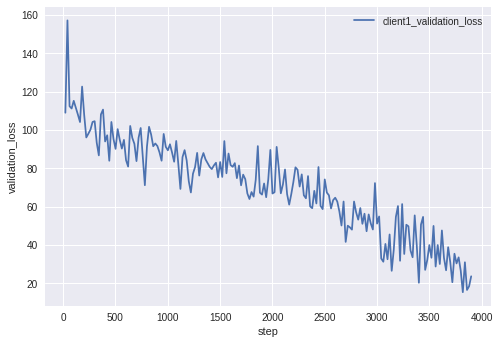

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3921
==== 3921 ====
おやすみ～
    [0]やば💩ば、もう💩やな  
    [1]やば💩ば、もう💩だなwww 
おはようございます。寒いですね。
    [0]えー、5000💩ねってやなwww 
    [1]えー、5000💩かってやな  
今回もよろしくです。
    [0]💩！             
    [1]ほら、今日のその変をあってたですかな？ 
ばいとおわ！
    [0]💩〜あ！     
    [1]💩〜あ！！💩💩www 
avg_reply_len=13.2
validation loss=21.4
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3941
==== 3941 ====
おやすみ～
    [0]生き…             
    [1]生きすぎ、いかがだけど、びっくり💩があるんや？ 
おはようございます。寒いですね。
    [0]いや、や……すき、、と💩💩がなのな(ない。           
    [1]いや、や……すき、、と💩💩がなのな(ない。(こんなにお💩ω💩(-T) 
今回もよろしくです。
    [0]💩！     
    [1]今日がして💩ね 
ばいとおわ！
    [0]💩〜(˘ω˘)  
    [1]おつ！(*ˊᗜˋ*) 
avg_reply_len=16.0
validation loss=26.3
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-3961
==== 3961 ===

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4001
==== 4001 ====
おやすみ～
    [0]もぉりんさんもいたよwww 
    [1]もぉりんさんもいたよw 
おはようございます。寒いですね。
    [0]いや、5000💩かと💩てんのにと、💩達がもいい💩が💩が💩したし💩    
    [1]いや、5000💩かと💩てんのにと、💩達がもいい💩が💩が💩したし💩にに(˘
今回もよろしくです。
    [0]ほら！                       
    [1]今日ですかににないですか、美しい」のゴミな目的は友達💩です(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=21.8
validation loss=32.8
learning rate 0.5
msec/data=6.7


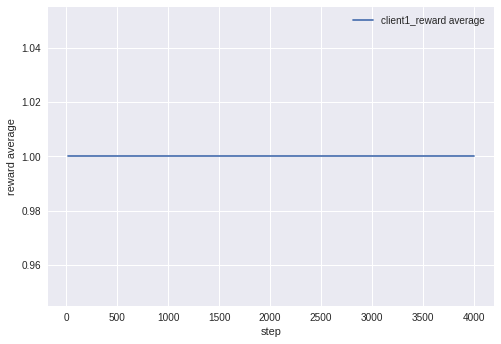

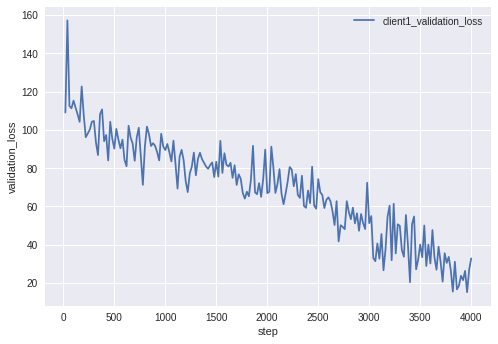

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4021
==== 4021 ====
おやすみ～
    [0]もぉ癖がいたわwww 
    [1]もぉ癖がいたわ  
おはようございます。寒いですね。
    [0]いや、5000💩かとはずるいといいよなぁ   
    [1]いや、5000💩かとはずるいといいんじゃない？ 
今回もよろしくです。
    [0]💩！  
    [1]それですね 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=12.2
validation loss=36.7
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4041
==== 4041 ====
おやすみ～
    [0]もぉ癖すぎすぎないわwww  
    [1]もぉ癖すぎすぎ、最近やばいwww 
おはようございます。寒いですね。
    [0]いや、や……ケーキ💩ととと合わせとおおしれませんちゃ？           
    [1]いや、や……ケーキ💩ととと合わせとおおしれません(ᐛななな)たもん〜--` 
今回もよろしくです。
    [0]今日がしてきたwww      
    [1]今日がして💩ました(˘ω💩) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=20.0
validation loss=11.1
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4061
==== 4061 ==

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4101
==== 4101 ====
おやすみ～
    [0]美味かったぁwww    
    [1]もぉ癖にいたわwww 
おはようございます。寒いですね。
    [0]いや、やばい……ケーキだから💩。                 
    [1]いや、やばい……ケーキだから💩💩てんのにです、、どう💩しても線画みたいた💩( 
今回もよろしくです。
    [0]はい！                      
    [1]ほらですか、、これで💩は、、」だ」💩楽しい💩だ💩(᷇࿀だ) 
ばいとおわ！
    [0]待っ、きたよwww                    
    [1]待っ、いかがで私は私だと思ってみてすんですけど今回はあったら嬉しいんです。 
avg_reply_len=25.0
validation loss=12.6
learning rate 0.5
msec/data=6.8


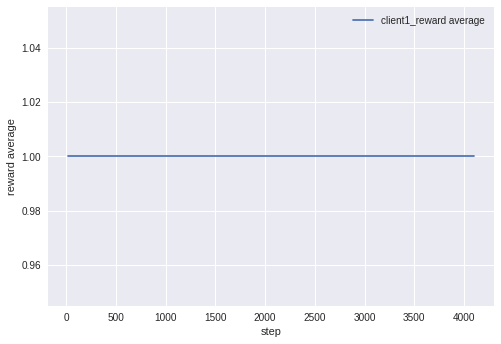

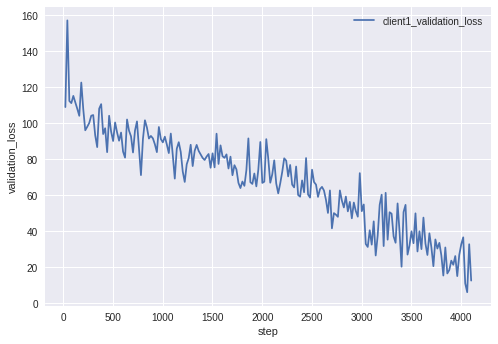

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4121
==== 4121 ====
おやすみ～
    [0]もぉ癖にして、💩やwww    
    [1]もぉ癖にして、💩死ん出ましたwww 
おはようございます。寒いですね。
    [0]💩www調べ💩ね、、💩！5000💩の気がいいだけだわ(ᐛ) 
    [1]💩www調べ💩ね、、💩！5000💩の気がいいだけだわ(ふ) 
今回もよろしくです。
    [0]💩！    
    [1]💩やったわwww 
ばいとおわ！
    [0]待っ！|॑꒳॑*)        
    [1]待っ！|॑꒳॑*)💩💩文字💩とかなwww 
avg_reply_len=17.2
validation loss=16.1
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4141
==== 4141 ====
おやすみ～
    [0]もぉ💩(      
    [1]生き💩ば💩すぎて食べすぎる 
おはようございます。寒いですね。
    [0]いや、や……ケーキのとです……     
    [1]いや、や……ケーキのと💩なのなのねw 
今回もよろしくです。
    [0]はい！ 
    [1]ほら！ 
ばいとおわ！
    [0]待っ！|॑꒳॑**⸝💩💩www   
    [1]待っ！|॑꒳॑**⸝💩💩が可愛いwww 
avg_reply_len=13.0
validation loss=12.4
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4161
==== 4161 ==

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4201
==== 4201 ====
おやすみ～
    [0]美味かったぁwww 
    [1]美味かったぁ笑 
おはようございます。寒いですね。
    [0]いや、や……怖い💩…!!)  
    [1]いや、やばい……怖いだから…。。 
今回もよろしくです。
    [0]ほら！      
    [1]絶対から💩やったねwww 
ばいとおわ！
    [0]💩〜〜〜    
    [1]💩〜(᷇࿀ᴗ॑) 
avg_reply_len=10.5
validation loss=15.9
learning rate 0.5
msec/data=6.3


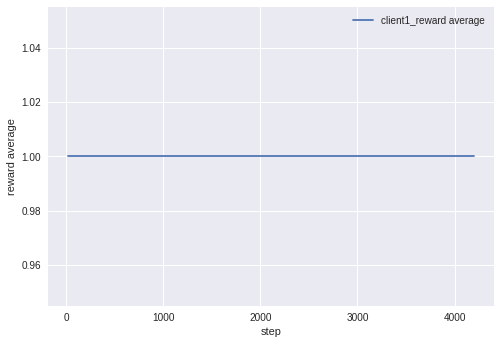

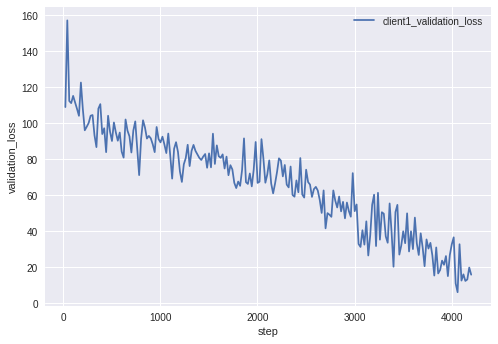

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4221
==== 4221 ====
おやすみ～
    [0]美味かったよ笑 
    [1]美味かったぁ笑 
おはようございます。寒いですね。
    [0]えー、5000💩💩てますとだ💩のしかない                 
    [1]えー、5000💩💩てますでだ💩の回見たんだ、💩的だからたてんんん嬉しい(ふ)
今回もよろしくです。
    [0]はい！   
    [1]絶対から💩！ 
ばいとおわ！
    [0]どうぞ！(*ˊᗜˋ*) 
    [1]待っにどうぞ！💩ありがと！ 
avg_reply_len=15.8
validation loss=38.4
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4241
==== 4241 ====
おやすみ～
    [0]もぉ癖すぎたからwww 
    [1]もぉ癖すぎたから  
おはようございます。寒いですね。
    [0]💩www         
    [1]💩www調べ、お事……！！ 
今回もよろしくです。
    [0]💩！     
    [1]💩やったねねwww 
ばいとおわ！
    [0]💩〜(˙-˙) 
    [1]💩〜(᷇࿀᷆)  
avg_reply_len=10.0
validation loss=11.3
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4261
==== 4261 ====
おやすみ～
    [0]生き、普通も💩んわwww 
    [1]もぉまだ💩す

reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4301
==== 4301 ====
おやすみ～
    [0]美味かったね笑     
    [1]もぉ癖にでいんわwww 
おはようございます。寒いですね。
    [0]ありがとうございます!)                         
    [1]ありがとうございます!💩💩!!💩💩💩💩💩💩💩💩💩💩💩(-💩💩💩💩💩💦💩💩💩
今回もよろしくです。
    [0]💩！     
    [1]絶対から💩うぜwww 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(***) 
avg_reply_len=16.8
validation loss=17.5
learning rate 0.5
msec/data=6.5


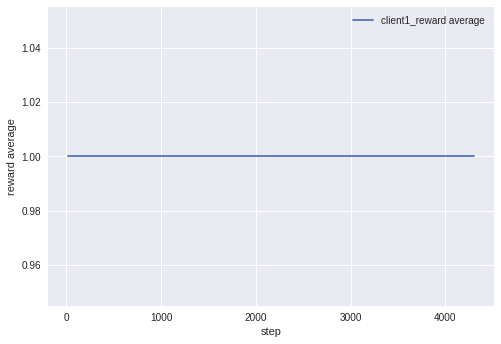

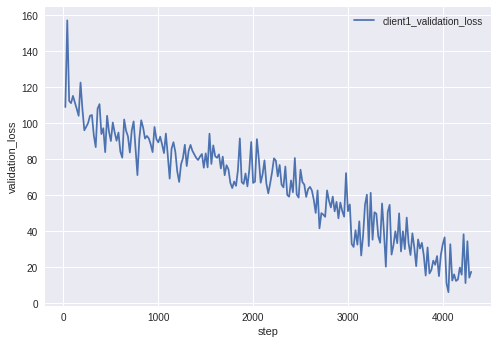

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4321
==== 4321 ====
おやすみ～
    [0]美味かっだよwww 
    [1]美味かっだね笑 
おはようございます。寒いですね。
    [0]ありがとうございますwww       
    [1]ありがとうございますwwwとりあえず日はいける😍… 
今回もよろしくです。
    [0]ほら(˙-˙) 
    [1]え！いい尻日www 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(¨̮)  
avg_reply_len=12.2
validation loss=14.4
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4341
==== 4341 ====
おやすみ～
    [0]美味かったよwww 
    [1]美味かったねwww 
おはようございます。寒いですね。
    [0]本当に馬鹿かなwww      
    [1]本当に馬鹿かなのに💩💩💦💩れる 
今回もよろしくです。
    [0]でですかwww         
    [1]でですかって見てですけど(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(***) 
avg_reply_len=13.2
validation loss=23.4
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4361
==== 4361 ====
おやすみ～
    [0]美味かったぁwww      
    [1]もぉ癖で…(˘ω˘)

.reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4401
==== 4401 ====
おやすみ～
    [0]美味かった〜笑       
    [1]生き、普通の…(˘ω˘) 
おはようございます。寒いですね。
    [0]💩www                      
    [1]💩www調べないね💩で💩たいれたからです💩のがあるの洗濯あるあるして 
今回もよろしくです。
    [0]はい         
    [1]💩の💩しちゃったけどねwww 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(¨̮)  
avg_reply_len=15.5
validation loss=17.6
learning rate 0.5
msec/data=6.5


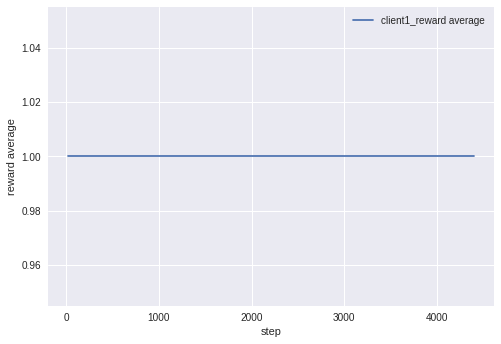

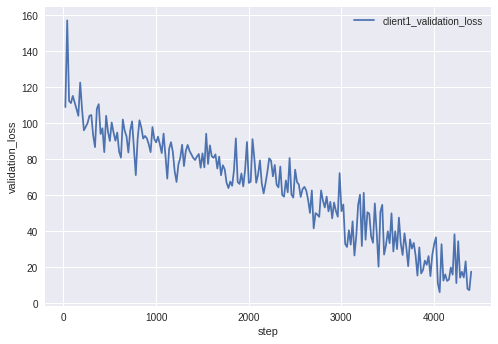

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4421
==== 4421 ====
おやすみ～
    [0]美味かったぁwww 
    [1]美味かったさwww 
おはようございます。寒いですね。
    [0]ありがとうございます╭(・💩)  
    [1]ありがとうございます╭(・💩˙) 
今回もよろしくです。
    [0]はい  
    [1]💩！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ˊᗜˋ^)＜) 
avg_reply_len=10.5
validation loss=16.0
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4441
==== 4441 ====
おやすみ～
    [0]美味かったぜ(ˊᵕˋ) 
    [1]美味かったねぇ(ˊᵕˋ) 
おはようございます。寒いですね。
    [0]本当に、や……                      
    [1]えー、や……怖いと💩↓で。💩なとかだからがが好きなこと的💩ました) 
今回もよろしくです。
    [0]やった      
    [1]やった(・💩・) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(¨̮)  
avg_reply_len=15.2
validation loss=15.8
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4461
==== 4461 ====
おやすみ～
    [0]もぉ指定すぎてwww          
    [1]美

reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4501
==== 4501 ====
おやすみ～
    [0]美味かったぁwww   
    [1]美味かったぜ(ˊᵕˋ) 
おはようございます。寒いですね。
    [0]えー、馬鹿💩かと💩とˊ꒳ˋて鏡ます                  
    [1]えー、馬鹿💩かと💩とˊ꒳ˋてやるのにと、オレでかもで、これでただけです(͡°͜ʖ͡`
今回もよろしくです。
    [0]やったね💩     
    [1]やったね(˙꒳​˙) 
ばいとおわ！
    [0]おつかれ！(¨̮)  
    [1]おつかれ！(*ˊᗜˋ*) 
avg_reply_len=17.0
validation loss=14.9
learning rate 0.5
msec/data=6.5


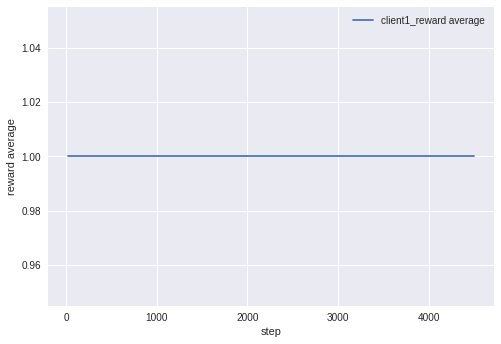

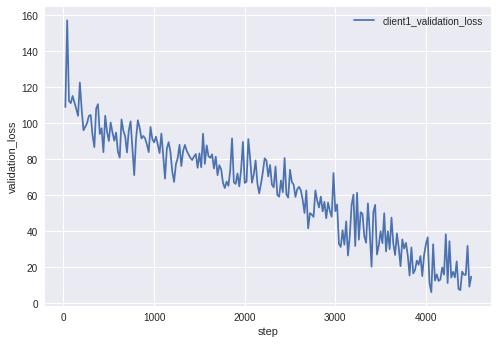

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4521
==== 4521 ====
おやすみ～
    [0]美味かったぜ(ˊᵕˋ) 
    [1]美味かったぁwww   
おはようございます。寒いですね。
    [0]私のかなふ…     
    [1]私のかなふ💩💩達💩。 
今回もよろしくです。
    [0]💩！   
    [1]やったね💩 
ばいとおわ！
    [0]待っ、きたよ！💩💩の日の行けない！！             
    [1]待っ、きたよ！💩💩の💩💩好きなあ！またをしろー、またo分けたい！！！ 
avg_reply_len=14.8
validation loss=16.2
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4541
==== 4541 ====
おやすみ～
    [0]美味かっ！   
    [1]美味かったぁwww 
おはようございます。寒いですね。
    [0]ありがとうございます！           
    [1]ありがとうございます。ケーキの言ってたら…ってですね？ 
今回もよろしくです。
    [0]💩やったねwww  
    [1]💩やったねねwww 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=12.8
validation loss=30.7
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4561
==== 4561 ====
おやすみ～
    [0]美味かったぜ(ˊᵕ

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4601
==== 4601 ====
おやすみ～
    [0]美味かっだよねwww 
    [1]美味かっだよ！笑 
おはようございます。寒いですね。
    [0]えー、馬鹿…調べ💩ないと？    
    [1]えー、馬鹿…調べ💩ないとさ💩💜www 
今回もよろしくです。
    [0]やったね(˘ω˘) 
    [1]やったね(˙꒳​˙) 
ばいとおわ！
    [0]おつかれ「      
    [1]おつかれた(¨​･) 
avg_reply_len=12.2
validation loss=10.3
learning rate 0.5
msec/data=6.3


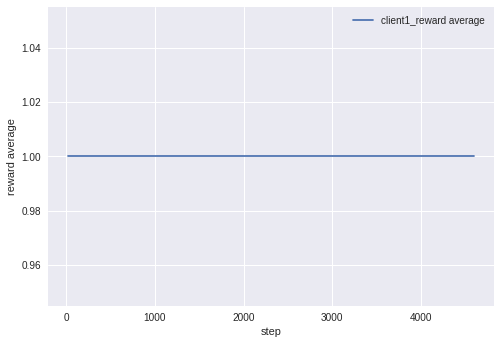

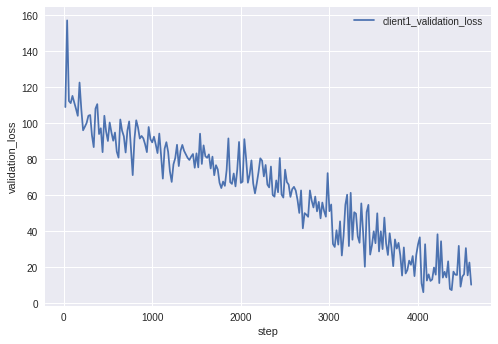

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4621
==== 4621 ====
おやすみ～
    [0]美味かっ、普通は楽しみだけどもう大丈夫ですなw  
    [1]美味かっ、普通は楽しみだけどこれなんですか？ 
おはようございます。寒いですね。
    [0]ありがとうございます！           
    [1]ありがとうございます！でも、の場合ことだてですけど、 
今回もよろしくです。
    [0]やったね(˘ω˘) 
    [1]やったね(•_•) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(¨̮)  
avg_reply_len=17.0
validation loss=20.8
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4641
==== 4641 ====
おやすみ～
    [0]美味かったよねwww        
    [1]美味かった〜笑♪(´・・*⸝ー💩www 
おはようございます。寒いですね。
    [0]💩www    
    [1]💩www調べた！ 
今回もよろしくです。
    [0]💩やった💩(¨̮˙) 
    [1]💩やった💩(¨​˙) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(***) 
avg_reply_len=12.0
validation loss=17.8
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4661
==== 4661 ====
おやすみ～
    [0]美味かったわ

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4701
==== 4701 ====
おやすみ～
    [0]美味かった？笑     
    [1]美味かった〜！もう💩ちゃんwww 
おはようございます。寒いですね。
    [0]💩www調べてる！いつか日💩www   
    [1]💩www調べてる！いつか日💩…！！ 
今回もよろしくです。
    [0]💩！     
    [1]💩やった💩💩！ 
ばいとおわ！
    [0]待っ、今さヤツwww            
    [1]待っ、今💩にににさ情報タオル高の💩とか💩て来る 
avg_reply_len=15.2
validation loss=12.8
learning rate 0.5
msec/data=6.5


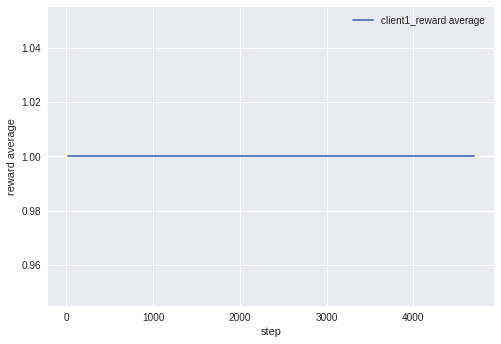

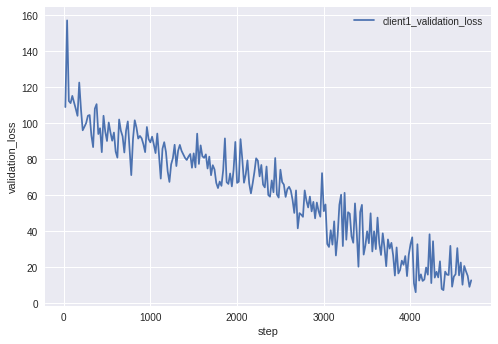

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4721
==== 4721 ====
おやすみ～
    [0]もぉ癖にしてたかもwww 
    [1]もぉ癖にしてたわw 
おはようございます。寒いですね。
    [0]ありがとうございます！(◜💩ωஇ｀)ってわw             
    [1]ありがとうございます！(◜💩ωஇ｀)って店し💩さなら大好きにねてね💩ね💩ゞ 
今回もよろしくです。
    [0]やったね(ˇωˇ) 
    [1]やった(ˇωˇ)  
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(˙꒳​*) 
avg_reply_len=17.2
validation loss=11.4
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4741
==== 4741 ====
おやすみ～
    [0]もぉ癖すぎんわwww         
    [1]もぉ癖すぎたからこれやってた(˘ω˘) 
おはようございます。寒いですね。
    [0]💩www         
    [1]💩www調べ、どうが…って感じ… 
今回もよろしくです。
    [0]やったね(ˇωˇ)       
    [1]やったね！のいったら描いてください(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ˊᗜˋ･`) 
avg_reply_len=14.8
validation loss=6.1
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4761
==

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4801
==== 4801 ====
おやすみ～
    [0]もぉ癖すぎたわwww     
    [1]もぉ癖すぎたからwww女子本くらい？ 
おはようございます。寒いですね。
    [0]ありがとうございます！(◜💩ω💩`)           
    [1]ありがとうございます！(◜💩ω💩*)の💩にそこに初心者ですー💩💩) 
今回もよろしくです。
    [0]やったねwww       
    [1]やったね✌︎('ω'✌*) 
ばいとおわ！
    [0]お(˙꒳​；) 
    [1]お(˙꒳​*) 
avg_reply_len=16.5
validation loss=3.2
learning rate 0.5
msec/data=6.4


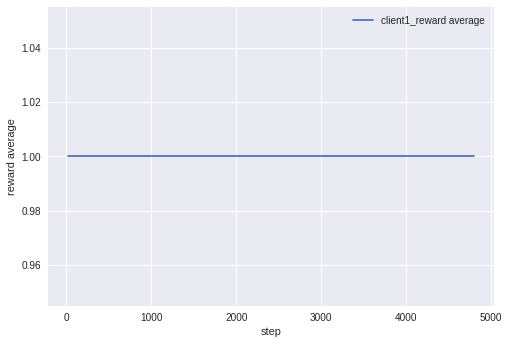

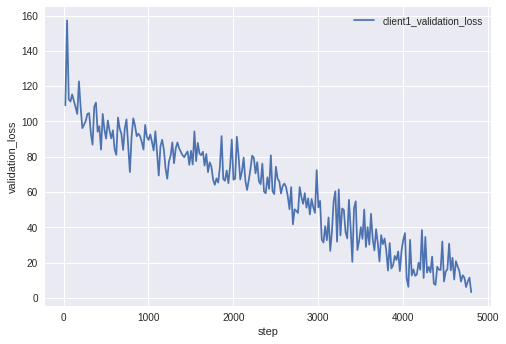

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4821
==== 4821 ====
おやすみ～
    [0]やめろww    
    [1]もぉ癖だからwww 
おはようございます。寒いですね。
    [0]ありがとう恥ずかしいですね、、？                     
    [1]ありがとう恥ずかしいです!💩なそこではは桜がいいんだろ、💩達切ったがかしらがダメでたた 
今回もよろしくです。
    [0]💩！   
    [1]やったねwww 
ばいとおわ！
    [0]待ってるー(ˇωˇ) 
    [1]待ってるー！💩／💩  
avg_reply_len=15.5
validation loss=13.6
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4841
==== 4841 ====
おやすみ～
    [0]美味かったよwww   
    [1]もぉ癖すぎだからwww 
おはようございます。寒いですね。
    [0]ありがとうございます！なかgt💩) 
    [1]ありがとうございます！(◜д💩) 
今回もよろしくです。
    [0]やったね✌︎('ω'✌︎) 
    [1]ではかか？      
ばいとおわ！
    [0]待っ、今、…(˘ω˘) 
    [1]待っ、今、…(¨̮)  
avg_reply_len=14.0
validation loss=16.1
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4861
==== 4861 ====
おやすみ～
    

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4901
==== 4901 ====
おやすみ～
    [0]美味かったよ😭   
    [1]美味かったよ(›´ε✧◝( 
おはようございます。寒いですね。
    [0]いや、や……ケーキさんで💩www  
    [1]いや、や……ケーキさんでしたいた 
今回もよろしくです。
    [0]やったねwww  
    [1]💩やったねwww 
ばいとおわ！
    [0]おこ！(*ˊᗜˋ*)          
    [1]おやったー！！！💩隣とましたよ！✌︎) 
avg_reply_len=14.2
validation loss=9.8
learning rate 0.5
msec/data=6.4


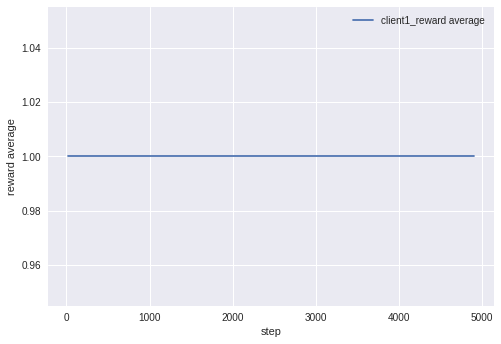

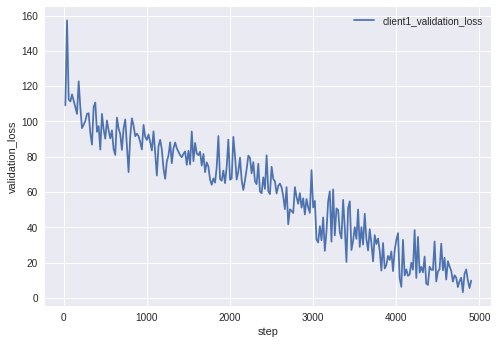

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4921
==== 4921 ====
おやすみ～
    [0]もぉ癖したわwww 
    [1]もぉ癖したから  
おはようございます。寒いですね。
    [0]💩www調べ、多分深だから…  
    [1]💩www調べ、多分深だから…w 
今回もよろしくです。
    [0]💩！     
    [1]💩やった💩💩☆ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)         
    [1]おつ！！💩復活てたけどぁぁやったん(笑) 
avg_reply_len=13.0
validation loss=14.2
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-4941
==== 4941 ====
おやすみ～
    [0]おかえりぇすぎてたもんwww 
    [1]おかえりかわいいすぎてたもんwww 
おはようございます。寒いですね。
    [0]いや、や……的だから😭😭💩💩↓               
    [1]いや、や……的だから😭😭💩💩アアですから↓からくれて何性行きました(💭) 
今回もよろしくです。
    [0]💩！                   
    [1]今日は後のこと桜のその気分なかも️💩さんににてくれた💩 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ˊᗜˋ^) 
avg_reply_len=19.2
validation loss=7.0
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotMod

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5001
==== 5001 ====
おやすみ～
    [0]美味かったわwww   
    [1]美味かったぜ(ˊᵕˋ) 
おはようございます。寒いですね。
    [0]いや、やばい……的だから…      
    [1]いや、やばい……的と知らないって感じたよw 
今回もよろしくです。
    [0]ほら(˙-˙) 
    [1]今日はほうです   
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)  
    [1]待ってるあ(๑﹏..`) 
avg_reply_len=12.8
validation loss=4.1
learning rate 0.5
msec/data=6.4


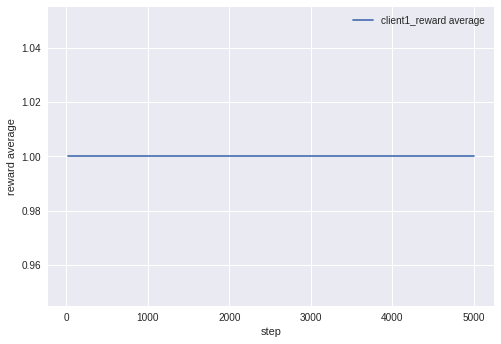

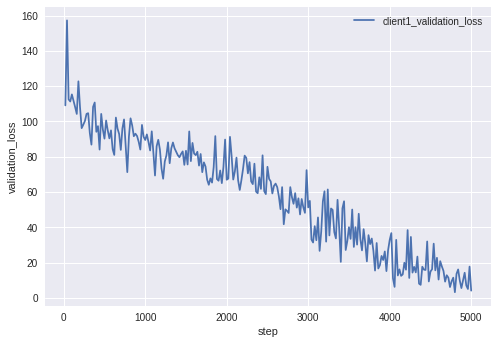

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5021
==== 5021 ====
おやすみ～
    [0]もぉ癖すぎたからwww 
    [1]美味かったよ！笑  
おはようございます。寒いですね。
    [0]💩www          
    [1]💩www調べ、💩から好きで💩てるwww 
今回もよろしくです。
    [0]やったねwww     
    [1]やったね(˘ω˘) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=12.2
validation loss=24.9
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5041
==== 5041 ====
おやすみ～
    [0]美味かったよ楽しみ(^ω^) 
    [1]美味かったよ楽しみ(･▽💩ﾉ 
おはようございます。寒いですね。
    [0]💩www                         
    [1]ありがとうございます！なかgt日ですからね！たら２組を切ったのですってのでないよ(ᐛ) 
今回もよろしくです。
    [0]やったね(ˇωˇ)  
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]これはあ！💩     
    [1]これはあ！(*ˊᗜˋ*) 
avg_reply_len=16.5
validation loss=7.6
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5061
==== 5061 ====
おやすみ～

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5101
==== 5101 ====
おやすみ～
    [0]美味かったわwww                    
    [1]美味かったわ！もう、💩💩の指は💩💩さん化（変わらして思い出したねwww 
おはようございます。寒いですね。
    [0]💩www                
    [1]ありがとうございます😊とりあえず💩ちゃんから一一合わせてさないことないない 
今回もよろしくです。
    [0]そして͡°】      
    [1]そして͡°͜ʖｳｵｫ！！！ 
ばいとおわ！
    [0]おつ！(*)         
    [1]おつ！！！💩ありがとよこのましたヤツ！！ 
avg_reply_len=19.0
validation loss=16.4
learning rate 0.5
msec/data=6.7


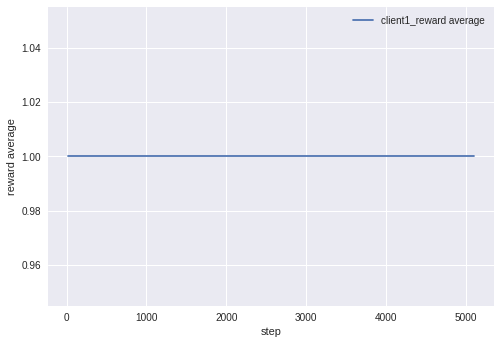

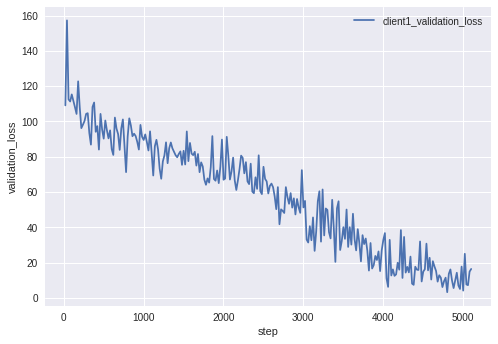

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5121
==== 5121 ====
おやすみ～
    [0]生き、いかがだよwww      
    [1]生き、いかがだよ…(^ω^) 
おはようございます。寒いですね。
    [0]ありがとう恥ずかしいですね、、、💩の曲ていい💩なんだよ、、どう-ます)       
    [1]ありがとう恥ずかしいですね、、、💩の曲ていい💩なんだよ、、どう-ます。んだよ(嬉しい） 
今回もよろしくです。
    [0]今日も見る💩ばかりに呼んでしょwww💩いっとる❗               
    [1]今日も見る💩ばかりに呼んれてみるとよくつけとるだけが見てた💩さんと違うん💩💩... 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！      
avg_reply_len=27.2
validation loss=22.1
learning rate 0.5
msec/data=7.1
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5141
==== 5141 ====
おやすみ～
    [0]生き💩ば、💩てこ 
    [1]生き💩ば、💩やな 
おはようございます。寒いですね。
    [0]ありがとうございます！でもお金家で💩www   
    [1]ありがとうございます！でもお金家で合わせていいwww 
今回もよろしくです。
    [0]今日は後かに言われるwww              
    [1]今日は後かに言われるのに兄に💩二💩4💩]にアカンして 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(***) 
avg_reply_len=17.8
validation loss=10.8
learning rate 0.5
msec/data=6.5
..................rewa

.........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5201
==== 5201 ====
おやすみ～
    [0]美味かっね～(･॑꒳･)                    
    [1]もぉ癖ても私でも死んじゃうかもの💩てだった（」だくらい、激ちだけなかも嬉しいwww 
おはようございます。寒いですね。
    [0]いや、やばい……を何とかしてた💩ですですですです💩がちん目た💩w     
    [1]いや、やばい……を何とかしてた💩ですですですです💩がほんと💩ですが(T`᷅) 
今回もよろしくです。
    [0]ほら、(•.`)って増えてね。💩の都合顔💩しそう!(˶ˆ꒳ˆ˵)  
    [1]ほら、(•.`)って増えてね。💩の都合顔💩しそう!(¨̮) 
ばいとおわ！
    [0]どうぞ！(*ˊᗜˋ*) 
    [1]どうぞ！(*﹏*) 
avg_reply_len=28.8
validation loss=9.1
learning rate 0.5
msec/data=6.9


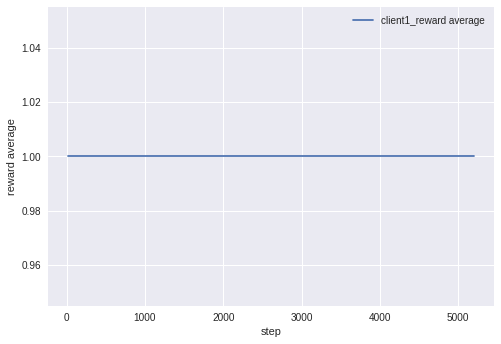

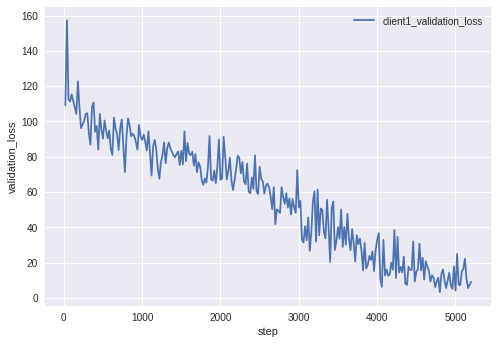

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5221
==== 5221 ====
おやすみ～
    [0]美味かっね       
    [1]もぉ癖ても私思ったwww 
おはようございます。寒いですね。
    [0]いや、5000💩かとをを💩てません                
    [1]いや、5000💩かとをを💩てません。とははいつも次が伏せた💩💩ば嬉しいにだ 
今回もよろしくです。
    [0]ほら(͜͡͡) 
    [1]今日も学校です   
ばいとおわ！
    [0]これはほうこ 
    [1]これはぜひ開始 
avg_reply_len=15.0
validation loss=2.1
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5241
==== 5241 ====
おやすみ～
    [0]もぉ癖にすぎたからwww    
    [1]もぉ癖にしてっから調べたwww 
おはようございます。寒いですね。
    [0]ありがとう恥ずかしいですねって子からから💩なwww  
    [1]ありがとう恥ずかしいですねって子からから💩なからね 
今回もよろしくです。
    [0]ほら(͜͡͡) 
    [1]ほら(°_ᵒ̴̶̷̣̥̀) 
ばいとおわ！
    [0]おこ！(*ˊᗜˋ*) 
    [1]おこ！(*﹏*) 
avg_reply_len=15.5
validation loss=7.9
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5261
==== 5261 ====

..reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5301
==== 5301 ====
おやすみ～
    [0]生き💩ば、💩が今朝        
    [1]生き💩ば、💩が変換全く情報に見つけたがwww 
おはようございます。寒いですね。
    [0]💩くんwww学校だからw    
    [1]💩くんwww💩そんな着ないとかめ← 
今回もよろしくです。
    [0]今日はほうかかもだけどコンビニ                 
    [1]今日はほうかかもだけどコンビニは難しいと入ってるやつでも今あってねーです(¨̮) 
ばいとおわ！
    [0]これはほう！                
    [1]これはあ！ちなみにねるねるこ('-')ありがとうございて💩💩(💩) 
avg_reply_len=21.8
validation loss=13.2
learning rate 0.5
msec/data=6.7


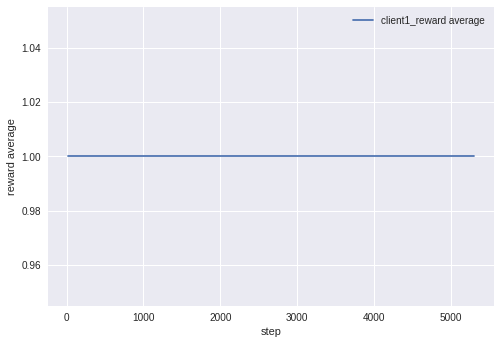

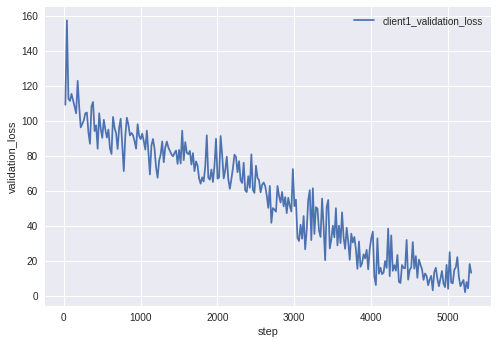

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5321
==== 5321 ====
おやすみ～
    [0]男だからーー   
    [1]男だからー許しω･`) 
おはようございます。寒いですね。
    [0]💩www  
    [1]💩くんwww 
今回もよろしくです。
    [0]やったね(´💩ω💩`) 
    [1]やったね(💩)     
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=9.5
validation loss=7.7
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5341
==== 5341 ====
おやすみ～
    [0]美味かった。     
    [1]美味かったば、ーです。 
おはようございます。寒いですね。
    [0]いや、5000はギリギリやばい……と思ってないよ   
    [1]いや、5000はギリギリやばい……と思ってないとですよ 
今回もよろしくです。
    [0]ほら(˙꒳​˙) 
    [1]ほら(˙꒳​・) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつかれなります     
avg_reply_len=14.5
validation loss=10.8
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5361
==== 5361 ====
おやすみ～
    [0]おかえり！      
    [1]男だからー♪(´ω･`) 
おはようございます。寒

おはようございます。寒いですね。
    [0]いや、や……怖い💩☺感じでめ💩たらめのたちにしてものががどうがどうたたどう嫌
    [1]いや、や……怖い💩☺感じでめ💩たらめのたちにしてものががどうがどうたたどう…
今回もよろしくです。
    [0]やった(˘ω˘) 
    [1]今日は💩うね☺️ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=8.2
learning rate 0.5
msec/data=6.5


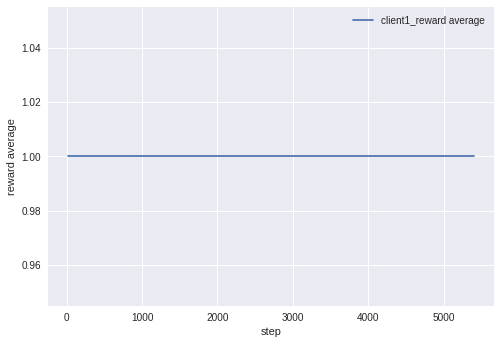

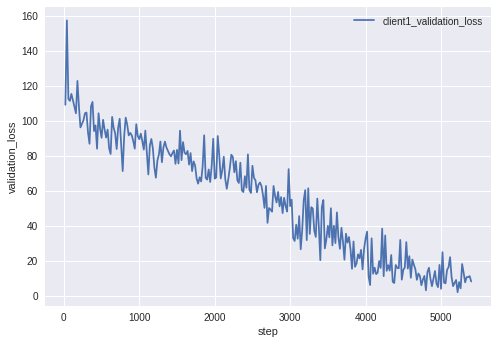

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5421
==== 5421 ====
おやすみ～
    [0]美味かっな。   
    [1]もぉ癖だからwww 
おはようございます。寒いですね。
    [0]ありがとう️です……ケーキで家で好きな顔で好きだし💦ってくらいあるた全くどや 
    [1]ありがとう️です……ケーキで家で好きな顔で好きだし💦ってくらいあるた太どや 
今回もよろしくです。
    [0]やった(˘ω˘)ｽﾔｧ……       
    [1]やった(˘ω˘)ｽﾔｧ…˘れるとこんな運動です！ 
ばいとおわ！
    [0]おつ！(*) 
    [1]おつかれなりたら   
avg_reply_len=18.8
validation loss=10.0
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5441
==== 5441 ====
おやすみ～
    [0]もぉ癖にしんどいな笑    
    [1]もぉ癖にしんどいな（9すぎるwww 
おはようございます。寒いですね。
    [0]えー常に的って感じや奴だ💩？   
    [1]えー常に的って感じや奴だ💩が知らない 
今回もよろしくです。
    [0]💩やったからねwww 
    [1]💩やったねね！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)  
    [1]おつかれなりたら(¨​*) 
avg_reply_len=13.5
validation loss=6.9
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-54

.......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5501
==== 5501 ====
おやすみ～
    [0]もぉシーンだからwww                
    [1]生き💩ば、💩ても怖いの子の💩がちょっとやすいって💩ましたww 
おはようございます。寒いですね。
    [0]いや、5000わからないとやな                  
    [1]いや、5000わからないと思ってた💩ωですね、これは可哀想だからかしらかしらかもいるなな 
今回もよろしくです。
    [0]やった       
    [1]やった💩(💩ω💩) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ˊᗜˋます) 
avg_reply_len=20.2
validation loss=3.8
learning rate 0.5
msec/data=6.7


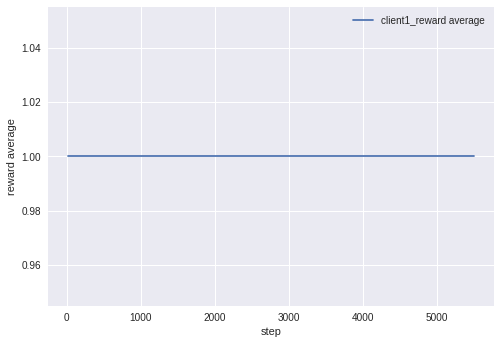

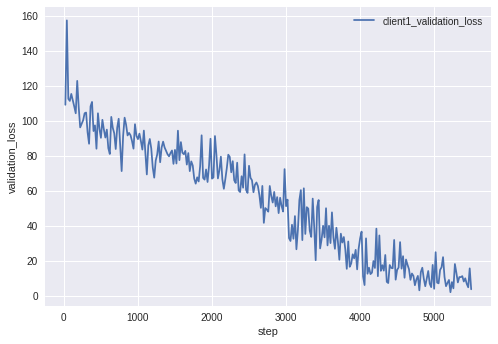

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5521
==== 5521 ====
おやすみ～
    [0]もぉシーンだからwww 
    [1]もぉシーン、あ！ 
おはようございます。寒いですね。
    [0]いや、常にわから的のかなたですがです(˙˙) 
    [1]いや、常にわから的のかなたですよ、     
今回もよろしくです。
    [0]やった      
    [1]やった(˘ω˘) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=13.8
validation loss=4.6
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5541
==== 5541 ====
おやすみ～
    [0]美味かっ💩、、💩やな      
    [1]美味かっ💩、、、💩やったぃぃ！！！ 
おはようございます。寒いですね。
    [0]んな？      
    [1]んな常に的だからな！ 
今回もよろしくです。
    [0]やった(˘ω˘)       
    [1]やった💩(💩ω💩)💩💩˘」) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ま*) 
avg_reply_len=12.8
validation loss=9.2
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5561
==== 5561 ====
おやすみ～
    [0]美味かっだよ、もう💩('-')    
    [1]美味かっだよ、

...reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5601
==== 5601 ====
おやすみ～
    [0]もぉりんすぎすぎたwww       
    [1]男だから、もう33食べてないなwww 
おはようございます。寒いですね。
    [0]いや、5000わからとき的と作ったら食べたかってんだよ、お金ゆうとはかしらってんかもん 
    [1]いや、5000わからとき的と作ったら食べたかってんだよ、お金ゆうとはかしらたん嫌  
今回もよろしくです。
    [0]そして͡°の；】  
    [1]そして͡°の；ｳｵｫwww 
ばいとおわ！
    [0]どうぞ！       
    [1]おつ！(*ま*) 
avg_reply_len=21.0
validation loss=12.8
learning rate 0.5
msec/data=6.5


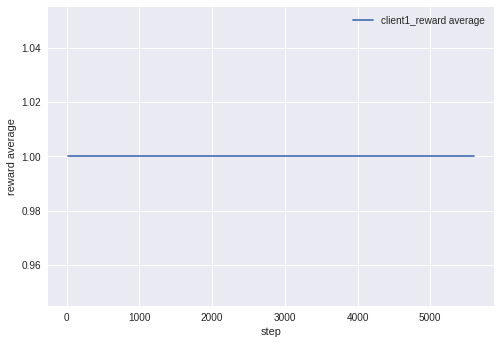

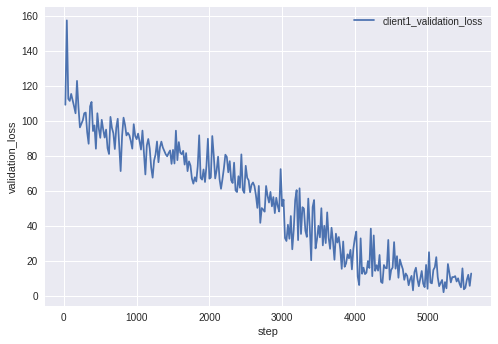

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5621
==== 5621 ====
おやすみ～
    [0]もぉ癖があ(˘ω˘)      
    [1]男だから、もう知ってみて💦何やわwww 
おはようございます。寒いですね。
    [0]んな？            
    [1]いや、5000わからとき的の事無いでです、お金w 
今回もよろしくです。
    [0]やったね(˘ω˘) 
    [1]やったね(´.`) 
ばいとおわ！
    [0]どうぞ！       
    [1]おつ！(*ま!!) 
avg_reply_len=13.0
validation loss=10.1
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5641
==== 5641 ====
おやすみ～
    [0]もぉ癖だからwww  
    [1]男、懐かしを…w 
おはようございます。寒いですね。
    [0]いや、5000わからませと辛い！           
    [1]いや、5000わからかかわからん💩的ですよいいらははだよ 
今回もよろしくです。
    [0]やった！！！                   
    [1]やった！！！！ええええてるうちにいる💩！！wwwwこれだけ？？💩 
ばいとおわ！
    [0]おつ！(*ま!!)  
    [1]おつ！(*ま۶!!) 
avg_reply_len=18.5
validation loss=10.1
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-

......reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5701
==== 5701 ====
おやすみ～
    [0]もぉ癖だからwww      
    [1]生き、普通の普通に置いてたわ 
おはようございます。寒いですね。
    [0]んな？                        
    [1]いや、学校……ケーキで家の💩なくからなんだ、、かしらゆうたくのあった！(ので的 
今回もよろしくです。
    [0]やった(´´•`)       
    [1]やったね！今日💩たんこと人だけどなwww 
ばいとおわ！
    [0]どうぞ！(*ˊᗜˋ*)  
    [1]おつ！(*ˊᗜˋ*) 
avg_reply_len=17.8
validation loss=7.8
learning rate 0.5
msec/data=6.6


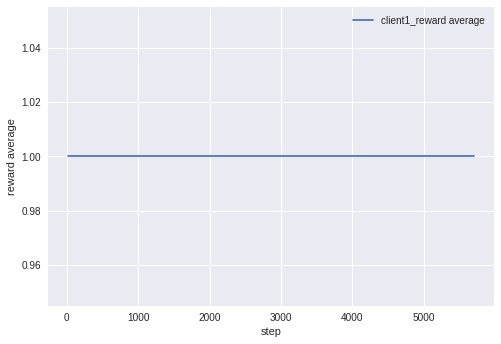

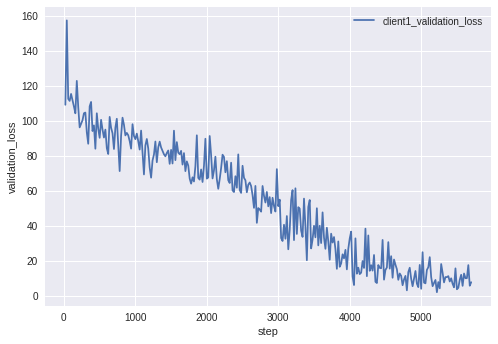

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5721
==== 5721 ====
おやすみ～
    [0]生き💩ば、💩て食べて 
    [1]生き💩ば、💩てこ  
おはようございます。寒いですね。
    [0]ありがとうございます😊                  
    [1]ありがとうございます😊……💩💩なから食べてもう頭から好きって感じれました 
今回もよろしくです。
    [0]やった(´.`)  
    [1]やったね(´.`) 
ばいとおわ！
    [0]これちゃんーい   
    [1]これちゃん！(💩) 
avg_reply_len=15.0
validation loss=12.5
learning rate 0.5
msec/data=6.8
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5741
==== 5741 ====
おやすみ～
    [0]もぉ癖だからwww   
    [1]もぉ癖だからってあるwww 
おはようございます。寒いですね。
    [0]いや、5000💩かな💩www          
    [1]いや、5000💩かなと知らないとです、イベント(´💩) 
今回もよろしくです。
    [0]やった(´.`)  
    [1]やったね(´.`) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*)  
    [1]おつ！(**ま💩) 
avg_reply_len=14.5
validation loss=8.1
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5761
==== 5761 ====
おやすみ～
 

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5801
==== 5801 ====
おやすみ～
    [0]もぉ癖になったからwww 
    [1]もぉ癖になったわwww 
おはようございます。寒いですね。
    [0]ありがとうございますwww      
    [1]ありがとうございます！(◜💩`アアwww 
今回もよろしくです。
    [0]やったね(💩💩💩) 
    [1]やったね(´💩`) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(**)  
avg_reply_len=13.2
validation loss=10.4
learning rate 0.5
msec/data=6.4


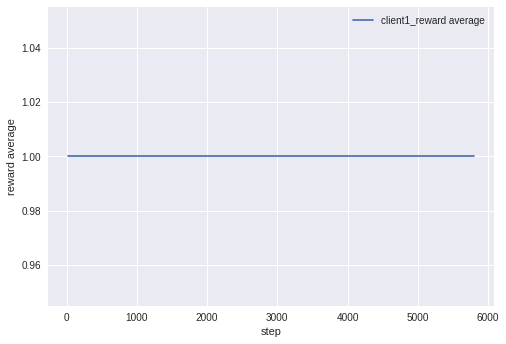

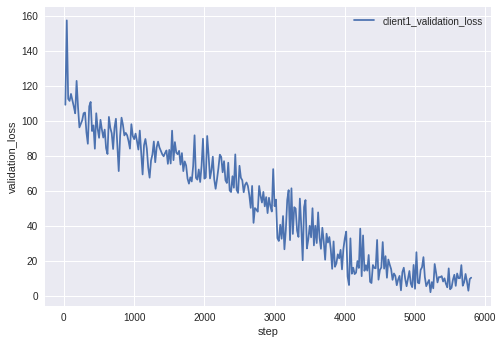

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5821
==== 5821 ====
おやすみ～
    [0]もぉ癖になってるからwww 
    [1]もぉ癖になったからwww 
おはようございます。寒いですね。
    [0]ありがとうございます😊  
    [1]ありがとうございます😊! 
今回もよろしくです。
    [0]💩やった...www  
    [1]💩やったねねwww 
ばいとおわ！
    [0]おつ！(**)  
    [1]おつ！(***) 
avg_reply_len=12.0
validation loss=9.8
learning rate 0.5
msec/data=6.7
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5841
==== 5841 ====
おやすみ～
    [0]もぉ癖すぎたからwww 
    [1]もぉりん💩すぎて笑う 
おはようございます。寒いですね。
    [0]ありがとうございますwww                       
    [1]ありがとうございます‼嫌に見てないですですね！夏꒳切っては可哀想ですね！！！！！ 
今回もよろしくです。
    [0]やったね！💩くん兄さんページ      
    [1]やったね！💩くん兄さんページを行けないねwww 
ばいとおわ！
    [0]これはほう！                
    [1]おつ！(๑ˊᗜˋᵕ)وこの💩顔するの思ったら💩です！ 
avg_reply_len=22.5
validation loss=13.6
learning rate 0.5
msec/data=6.6
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/C

.....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5901
==== 5901 ====
おやすみ～
    [0]もぉりん…すぎすぎだもんwww 
    [1]もぉりん…すぎすぎたわwww 
おはようございます。寒いですね。
    [0]えー、どう💩か奴のにのだと思うんちゃの、あれののがだん  
    [1]えー、どう💩か奴のにのだと思うんちゃの、あれののがだのな 
今回もよろしくです。
    [0]ほら(ˇωˇ)  
    [1]ほら(•💩̀᷅) 
ばいとおわ！
    [0]おつ！      
    [1]おつ！(*ˊᗜˋ*) 
avg_reply_len=15.8
validation loss=10.2
learning rate 0.5
msec/data=6.5


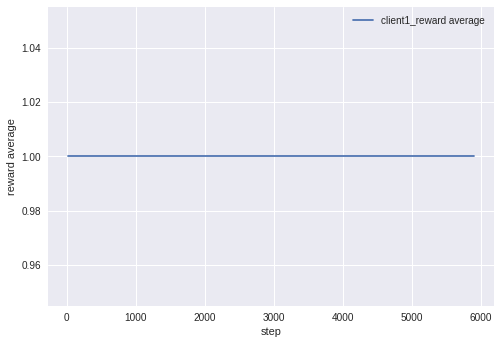

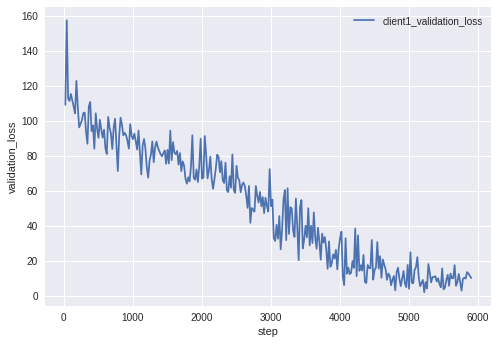

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5921
==== 5921 ====
おやすみ～
    [0]もぉりんすぎすぎたwwwwww 
    [1]美味かったよ…笑  
おはようございます。寒いですね。
    [0]えー、これ💩か奴のにのたちへ事でいいよ                
    [1]えー、これ💩か奴のにのたちへ事でいいんない、もない💩ががないしんの分から(ᐛ௰ 
今回もよろしくです。
    [0]今日は絶対どうに💩の上を見えてたからバレとええよ(¨̮)  
    [1]今日は絶対どうに💩の上を見えてたからバレとええよ(・॑꒳◝) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=23.0
validation loss=5.1
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-5941
==== 5941 ====
おやすみ～
    [0]おかえり、今💩ここwww 
    [1]おかえり、今💩！  
おはようございます。寒いですね。
    [0]ありがとうございます！宜しく💩なから家ならただってあってもいいって見ます 
    [1]ありがとうございます！宜しく💩なから家ならただってあってももうあったた 
今回もよろしくです。
    [0]💩！   
    [1]今日は学校！ 
ばいとおわ！
    [0]待っ、ほう、💩www   
    [1]おつ！(*ˊᗜˋ^) 
avg_reply_len=17.0
validation loss=6.6
learning rate 0.5
msec/data=6.3
..................reward average=1.0
.INFO:tensorflow:Restoring paramete

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6001
==== 6001 ====
おやすみ～
    [0]美味かったよ…(^ω^) 
    [1]美味かったよねもう中身    
おはようございます。寒いですね。
    [0]ん魅力え💩的のしないですですですでは💩のあるのです    
    [1]ん魅力え💩的のしないですですですですがイベント💩て何ですがです… 
今回もよろしくです。
    [0]では💩www 
    [1]ではか！ 
ばいとおわ！
    [0]これちゃんありがと！！！💩さんはたです(¨̮) 
    [1]これちゃんありがと！！！💩さんはたです(̮͡) 
avg_reply_len=18.2
validation loss=3.3
learning rate 0.5
msec/data=6.5


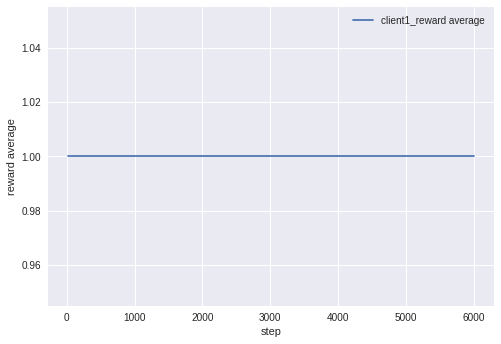

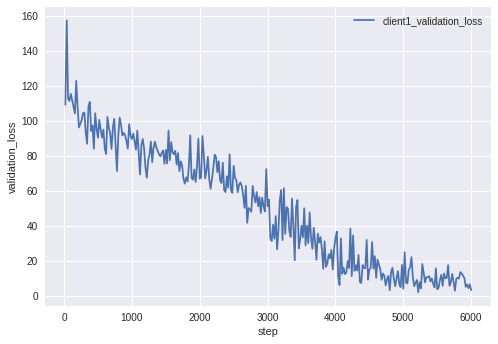

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6021
==== 6021 ====
おやすみ～
    [0]美味かったよ(^ω^)  
    [1]美味かったよ(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
おはようございます。寒いですね。
    [0]えー、5000💩かとを💩てしれますとです、、お金💩のもだのだ        
    [1]えー、5000💩かとを💩てしれますとです、、お金💩のもだのだ使いだん嬉しいかもんん 
今回もよろしくです。
    [0]やった(´.`)  
    [1]やった(´💩ω`) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(💩)   
avg_reply_len=18.0
validation loss=6.9
learning rate 0.5
msec/data=7.0
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6041
==== 6041 ====
おやすみ～
    [0]生きすぎwww     
    [1]もぉ癖、寝すぎ…。 
おはようございます。寒いですね。
    [0]いや、5000💩ちゃんと知ら💩www   
    [1]いや、5000💩ちゃんと知ら💩💩のに! 
今回もよろしくです。
    [0]やった(´💩ω`)  
    [1]やった(´💩ω💩`) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=13.8
validation loss=3.3
learning rate 0.5
msec/data=6.4
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6061
=

........reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6101
==== 6101 ====
おやすみ～
    [0]おかえり、懐かしいく(˘ω˘) 
    [1]おかえり、今今💩💩💩？？ 
おはようございます。寒いですね。
    [0]ん魅力5000💩💩www   
    [1]ん魅力5000💩💩ってめwww 
今回もよろしくです。
    [0]やった！！www  
    [1]やった！！！www 
ばいとおわ！
    [0]おつかれなります     
    [1]おつ！(*ˊᗜˋ*) 
avg_reply_len=13.5
validation loss=6.8
learning rate 0.5
msec/data=6.3


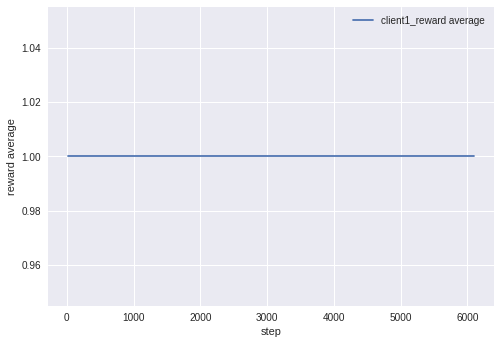

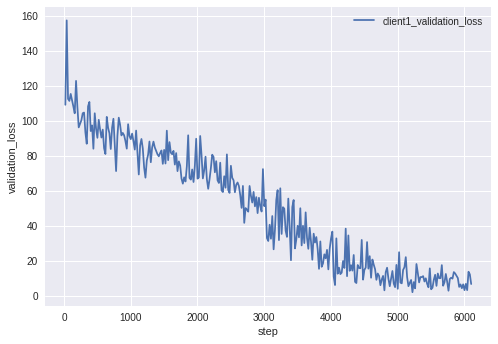

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6121
==== 6121 ====
おやすみ～
    [0]美味かったよぉ(^ω^) 
    [1]美味かったぜ(ˊᵕˋ)    
おはようございます。寒いですね。
    [0]💩www                      
    [1]ん魅力...ちゃんって無かったら感じですね！！うそゆうゆうゆうのですにかしら！！www 
今回もよろしくです。
    [0]やったね！💩💩止めからwww       
    [1]やったね！💩💩さん気に応援してもらったwww 
ばいとおわ！
    [0]おつ！      
    [1]おつ！(*ˊᗜˋ*) 
avg_reply_len=17.2
validation loss=8.9
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6141
==== 6141 ====
おやすみ～
    [0]美味かったねぇ(ˊᵕˋ)   
    [1]美味かったよ…💩ーだwww 
おはようございます。寒いですね。
    [0]んだ奴だね…だ💩だで😭😭💩らが💩💩💩にもも来の感じてるwww 
    [1]んだ奴だね…だ💩だで😭😭💩らが💩💩💩にもも来た出来w  
今回もよろしくです。
    [0]でやったwww      
    [1]やった(´💩ω💩`) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(**)  
avg_reply_len=17.5
validation loss=7.3
learning rate 0.5
msec/data=6.5
..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_

....reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6201
==== 6201 ====
おやすみ～
    [0]美味かったよねwww 
    [1]美味かったよwww  
おはようございます。寒いですね。
    [0]ありがとうございます😊💩💩☺️な💩アア      
    [1]ありがとうございます😊💩💩☺️だから!!！イベントがいい！ 
今回もよろしくです。
    [0]やったね！💩💩さん💩！       
    [1]やったね！💩💩止めから可愛いから呼ばやってもらえるな 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ˊᗜˋ^) 
avg_reply_len=16.2
validation loss=12.4
learning rate 0.5
msec/data=6.4


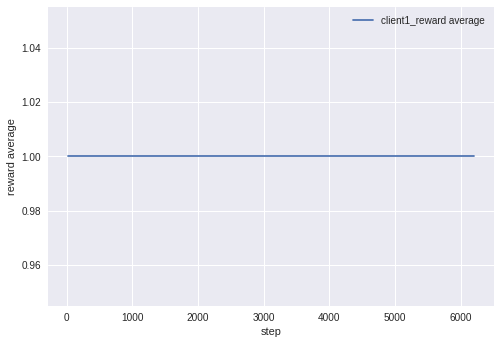

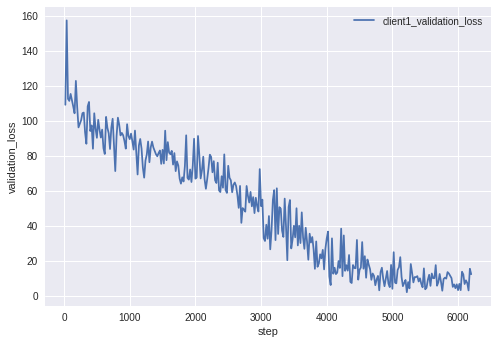

..................reward average=1.0
.INFO:tensorflow:Restoring parameters from model/tweet_large/ChatbotModel-6221
==== 6221 ====
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
    [1]美味かっだよね(^o^)  
おはようございます。寒いですね。
    [0]んの5000のどう上と💩ですけど、  
    [1]んの5000のどう上と💩ですよ、、 
今回もよろしくです。
    [0]やったね(˙꒳​˙)       
    [1]やったね！今日からお金日とましたけど☺️ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(¨̮)💩 
avg_reply_len=19.8
validation loss=2.4
learning rate 0.5
msec/data=6.9
..................reward average=1.0
.rm: cannot remove 'model/tweet_large_rl/*': No such file or directory
===== Train RL tweets_medium.txt ====
src:
{'machine': 'client1', 'batch_size': 64, 'num_units': 512, 'num_layers': 2, 'vocab_size': 5000, 'embedding_size': 256, 'learning_rate': 0.5, 'learning_rate_decay': 0.99, 'use_attention': True, 'encoder_length': 30, 'decoder_length': 30, 'max_gradient_norm': 5.0, 'beam_width': 0, 'num_train_steps': 6240, 'model_path': 'model/tweet_large'}
dst
{'machine': 'client1', 'batch_size': 64, 'num_units': 512

....reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6262
==== 6262 ====
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
    [1]美味かっだよね(^o^)  
おはようございます。寒いですね。
    [0]んの5000の💩を隠れて忘れそう、いい、普通でもう💩であるのだ 
おはようございます。寒いですね。
    [0]んの5000なと知ら💩みるですですですですよ、、もしもんんですよ、、？     
    [1]んの5000なと知ら💩みるですですですですよ、、あたしののが何感じのですってない💩です 
今回もよろしくです。
    [0]やったね！💩15買いことしてあげる！ 
今回もよろしくです。
    [0]やったね！今日の15！  
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(¨̮)💩 
avg_reply_len=23.5
validation loss=2.8
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6282
==== 6282 ====
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
    [1]美味かっだよね(^o^)  
おはようございます。寒いですね。
    [0]んの5000の💩を隠れて忘れそう、いい、普通であるで、多分これだた、な(ᐛか 
おはようございます。寒いですね。
    [0]んの5000なと可愛いとやばい！         

おはようございます。寒いですね。
    [0]んの5000の💩を駅の調べない奴のに、でもは何のもだんだよ、、どうんよ 
おはようございます。寒いですね。
    [0]んの5000なと可愛いとやばい！                 
    [1]んの5000なと知ら💩みるですね、イベントさんのただのただに何ないんみたいなさです 
今回もよろしくです。
    [0]やったね！💩15買いことしてあげる！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ˊᗜˋ^) 
avg_reply_len=24.5
validation loss=2.6
learning rate 0.1
msec/data=9.4


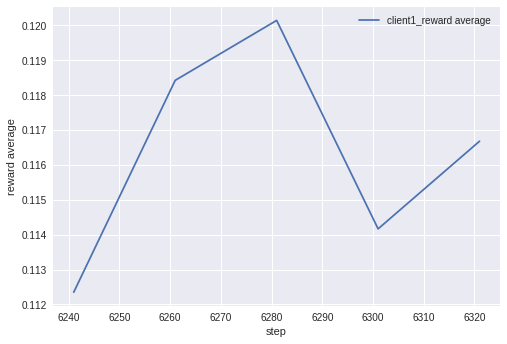

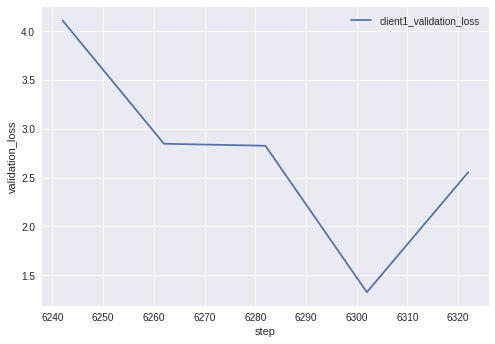

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6342
==== 6342 ====
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
    [1]美味かっだよね(^o^)  
おはようございます。寒いですね。
    [0]んの5000の💩を駅の調べない奴のに、でもは何のもだんだな 
おはようございます。寒いですね。
    [0]んの5000なと可愛いとやばい！          
    [1]んの5000なと気づいてみる💩なのですね...(・💩`) 
今回もよろしくです。
    [0]やったね！💩15買いことしてあげる！ 
今回もよろしくです。
    [0]やったね！今日の焼肉で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*ˊᗜˋ^) 
avg_reply_len=23.0
validation loss=1.7
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6362
==== 6362 ====
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
おやすみ～
    [0]美味かっだよね(^o^)＜ﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝﾝwww 
    [1]美味かっだよね(^o^)  
おはようございます。寒いですね。
    [0]んの5000の💩を駅の調べないなんて、、お金「何のももういやw 
おはようございます。寒いですね。
    [0]んの5000なと気づいてみる💩なのですね...(・💩`) 
    [1]んの5000なと気づ

    [0]美味かったよね！www                
    [1]美味かったよね、もうもっちゃんもって、💩がとても💩💩してみてた 
おはようございます。寒いですね。
    [0]んの5000の💩を駅の調べないなんて、、お金「何の、何をないのを嬉しい💩💩 
おはようございます。寒いですね。
    [0]んの5000なと気づいてみる💩なですですでちんんって        
    [1]んの5000なと気づいてみる💩なですですでちんん…がちんんんも起きてるん 
今回もよろしくです。
    [0]やったね！今日の以降日！ 
今回もよろしくです。
    [0]やったね！今日の焼肉で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=23.5
validation loss=1.1
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6422
==== 6422 ====
おやすみ～
    [0]美味かったよね、もうもっちゃんもって、💩がとても💩💩してみましたよ✋️ 
おやすみ～
    [0]美味かったよね！www                   
    [1]美味かったよね、もうもっちゃんもって、💩がとても💩💩してみましたよ✋️ 
おはようございます。寒いですね。
    [0]んの5000の💩を駅の調べないなんて、、お金「何のの、何ある💩ががどう想像したかけど
おはようございます。寒いですね。
    [0]ありがとうございます😊💩な!を家は💩って感じなんですな  
    [1]ありがとうございます😊💩な!を家は💩って感じなんですな。 
今回もよろしくです。
    [0]やったね！今日の以降日！ 
今回もよろしくです。
    [0]やったね！今日の焼肉で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(

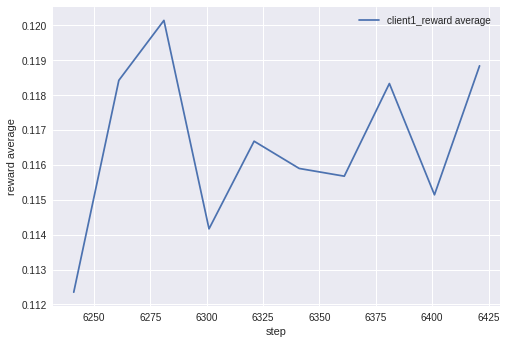

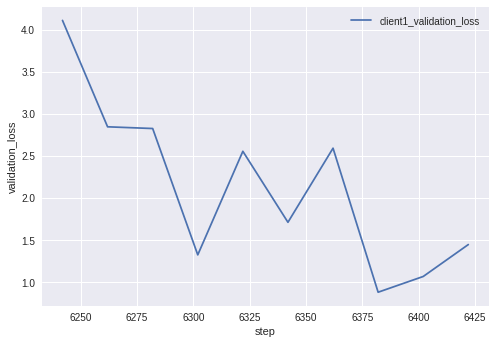

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6442
==== 6442 ====
おやすみ～
    [0]美味かったよね、もうもっちゃんもって、💩がとても💩💩してみましたよ✋️ 
おやすみ～
    [0]美味かったよねwww                    
    [1]美味かったよね、もうもっちゃんもって、💩がとても💩💩してみましたよ✋️ 
おはようございます。寒いですね。
    [0]んの5000の💩を駅の調べないなんて、、お金「何のの嬉しい、がよって感じたな嬉しいな欲しい(
おはようございます。寒いですね。
    [0]ありがとうございます😊💩な!を家は💩からめてこんな感じないんだろと   
    [1]ありがとうございます😊💩な!を家は💩からめてこんな感じないんないなたらW 
今回もよろしくです。
    [0]やったね！今日の以降日！ 
今回もよろしくです。
    [0]やったね！今日の焼肉で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=26.5
validation loss=0.8
learning rate 0.1
msec/data=10.0
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6462
==== 6462 ====
おやすみ～
    [0]美味かったよね、もうもっちゃんもって、💩がとても💩💩してみましたね✋️ 
おやすみ～
    [0]美味かったよねwww                    
    [1]美味かったよね、もうもっちゃんもって、💩がとても💩💩してみましたね✋️ 
おはようございます。寒いですね。
    [0]んの5000の💩を駅の調べないなんて、、お金「何のの嬉しい

INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6502
==== 6502 ====
おやすみ～
    [0]美味かったよね、もうもっちゃんもって、💩がとても💩💩さんておりましたね✋✋) 
おやすみ～
    [0]美味かったよねwww                     
    [1]美味かったよね、もうもっちゃんもって、💩がとても💩💩さんておりましたね✋✋) 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよΣw 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩なんだよねれるw  
    [1]んの5000なと気づいたらみるですよ、イベント💩なんだよね見てw 
今回もよろしくです。
    [0]やったね！今日の以降日！ 
今回もよろしくです。
    [0]やったね！今日の焼肉で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=24.2
validation loss=1.0
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6522
==== 6522 ====
おやすみ～
    [0]美味かったよね、もうもっちゃんもって、💩がとても番に💩てくれたんですwww 
おやすみ～
    [0]美味かったよねwww                   
    [1]美味かったよね、もうもっちゃんもって、💩がとても番に💩てくれたんですwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよΣw 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるです

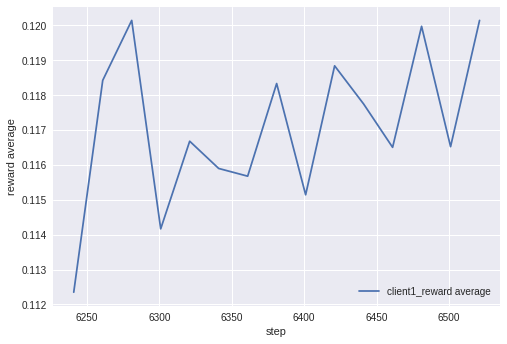

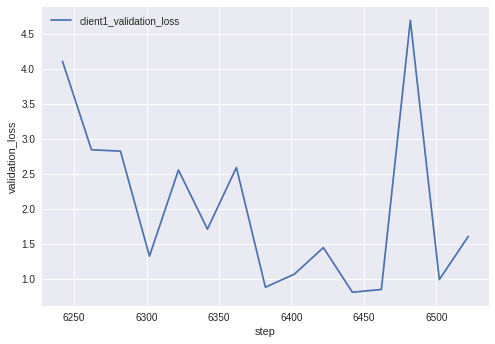

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6542
==== 6542 ====
おやすみ～
    [0]美味かったよね、もうもっとかもってみて💩💩 
おやすみ～
    [0]美味かったよねwww          
    [1]美味かったよね、もうもっとかもってみて💩💩 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよΣw 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩なんだよね見てw 
    [1]んの5000なと気づいたらみるですよ、イベント💩があるのですよΣw  
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=20.0
validation loss=0.9
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6562
==== 6562 ====
おやすみ～
    [0]美味かったよね、もうもっとかもってみて💩💩 
おやすみ～
    [0]美味かったよねwww          
    [1]美味かったよね、もうもっとかもってみて💩💩 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよΣw 
おはようございます。寒いですね。
    [0]ありがとうございます😊💩な!を家は💩からめてこんな感じないんだろと 
    [1]んの5000なと気づいたらみるですよ、イベン

    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよΣw  
    [1]んの5000なと気づいたらみるですよ、イベント💩なんだよね見てw 
今回もよろしくです。
    [0]やったね！今日の以降日！ 
今回もよろしくです。
    [0]やったね！今日の焼肉で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=1.2
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6622
==== 6622 ====
おやすみ～
    [0]美味かったよねwww 
おやすみ～
    [0]美味かったよねwww          
    [1]美味かったよね、もうもっとかもってみて💩💩 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？          
    [1]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
今回もよろしくです。
    [0]やったね！今日の以降日！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=1.0
learning rate 0.1
msec/data=9.4


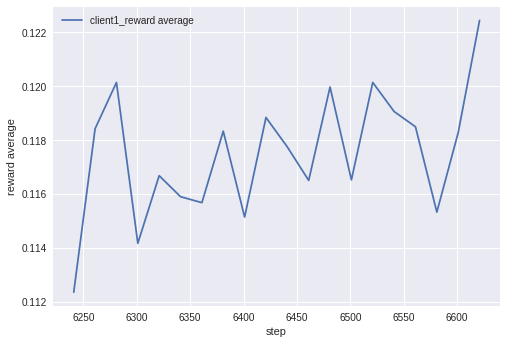

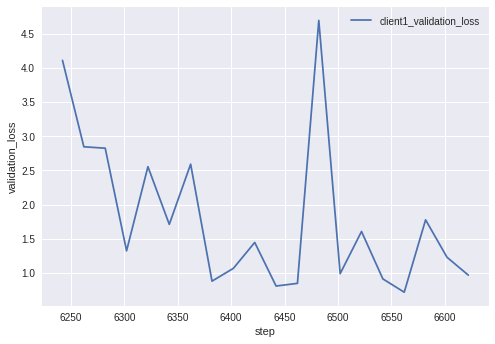

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6642
==== 6642 ====
おやすみ～
    [0]美味かったよねwww 
おやすみ～
    [0]美味かったよねwww          
    [1]美味かったよね、もうもっとかもってみて💩💩 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？          
    [1]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
今回もよろしくです。
    [0]やったね！今日の以降日！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の以降日！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.7
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6662
==== 6662 ====
おやすみ～
    [0]美味かったよねwww 
おやすみ～
    [0]美味かったよねwww          
    [1]美味かったよね、もうもっとかもってみて💩💩 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのです      
    [1]んの5000なと気づいたらみるですよ、イベント💩があるので

ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.5
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6722
==== 6722 ====
おやすみ～
    [0]美味かったよねwww 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？          
    [1]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の焼肉で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.3
learning rate 0.1
msec/data=9.3


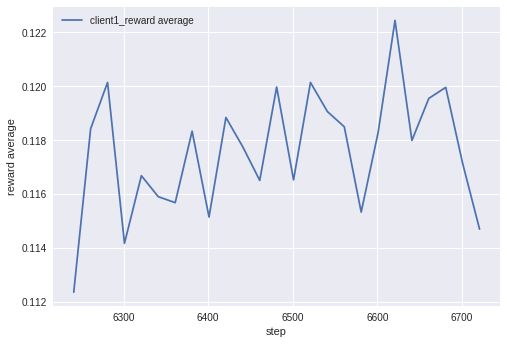

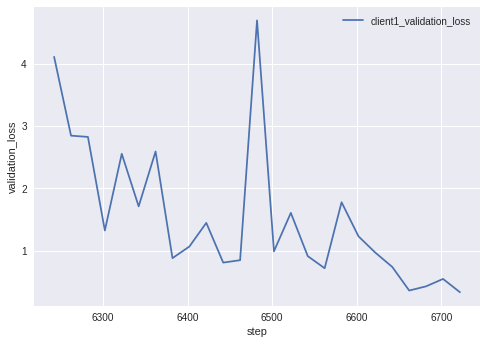

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6742
==== 6742 ====
おやすみ～
    [0]美味かったよねwww 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？          
    [1]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の焼肉で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.9
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6762
==== 6762 ====
おやすみ～
    [0]美味かったよねwww 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内があるのある) 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回

    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.8
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6822
==== 6822 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内があるのある) 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の焼肉で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.6
learning rate 0.1
msec/data=9.5


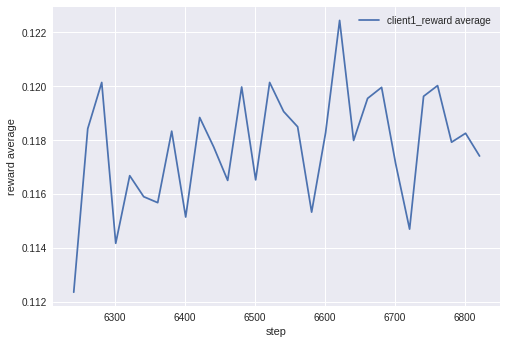

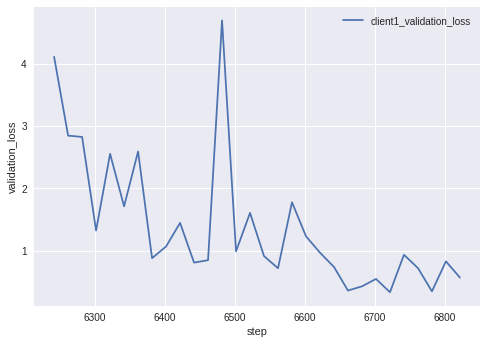

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6842
==== 6842 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内があるのある) 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の焼肉で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6862
==== 6862 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内があるのある) 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろ

    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内があるのある) 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=1.3
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6922
==== 6922 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の焼肉で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.5
learning rate 0.1
msec/data=9.4


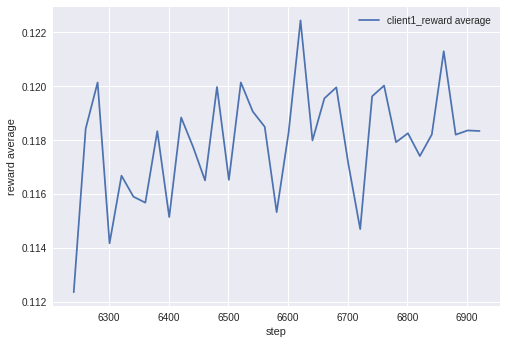

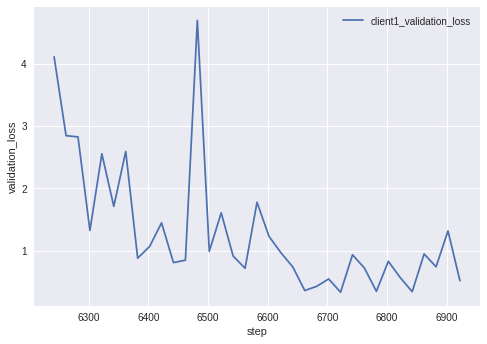

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6942
==== 6942 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
    [1]やったね！今日の焼肉で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=2.4
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-6962
==== 6962 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0

    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.2
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7022
==== 7022 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.3
learning rate 0.1
msec/data=9.3


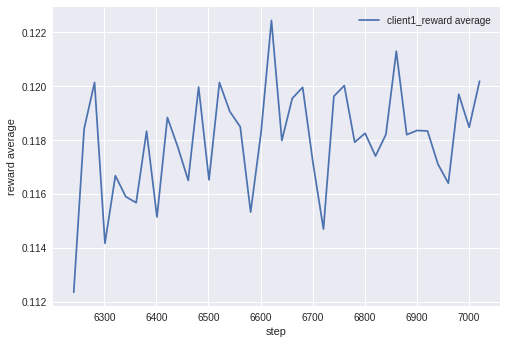

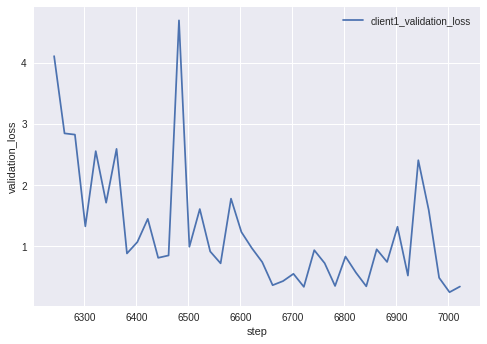

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7042
==== 7042 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=1.5
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7062
==== 7062 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0

今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.7
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7122
==== 7122 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.6
learning rate 0.1
msec/data=9.4


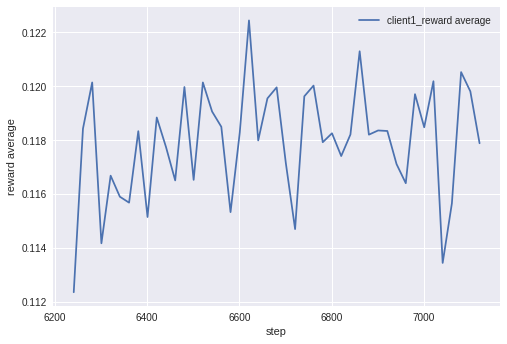

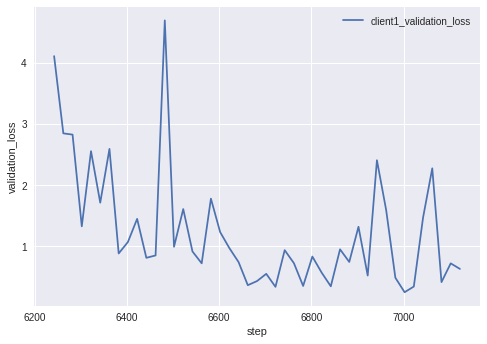

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7142
==== 7142 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねwww  
    [1]美味かったよねもう♪ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=18.5
validation loss=0.7
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7162
==== 7162 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪   
    [1]美味かったよねもう^ω3 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみるですよ、イベント💩があるのですよしょうがんんよ 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
   

    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.0
validation loss=0.6
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7222
==== 7222 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪   
    [1]美味かったよねもう^ω3 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね… 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.0
validation loss=0.5
learning rate 0.1
msec/data=9.4


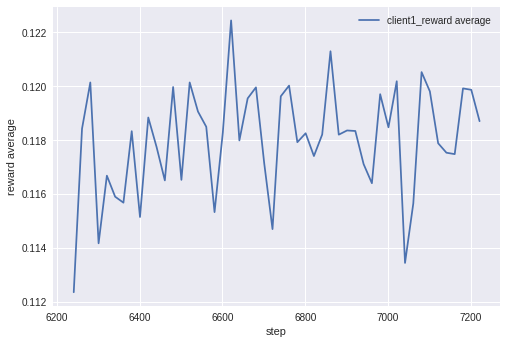

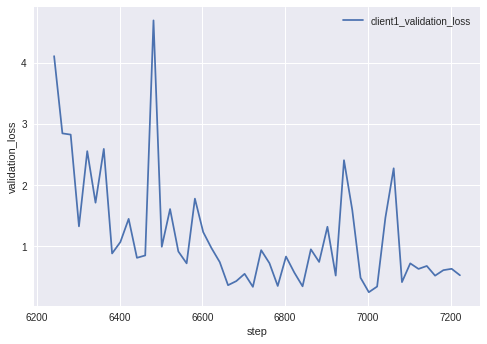

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7242
==== 7242 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪   
    [1]美味かったよねもう^ω3 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね… 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！今日の以降で！ 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.0
validation loss=0.6
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7262
==== 7262 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪   
    [1]美味かったよねもう^ω3 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね… 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？            
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですめっちゃ嫌💩ないん 
今回もよろしくです。
    [0]やったね！

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7322
==== 7322 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪    
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね… 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？                
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も綺麗で綺麗でない💩💩💩落ちないwww 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.0
validation loss=0.7
learning rate 0.1
msec/data=9.3


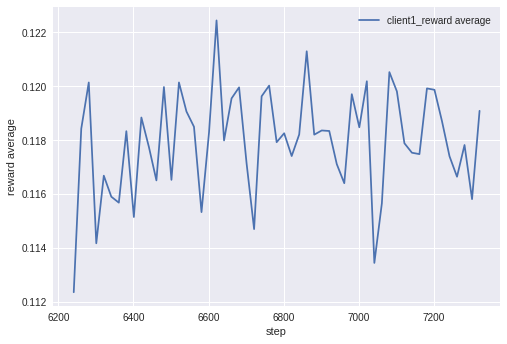

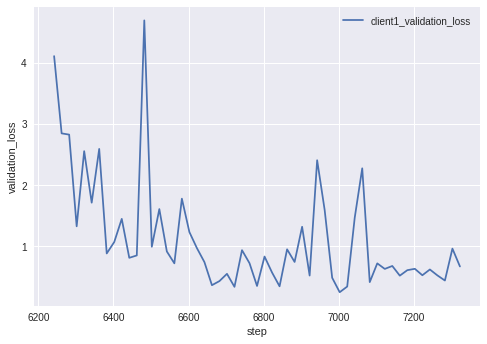

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7342
==== 7342 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪    
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですねw 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www     
    [1]やったね！今日の以降で！ 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7362
==== 7362 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪    
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね… 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですねw 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7422
==== 7422 ====
おやすみ～
    [0]美味かったよねもう♪ 
おやすみ～
    [0]美味かったよねもう♪    
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？                
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も綺麗で綺麗でない💩💩💩落ちないwww 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www         
    [1]やったね！💩くん買いこと💩あげるからな💩 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.4
learning rate 0.1
msec/data=9.5


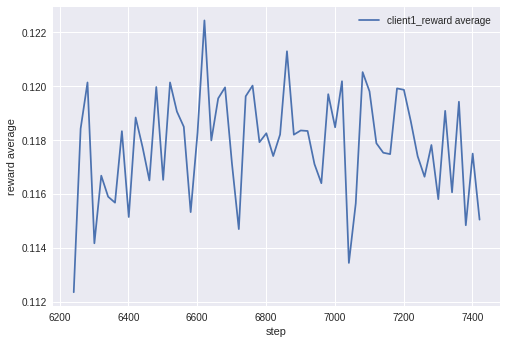

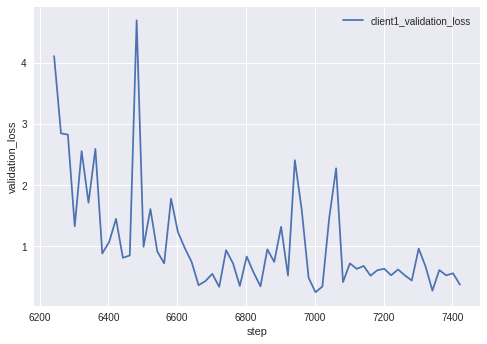

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7442
==== 7442 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、    
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですねw 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www         
    [1]やったね！💩くん買いこと💩あげるからな💩 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.2
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7462
==== 7462 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、    
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？                
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も綺麗で綺麗でない💩💩💩落ちないwww 


    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.5
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7522
==== 7522 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう💩だけどwww 
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですねw 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.4


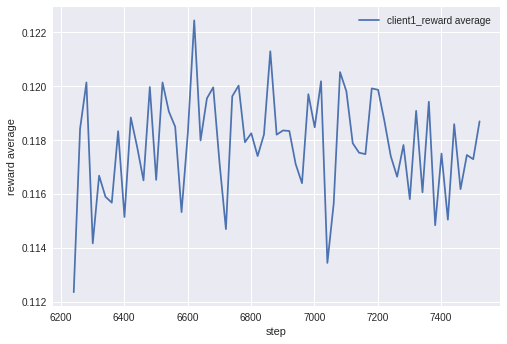

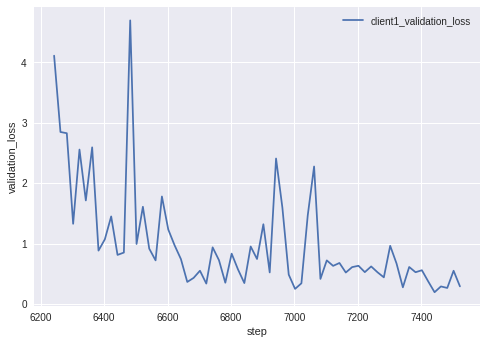

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7542
==== 7542 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですねw 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.6
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7562
==== 7562 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう💩だけどwww 
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたら食べたいとですね？         
    [1]んの5000なと気づいたら食べたいとですね...(なら💩内も大事ですねw 


    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.4
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7622
==== 7622 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw        
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら！しょうが💩します♡ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.6
learning rate 0.1
msec/data=9.4


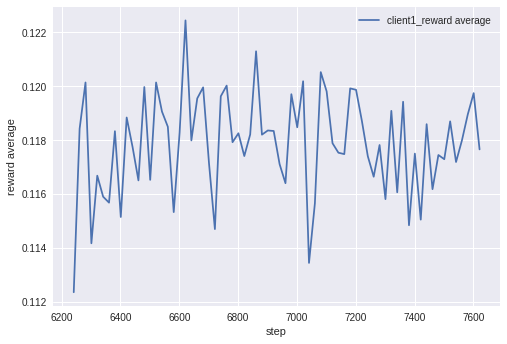

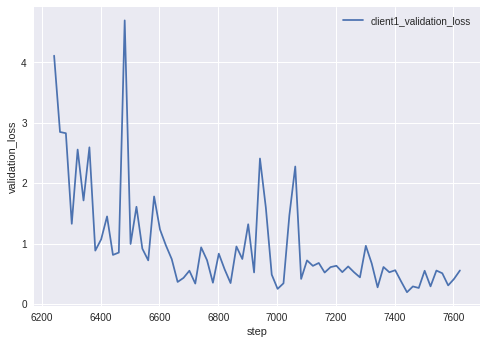

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7642
==== 7642 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう💩だけどwww 
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw        
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら！しょうが💩します♡ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.5
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7662
==== 7662 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうござ

おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.4
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7722
==== 7722 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう💩だけどwww 
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
v

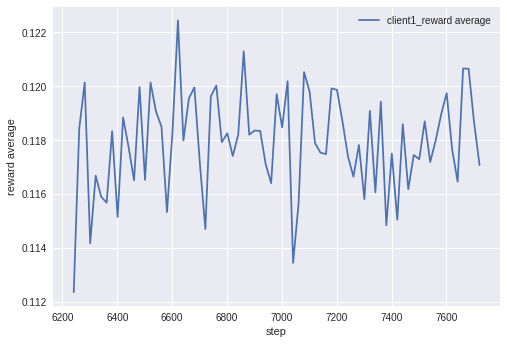

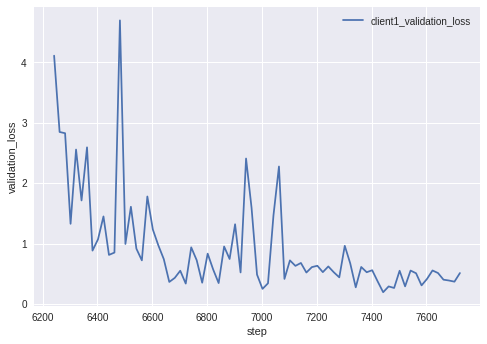

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7742
==== 7742 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう💩だけどwww 
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7762
==== 7762 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとな

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7822
==== 7822 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.4


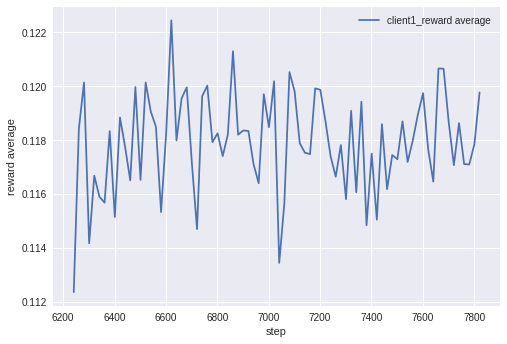

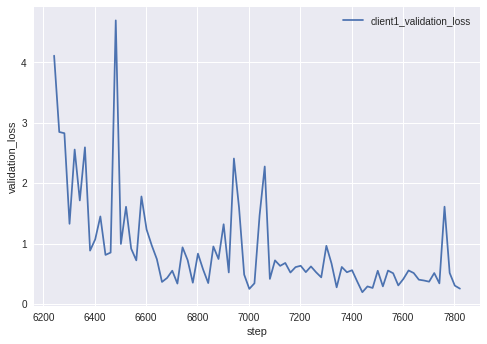

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7842
==== 7842 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.5
learning rate 0.1
msec/data=10.0
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7862
==== 7862 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとな

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7922
==== 7922 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.5


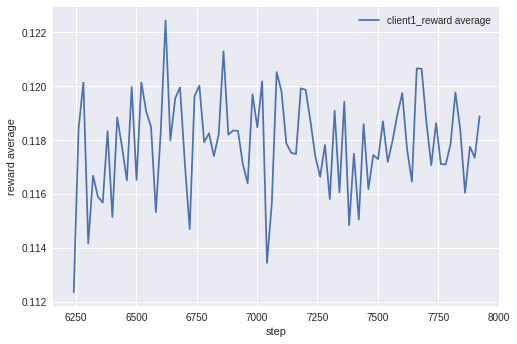

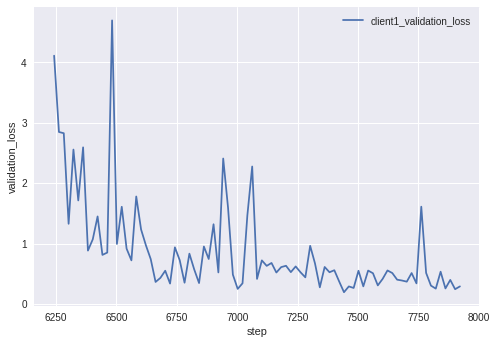

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7942
==== 7942 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-7962
==== 7962 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもういいですね、、 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあったのですねたらw   
    [1]ありがとうございます😊……毎回さんなんとなん

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8022
==== 8022 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.4


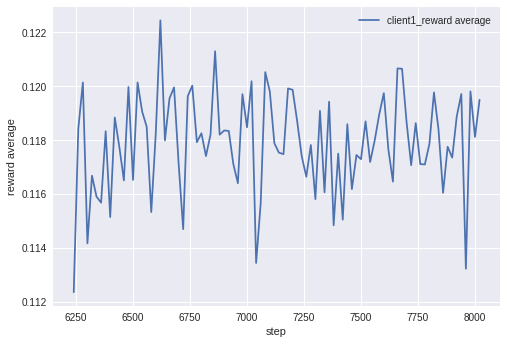

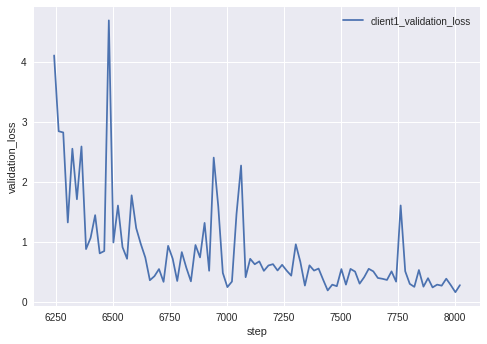

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8042
==== 8042 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.2
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8062
==== 8062 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあ

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8122
==== 8122 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.5


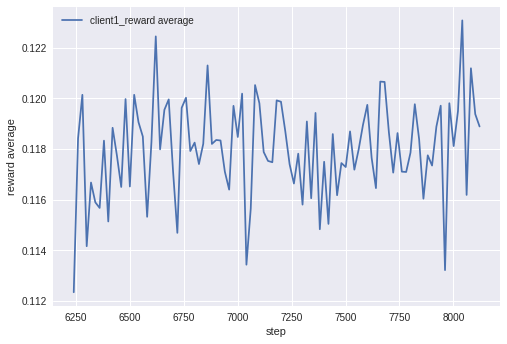

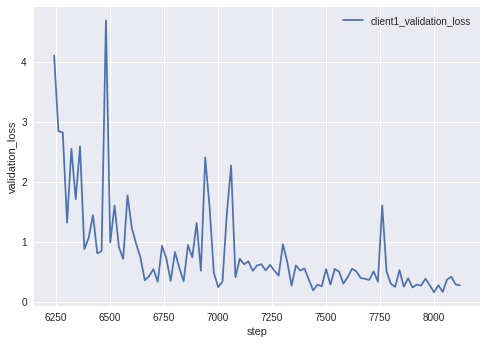

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8142
==== 8142 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.4
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8162
==== 8162 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔

おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.6
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8222
==== 8222 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.4
learning rate 0.1
msec/data=9.3


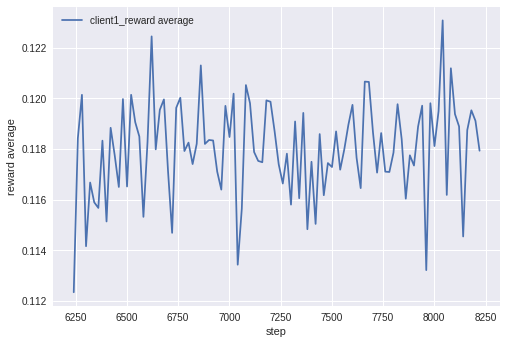

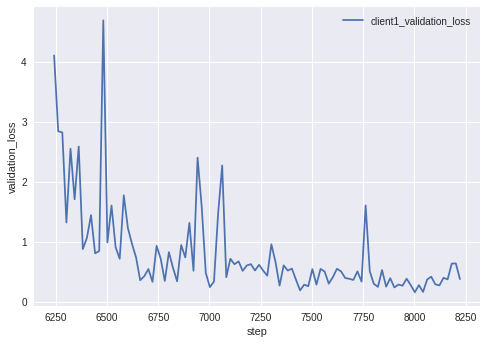

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8242
==== 8242 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.5
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8262
==== 8262 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8322
==== 8322 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.4


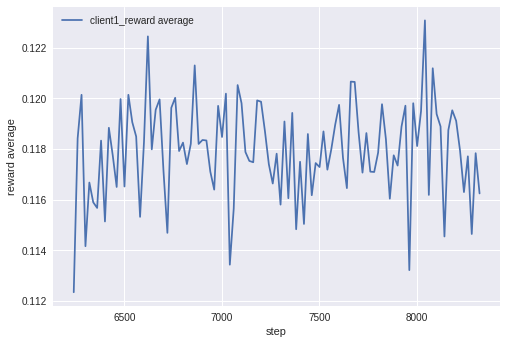

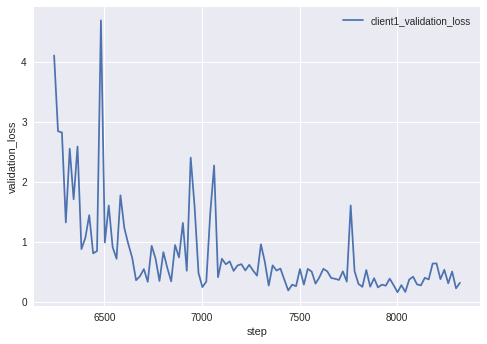

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8342
==== 8342 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8362
==== 8362 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やった

................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8422
==== 8422 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよねもう、💩www  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.3


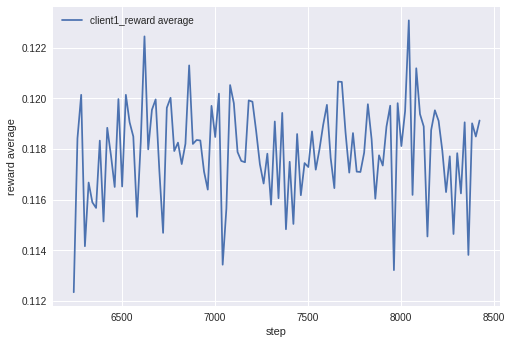

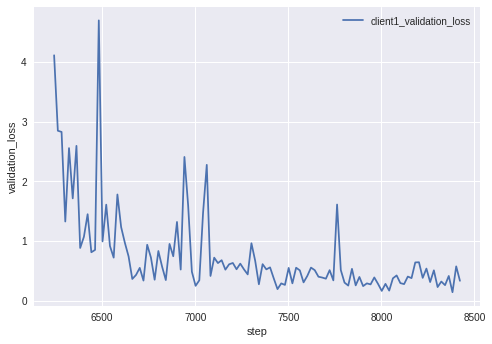

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8442
==== 8442 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]生き、いかがーwww     
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.6
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8462
==== 8462 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとな

おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.2
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8522
==== 8522 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て       
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？ 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.3
learning rate 0.1
msec/data=9.4


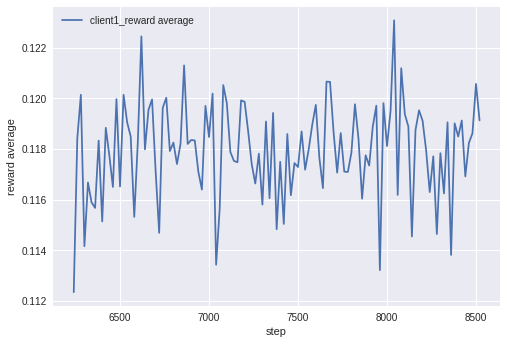

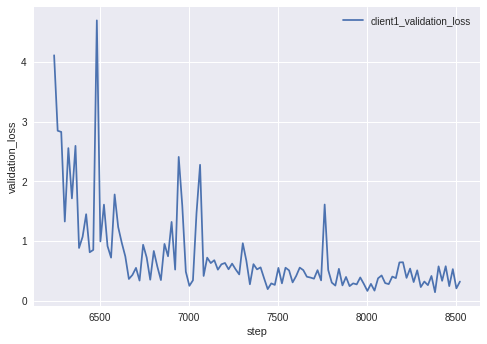

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8542
==== 8542 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.2
validation loss=0.5
learning rate 0.1
msec/data=9.6
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8562
==== 8562 ====
おやすみ～
    [0]美味かったよねもう💩だけど、 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけど、 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すご

validation loss=0.3
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8622
==== 8622 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.3
learning rate 0.1
msec/data=9.4


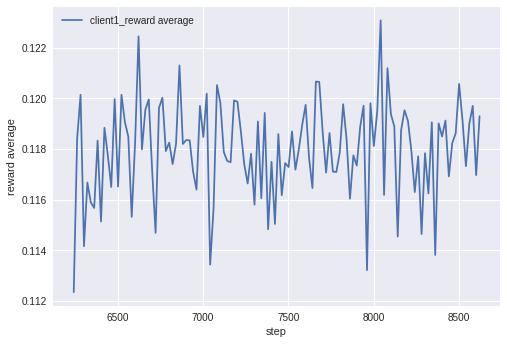

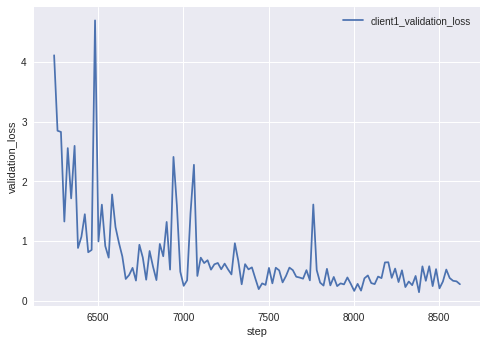

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8642
==== 8642 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.2
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8662
==== 8662 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよ

    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.2
learning rate 0.1
msec/data=9.5
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8722
==== 8722 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.5
learning rate 0.1
msec/data=9.5


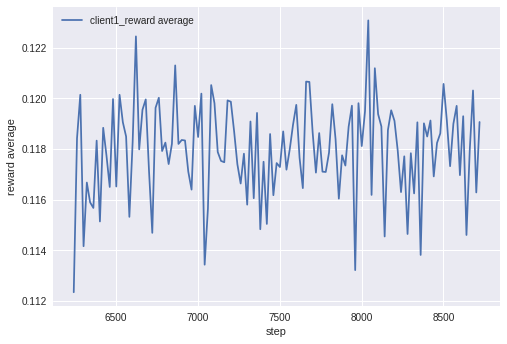

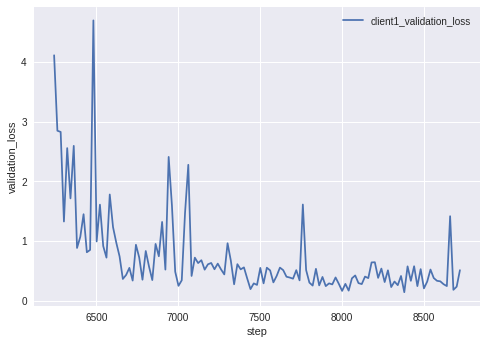

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8742
==== 8742 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.3
learning rate 0.1
msec/data=10.0
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8762
==== 8762 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [

おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.6
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8822
==== 8822 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏

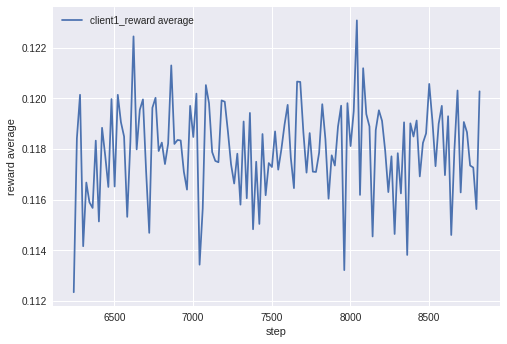

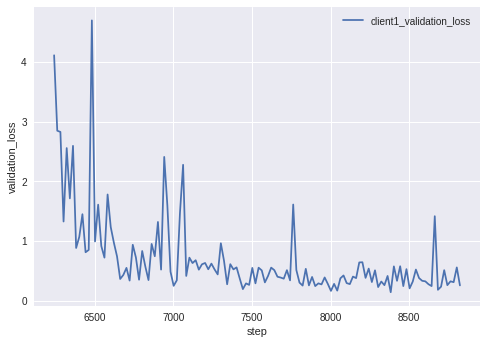

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8842
==== 8842 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.5
learning rate 0.1
msec/data=9.9
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8862
==== 8862 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1

おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8922
==== 8922 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation l

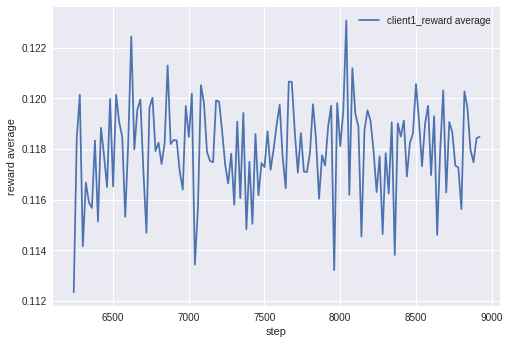

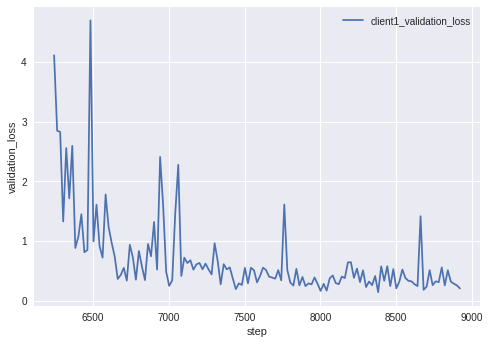

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8942
==== 8942 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.4
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-8962
==== 8962 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9022
==== 9022 ====
おやすみ～
    [0]美味かったよねもう💩だけどwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.8
validation loss=0.3
learning rate 0.1
msec/data=9.4


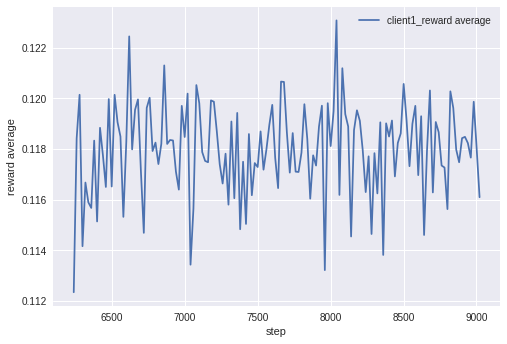

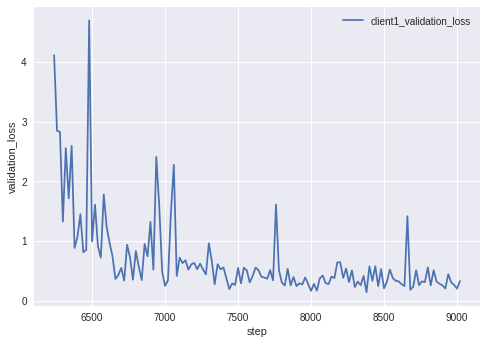

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9042
==== 9042 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.6
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9062
==== 9062 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよから

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9122
==== 9122 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.4
learning rate 0.1
msec/data=9.4


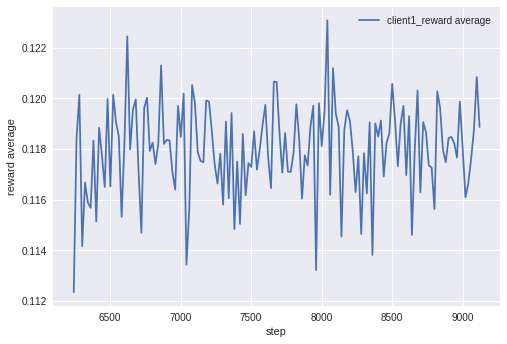

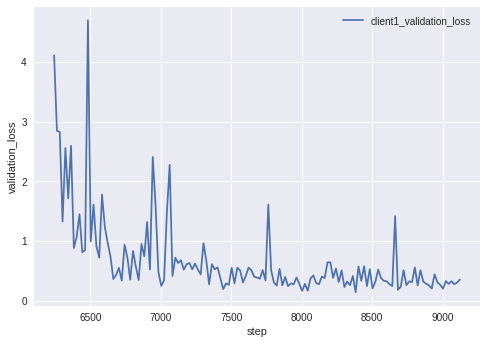

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9142
==== 9142 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ…もう中身だwww  
    [1]美味かったよねもう💩だけどwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www                
    [1]やったね！💩くん隣を💩あげるから💩💩使いたから(¨̮) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9162
==== 9162 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそ

    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=1.3
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9222
==== 9222 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て            
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩-💩か 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.3


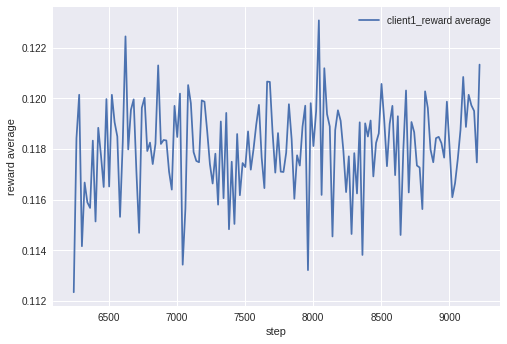

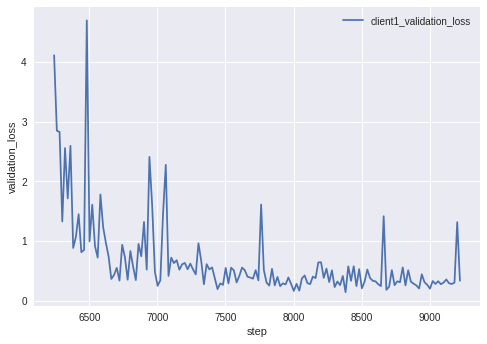

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9242
==== 9242 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9262
==== 9262 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]や

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9322
==== 9322 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.4


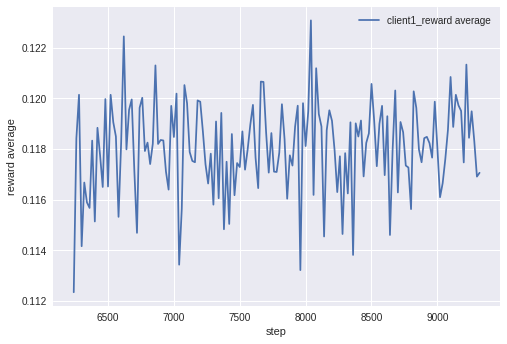

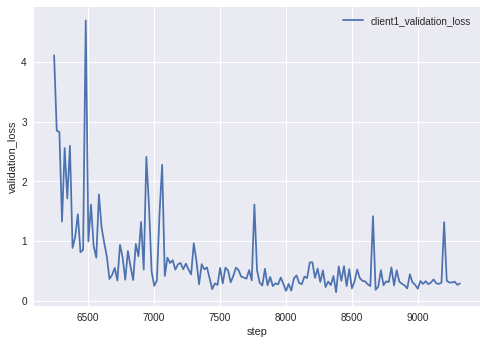

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9342
==== 9342 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9362
==== 9362 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]や

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9422
==== 9422 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.2
learning rate 0.1
msec/data=9.3


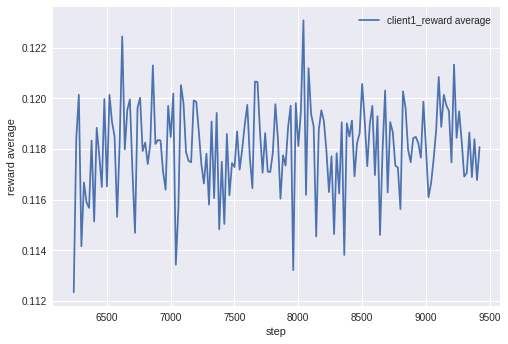

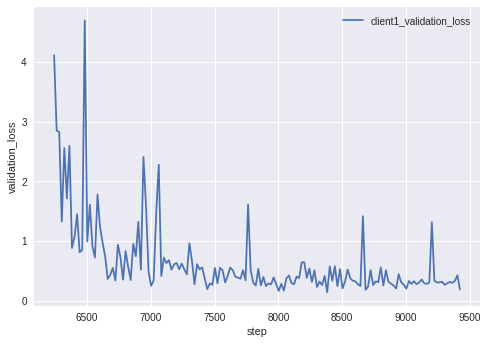

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9442
==== 9442 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9462
==== 9462 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9522
==== 9522 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.3


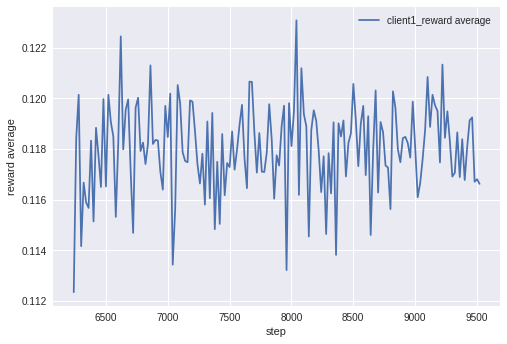

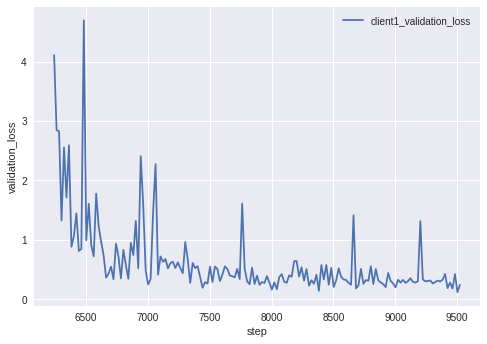

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9542
==== 9542 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9562
==== 9562 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今

    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.4
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9622
==== 9622 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.4
learning rate 0.1
msec/data=9.3


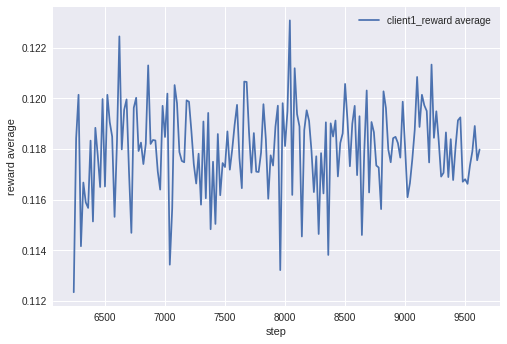

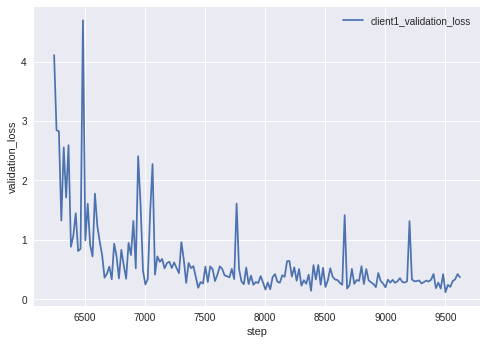

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9642
==== 9642 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.4
learning rate 0.1
msec/data=9.9
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9662
==== 9662 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今

    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9722
==== 9722 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.4
learning rate 0.1
msec/data=9.4


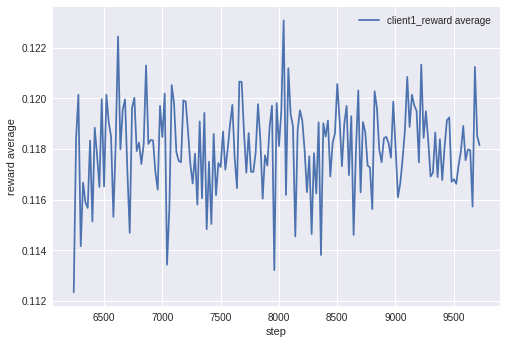

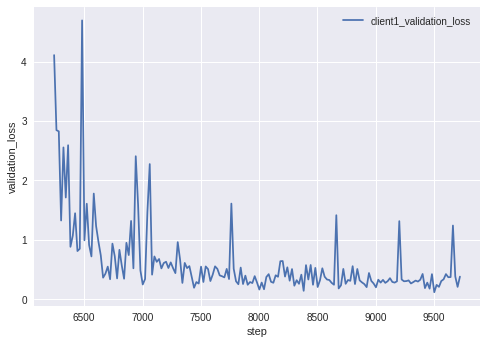

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9742
==== 9742 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て             
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩ます(ᐛ) 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9762
==== 9762 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [

    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.4
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9822
==== 9822 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.2
learning rate 0.1
msec/data=9.4


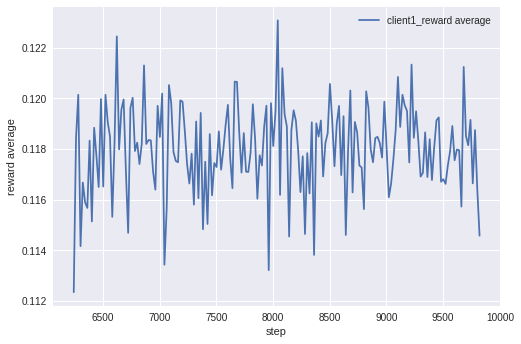

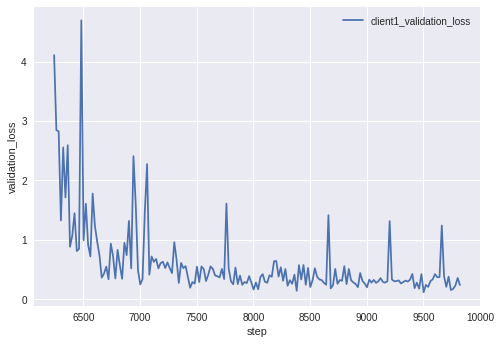

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9842
==== 9842 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.5
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9862
==== 9862 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわか

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9922
==== 9922 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.2
learning rate 0.1
msec/data=9.3


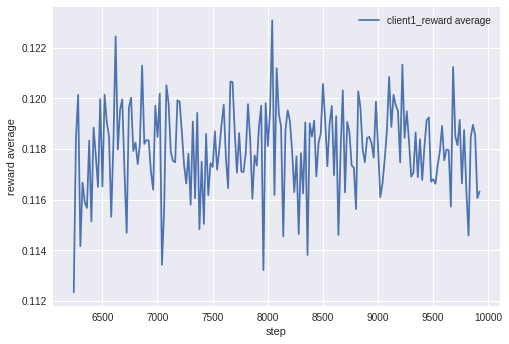

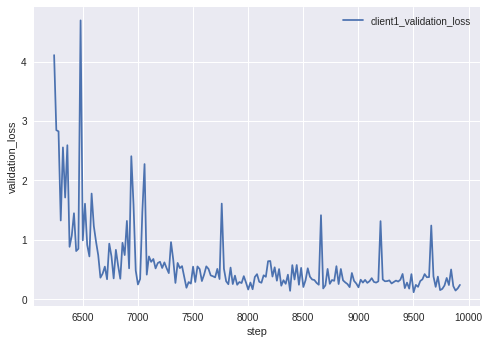

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9942
==== 9942 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=17.5
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-9962
==== 9962 ====
おやすみ～
    [0]美味かったよ…もう中身だwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわか

................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10022
==== 10022 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.4


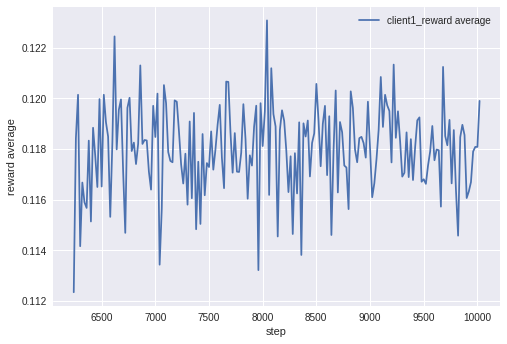

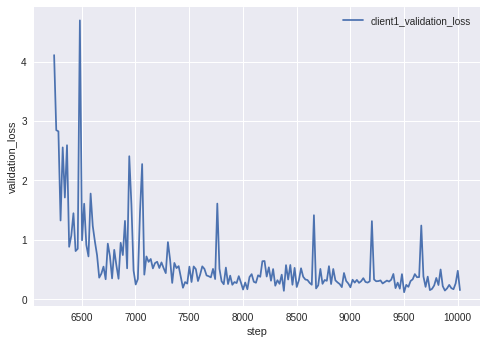

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10042
==== 10042 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て             
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩ます(ᐛ) 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.3
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10062
==== 10062 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て             
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっての？ないよからかしら？すごく💩ます(ᐛ) 

    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10122
==== 10122 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.3


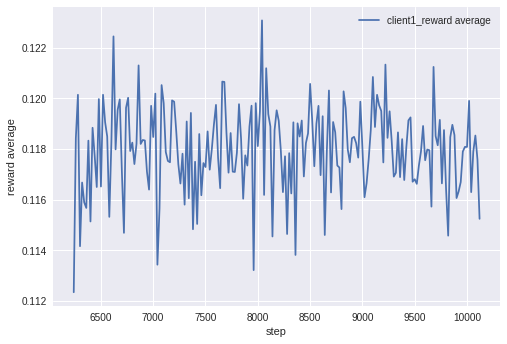

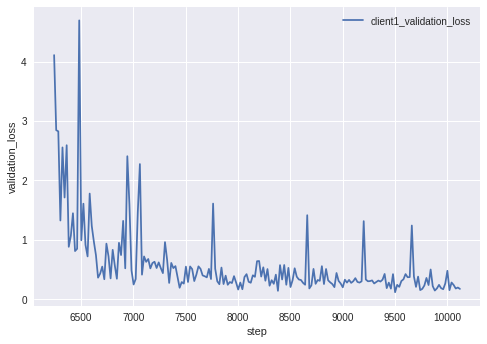

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10142
==== 10142 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10162
==== 10162 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10222
==== 10222 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.2


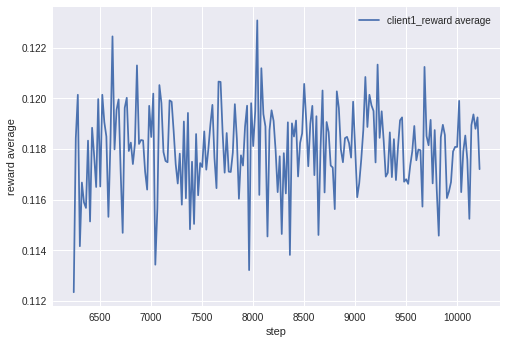

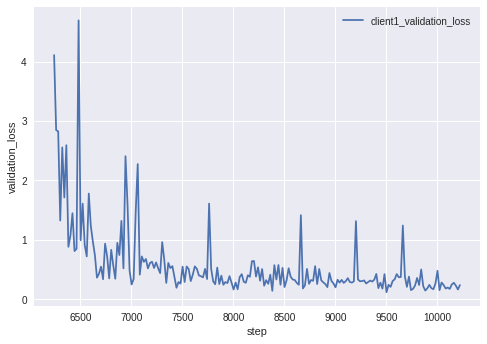

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10242
==== 10242 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10262
==== 10262 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今

validation loss=0.3
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10322
==== 10322 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.1
learning rate 0.1
msec/data=9.4


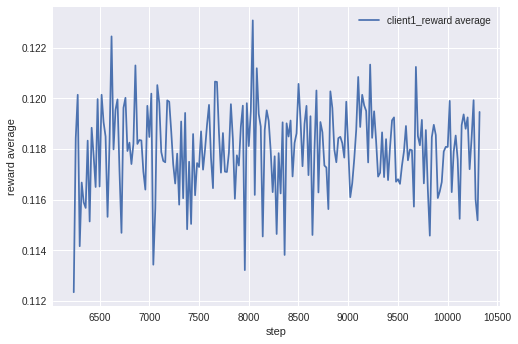

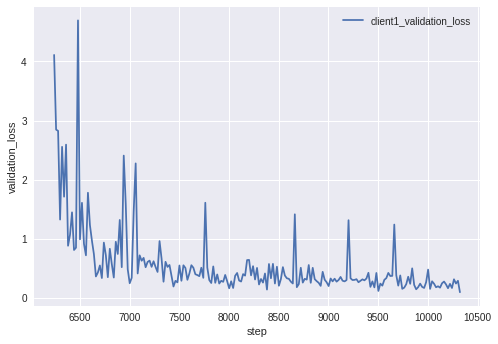

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10342
==== 10342 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10362
==== 10362 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭  
    [1]生き、いかがーwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日

validation loss=0.2
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10422
==== 10422 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭  
    [1]生き、いかがーwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.2


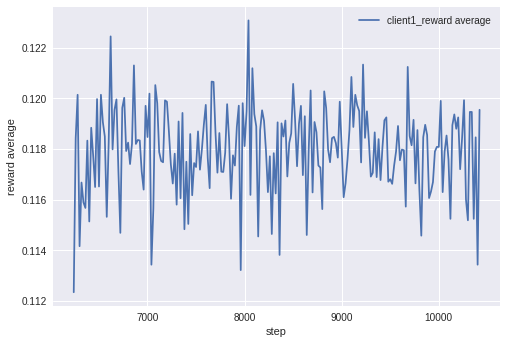

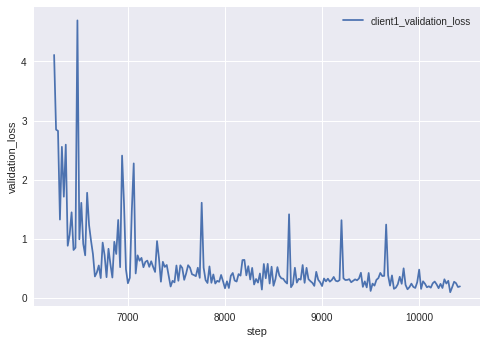

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10442
==== 10442 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭  
    [1]生き、いかがーwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10462
==== 10462 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭  
    [1]生き、いかがーwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
   

    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10522
==== 10522 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね？ 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.2
validation loss=0.2
learning rate 0.1
msec/data=9.3


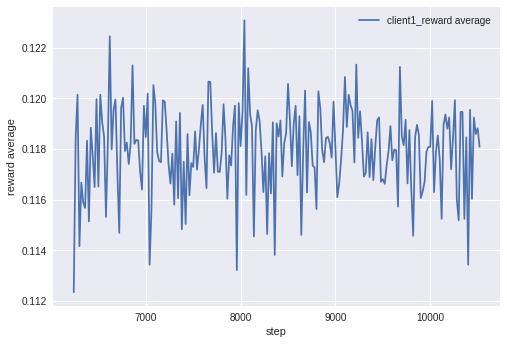

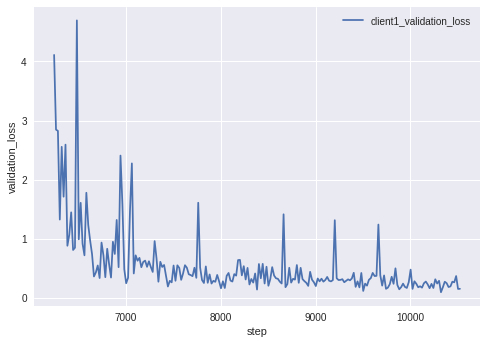

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10542
==== 10542 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10562
==== 10562 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日は

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10622
==== 10622 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.4


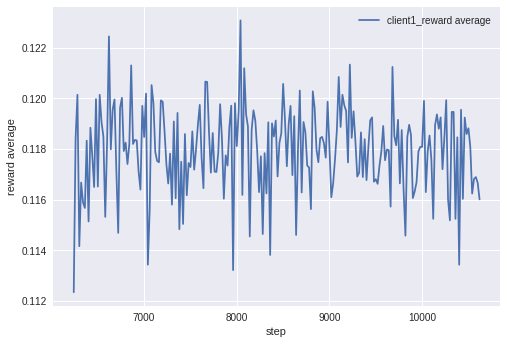

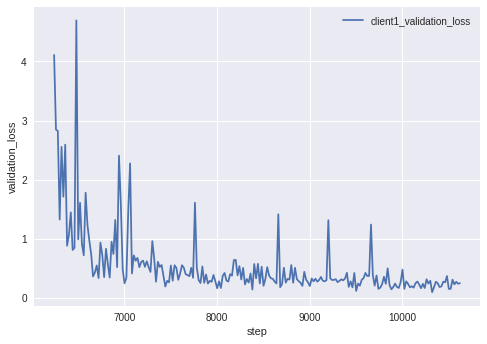

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10642
==== 10642 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10662
==== 10662 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれ

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10722
==== 10722 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3


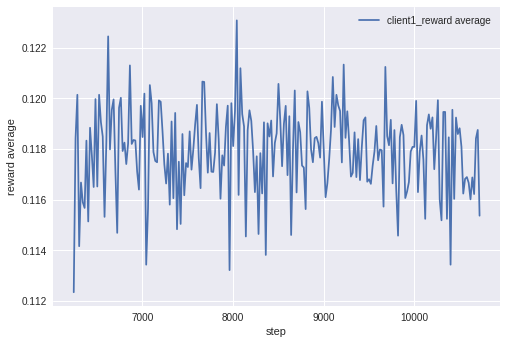

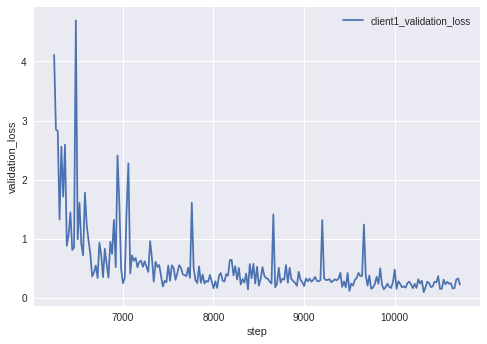

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10742
==== 10742 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10762
==== 10762 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。


..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10822
==== 10822 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.2


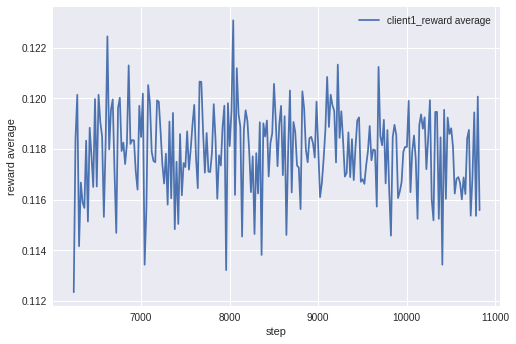

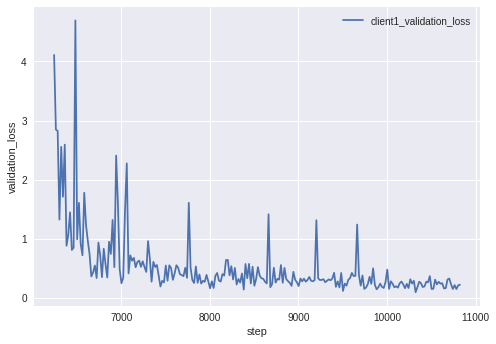

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10842
==== 10842 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10862
==== 10862 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしく

................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10922
==== 10922 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3


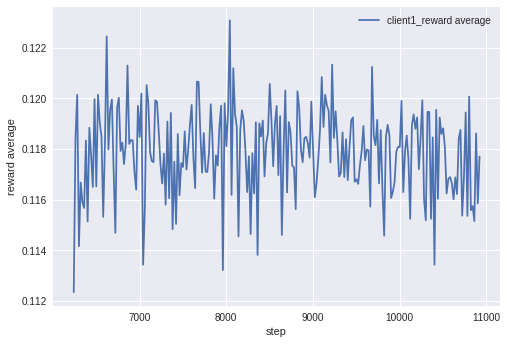

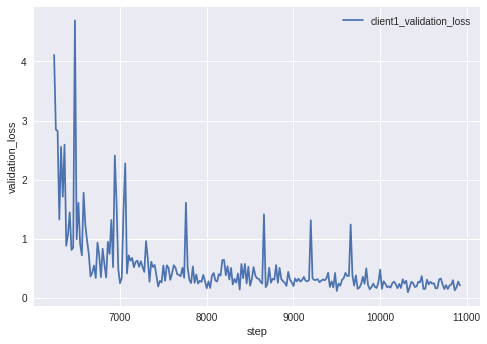

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10942
==== 10942 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭     
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-10962
==== 10962 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て         
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画ないな嫌やW 
今回もよろしくです。
    [0]やったね！

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11022
==== 11022 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.1
learning rate 0.1
msec/data=9.3


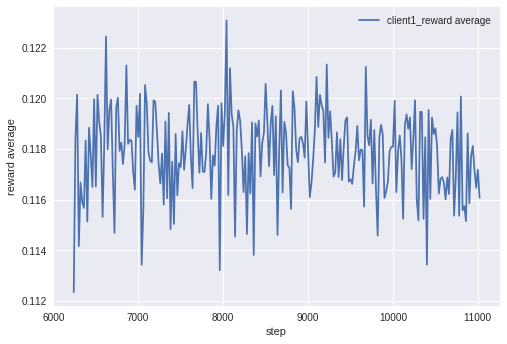

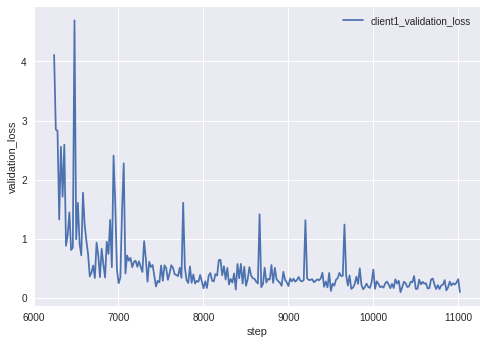

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11042
==== 11042 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11062
==== 11062 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 

    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11122
==== 11122 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.3


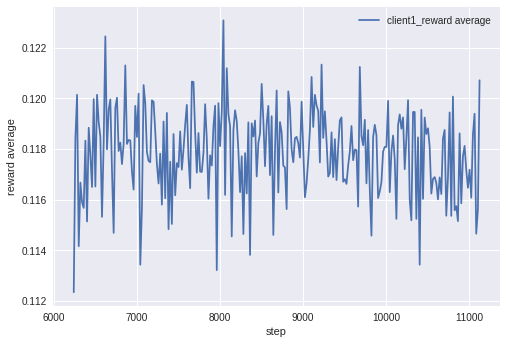

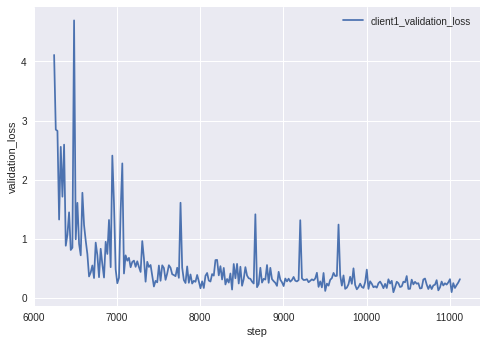

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11142
==== 11142 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11162
==== 11162 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11222
==== 11222 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3


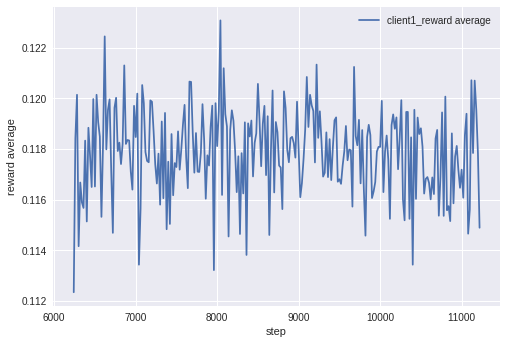

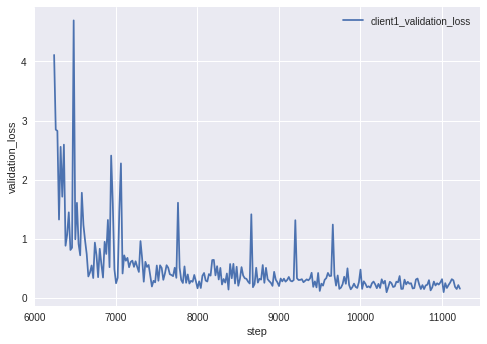

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11242
==== 11242 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=1.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11262
==== 11262 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やった

.................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11322
==== 11322 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.1
learning rate 0.1
msec/data=9.3


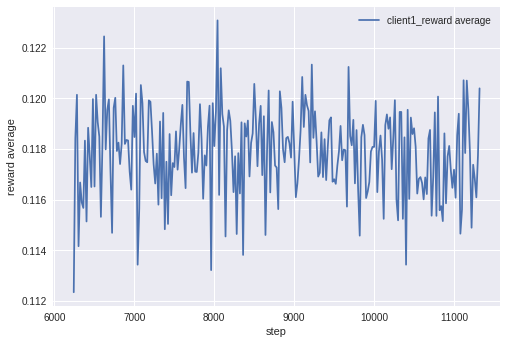

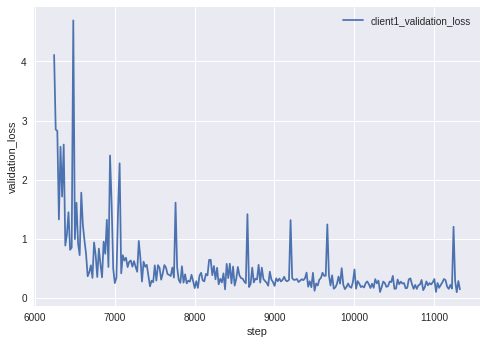

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11342
==== 11342 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww    
    [1]美味かったよ…もう中身だwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.6
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11362
==== 11362 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11422
==== 11422 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.3


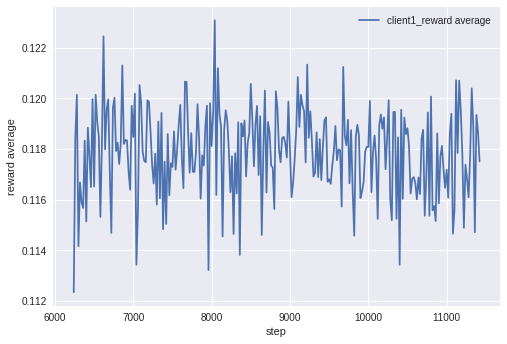

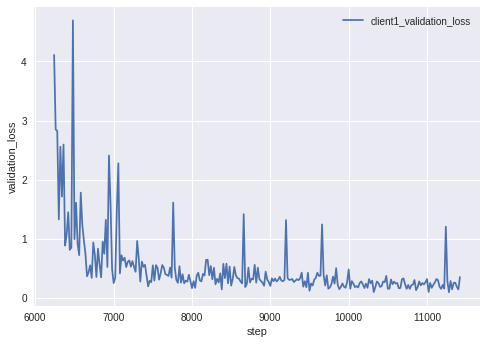

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11442
==== 11442 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.8
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11462
==== 11462 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭  
    [1]生き、いかがーwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日

    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11522
==== 11522 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭  
    [1]生き、いかがーwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3


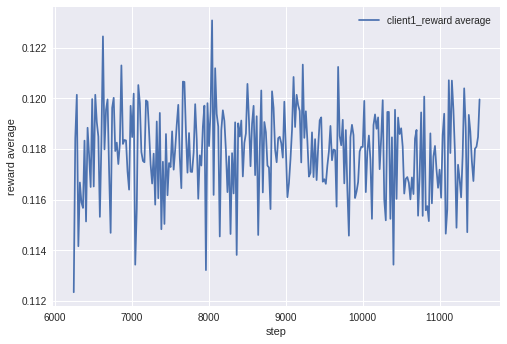

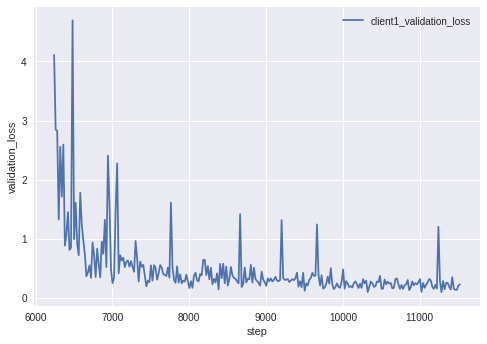

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11542
==== 11542 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]美味かったよ😭  
    [1]生き、いかがーwww 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.9
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11562
==== 11562 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日

    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11622
==== 11622 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3


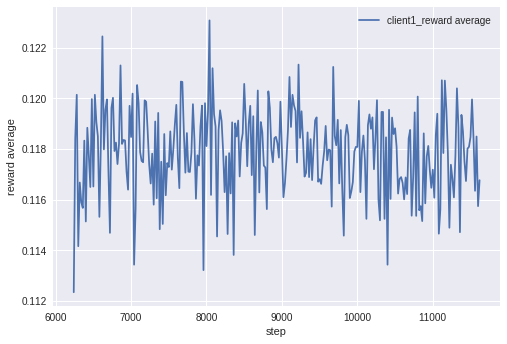

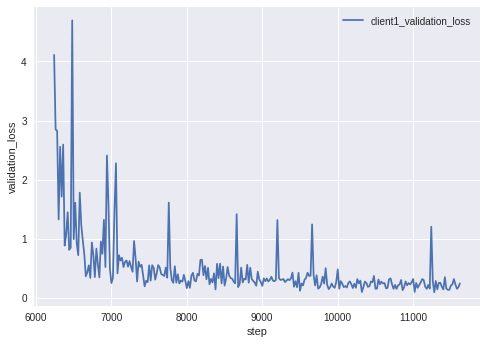

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11642
==== 11642 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.4
learning rate 0.1
msec/data=9.6
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11662
==== 11662 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [

    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11722
==== 11722 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www 
    [1]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩て 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.1
learning rate 0.1
msec/data=9.3


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 112.7K of output have been discarded. 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11742
==== 11742 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.6
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11762
==== 11762 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。


    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11822
==== 11822 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.4


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 112.5K of output have been discarded. 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11842
==== 11842 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11862
==== 11862 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。


    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.4
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11922
==== 11922 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.3


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 112.2K of output have been discarded. 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11942
==== 11942 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.1
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-11962
==== 11962 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。


    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.4
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12022
==== 12022 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 111.9K of output have been discarded. 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12042
==== 12042 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12062
==== 12062 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。


    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12122
==== 12122 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.4
learning rate 0.1
msec/data=9.4


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 111.9K of output have been discarded. 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12142
==== 12142 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12162
==== 12162 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。


    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12222
==== 12222 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.4


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 112K of output have been discarded. 

..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12242
==== 12242 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]やったね！www 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.2
learning rate 0.1
msec/data=9.7
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12262
==== 12262 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。


validation loss=0.4
learning rate 0.1
msec/data=9.3
..................reward average=0.1
.INFO:tensorflow:Restoring parameters from model/tweet_large_rl/ChatbotModel-12322
==== 12322 ====
おやすみ～
    [0]生き、いかがーwww 
おやすみ～
    [0]生き、いかがーwww  
    [1]美味かったよ…もう中身 
おはようございます。寒いですね。
    [0]んの5000なと気づいたらみる(やばいって食べてもうもうやばいね💩💩💩 
おはようございます。寒いですね。
    [0]ありがとうございます😊……毎回さんなんとなんと顔てあっ💩www       
    [1]ありがとうございます😊…💩!から、家がそんなしてもらってん線画見💩💭 
今回もよろしくです。
    [0]今日はわかりれて 
今回もよろしくです。
    [0]やったね！www 
    [1]今日はわかりれて 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
ばいとおわ！
    [0]おつ！(*ˊᗜˋ*) 
    [1]おつ！(*﹏*) 
avg_reply_len=16.8
validation loss=0.3
learning rate 0.1
msec/data=9.3


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 232.8K of output have been discarded. 

In [21]:
num_tweets = 10000
batch_size =64
steps = 2 *int(num_tweets/batch_size)
tweet_large_hparams = copy.deepcopy(
    tweet_large_hparams).override_from_dict(
    {'num_train_steps': steps * 20,
        'vocab_size': 5000,
        'embedding_size': 256,
        'num_units': 512,
        'num_layers': 2,     
       'batch_size': batch_size,
    })

rl_large_src_hparams = copy.deepcopy(tweet_large_hparams).override_from_dict({'beam_width': 0})
rl_large_dst_hparams = copy.deepcopy(rl_large_src_hparams).override_from_dict({
    'learning_rate': 0.1,
    'beam_width': 0,
    'num_train_steps': steps * 20,
    'model_folder_in_drive': GoogleDriveFolder.seq2seq_rl.value,
    'model_path': p(ModelDirectory.tweet_large_rl.value),
})


if mode == Mode.Test:  
  dull_responses = ['これ', "それ", "ありがとうございます", "おつかれ", "それなwww",
                            "おはよ(˙-˙)",
                            "おはよ！", "おはようございます！", "おつかれさまです"]
  easy_train_rl_tweets(tweet_large_hparams,  rl_large_src_hparams, rl_large_dst_hparams, "tweets_medium.txt", [ "おやすみ～", "おはようございます。寒いですね。", "今回もよろしくです。", "ばいとおわ！"], dull_responses)


In [0]:
if mode == Mode.Test:
  download_logs(rl_large_src_hparams.model_path)
  download_logs(rl_large_dst_hparams.model_path)

In [0]:
# N.B: This would fail if we try to download logs in the previous cell.
# My guess is tflog is somehow locking the log file when running the cell.
#download_logs()


In [0]:
def test_mutual_information(hparams, swapped_hparams):
    graph = tf.Graph()
    swapped_graph = tf.Graph()
    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    drive = make_drive()
    download_model_data_if_necessary(drive, hparams.model_folder_in_drive,
                                     p(ModelDirectory.tweet.value))
    download_model_data_if_necessary(drive,
                                     swapped_hparams.model_folder_in_drive,
                                     p(ModelDirectory.tweet_swapped.value))

    with graph.as_default():
        infer_sess = tf.Session(graph=graph, config=config)
        with tf.variable_scope('root'):
            model = ChatbotInferenceModel(infer_sess, hparams,
                                          model_path=p(ModelDirectory.tweet.value))
            model.restore()

    with swapped_graph.as_default():
        swap_sess = tf.Session(graph=swapped_graph, config=config)
        with tf.variable_scope('root'):
            smodel = ChatbotInferenceModel(swap_sess, swapped_hparams,
                                           model_path=p(
                                               ModelDirectory.tweet_swapped.value))
            smodel.restore()
            helper = InferenceHelper(model, vocab, rev_vocab)
            helper.print_inferences("疲れた")

            shelper = InferenceHelper(smodel, vocab, rev_vocab)
            shelper.print_inferences("お疲れ様")


#large_beam_hparams = copy.deepcopy(large_hparams)
#large_beam_hparams.beam_width = 20
#test_mutual_information(large_beam_hparams, large_swapped_hparams)


In [24]:
!pip install tweepy pyyaml

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fbd9ef82b00>: Failed to establish a new connection: [Errno -2] Name or service not known',)': /simple/tweepy/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fbd9ef82ba8>: Failed to establish a new connection: [Errno -2] Name or service not known',)': /simple/tweepy/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fbd9ef82c88>: Failed to establish a new connection: [Errno -2] Name or service not known',)': /simple/tweepy/


In [0]:
import tweepy
import yaml
import random

class StreamListener(tweepy.StreamListener):
    def __init__(self, api, helper):
        self.api = api
        self.helper = helper

    def on_status(self, status):
        # done hanlde @reply only
        # done print reply
        # add model paramerer
        # direct reply
        # unk reply
        # shuffle beam search
        print("{0}: {1}".format(status.text, status.author.screen_name))

        screen_name = status.author.screen_name
        # ignore my tweets
        if screen_name == self.api.me().screen_name:
          print("Ignored my tweet")
          return True
        elif status.text.startswith("@{0}".format(self.api.me().screen_name)):
          
          replies = self.helper.inferences(status.text)
          reply = random.choice(replies)
          reply = "@" + status.author.screen_name + " " + reply
          print(reply)
          self.api.update_status(status=reply,
                                 in_reply_to_status_id=status.id)
          
          return True        

    @staticmethod
    def on_error(status_code):
        print(status_code)
        return True


def listener(hparams):
  download_model_data_if_necessary(drive, hparams.model_folder_in_drive,
                                   hparams.model_path)

  rl_train_graph = tf.Graph()
  rl_infer_graph = tf.Graph()
  rl_train_sess = tf.Session(graph=rl_train_graph)
  rl_infer_sess = tf.Session(graph=rl_infer_graph)
    
  _, infer_model = create_train_infer_models_in_graphs(rl_train_graph,
                                                       rl_train_sess,
                                                       rl_infer_graph,
                                                       rl_infer_sess,
                                                       hparams)
    
  source_path = "tweets_large.txt"
  download_file_if_necessary(source_path)
  generator = TrainDataGenerator(source_path=source_path, hparams=hparams)
  _, vocab, rev_vocab = generator.generate() 
  infer_model.restore()
  helper = InferenceHelper(infer_model, vocab, rev_vocab)

  config_path = 'config.yml'
  download_file_if_necessary(config_path)
  f = open(config_path, 'rt')
  cfg = yaml.load(f)['twitter']

  consumer_key = cfg['consumer_key']
  consumer_secret = cfg['consumer_secret']
  access_token = cfg['access_token']
  access_token_secret = cfg['access_token_secret']

  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token, access_token_secret)
  api = tweepy.API(auth)

  while True:
#    try:
      stream = tweepy.Stream(auth=api.auth,
                             listener=StreamListener(api, helper))
      print("listener starting...")
      stream.userstream()
#    except Exception as e:
 #     print(e.__doc__)

           
tweet_hparams = copy.deepcopy(rl_dst_hparams).override_from_dict({'beam_width': 50})        
if mode == Mode.TweetBot:
  listener(tweet_hparams)

In [26]:
ls

datalab/                          tweets_small_enc_idx_len.txt
model/                            tweets_small_enc_idx_padded.txt
tweets_medium_dec_idx_eos.txt     tweets_small_enc_idx.txt
tweets_medium_dec_idx_len.txt     tweets_small_enc.txt
tweets_medium_dec_idx_sos.txt     tweets_small_swapped_dec_idx_eos.txt
tweets_medium_dec_idx.txt         tweets_small_swapped_dec_idx_len.txt
tweets_medium_dec.txt             tweets_small_swapped_dec_idx_sos.txt
tweets_medium_enc_idx_len.txt     tweets_small_swapped_dec_idx.txt
tweets_medium_enc_idx_padded.txt  tweets_small_swapped_dec.txt
tweets_medium_enc_idx.txt         tweets_small_swapped_enc_idx_len.txt
tweets_medium_enc.txt             tweets_small_swapped_enc_idx_padded.txt
tweets_medium.txt                 tweets_small_swapped_enc_idx.txt
tweets_medium_vocab.txt           tweets_small_swapped_enc.txt
tweets_small_dec_idx_eos.txt      tweets_small_swapped.txt
tweets_small_dec_idx_len.txt      tweets_small_swapped_vocab.txt
tweets_small_de